In [1]:
!pip install segmentation-models-pytorch -U albumentations

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 kB 19.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=d93141c463f658f6d4bfebb9d6efcff5f871f1bbe9a96feec2cbd03074f7b2c3
  Stored in dir

In [2]:
! nvidia-smi

Mon Nov 25 03:10:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A

import torch
import torch.nn as nn
import torch.optim as optim

from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Data processing

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])

        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
        
        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  # Đọc ảnh dưới dạng BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert sang RGB
        label = self.read_mask(label_path)  
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)
            
        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

# Data visualization

In [5]:
# take the root train and train_gt folder
data_train_path = "/kaggle/input/polyps-bkai/train/train" # for image
data_train_gt_path = "/kaggle/input/polyps-bkai/train_gt/train_gt" # for lable
 
# get the files inside train and train_gt folder
train_image_name_list = os.listdir(data_train_path)
train_lable_name_list = os.listdir(data_train_gt_path)

# dir list of image and lable taken from train and train_gt folder
train_image_dirs = [os.path.join(data_train_path,train_image_file) for train_image_file in train_image_name_list]
train_lable_dirs = [os.path.join(data_train_gt_path,train_lable_file) for train_lable_file in train_lable_name_list]

print("number_of_image: ", len(train_image_dirs))
print("number_of_lable: ", len(train_lable_dirs))


number_of_image:  1000
number_of_lable:  1000


In [6]:

dataset = CustomImageDataset(img_dir= data_train_path,
                             label_dir= data_train_gt_path,
                             resize= (256,256),
                             transform = None)

# Model

In [7]:
import segmentation_models_pytorch as smp

In [8]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 77.4MB/s]


In [9]:
BATCH_SIZE = 8
images_data, labels_data = [], []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)

# Tranformation, Train, Validation

In [10]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label
    
    def __len__(self):
        return len(self.data)

    
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    # A.ToFloat(max_value=255),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_size = int(0.9 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

900
100


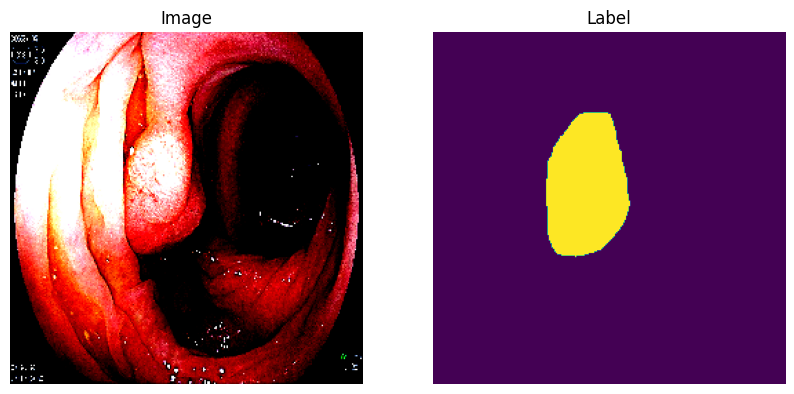

In [11]:
image,label = train_dataset[20]

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')  

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')  

plt.show()

# Base setup

In [12]:
NUM_EPOCHS = 200
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer

In [13]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)

# Wandb

In [15]:
!pip install wandb
import wandb

In [16]:
# ! wandb login "10a2c0921307e4b38882cec4b285ddf098953e3c"
PROJECT = 'Unet_polyp-Segmentation'
RESUME = "allow"
WANDB_KEY = "10a2c0921307e4b38882cec4b285ddf098953e3c"

In [17]:
wandb.init(
    project = PROJECT,
    resume=RESUME,
    config={
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS,
    },
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch [1/200] |         Train_loss: 0.2890749613 |         Train_accuracy: 0.3169860388 |         Val_loss: 0.1492321967 |         Val_accuracy: 0.3267685954
New best checkpoint saved!


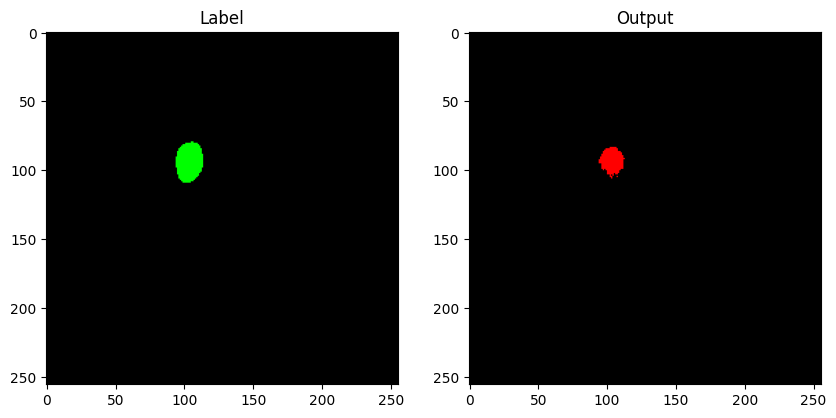

Epoch [2/200] |         Train_loss: 0.1196474356 |         Train_accuracy: 0.3264475109 |         Val_loss: 0.0967714655 |         Val_accuracy: 0.3269508870
New best checkpoint saved!


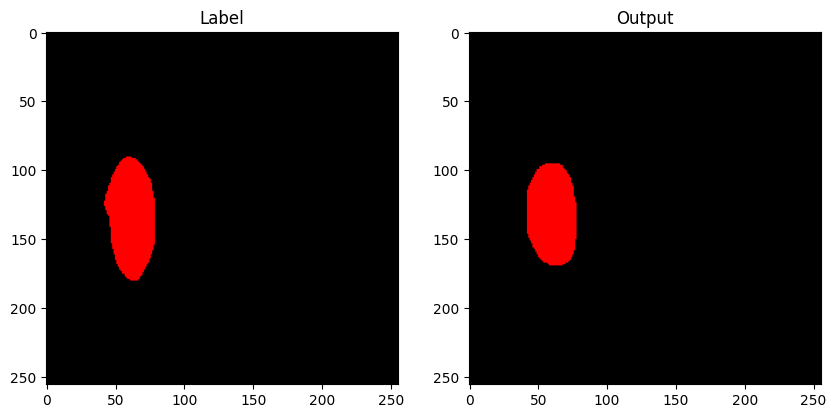

Epoch [3/200] |         Train_loss: 0.0844186004 |         Train_accuracy: 0.3272430759 |         Val_loss: 0.0766283758 |         Val_accuracy: 0.3278311666
New best checkpoint saved!


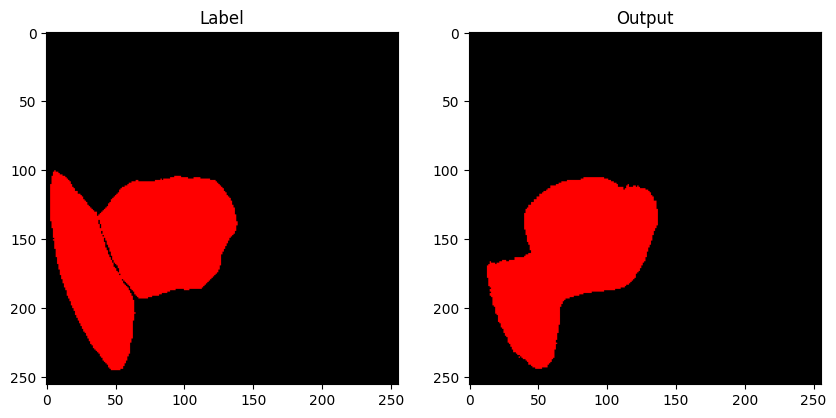

Epoch [4/200] |         Train_loss: 0.0669760861 |         Train_accuracy: 0.3281840741 |         Val_loss: 0.0666877914 |         Val_accuracy: 0.3276497904
New best checkpoint saved!


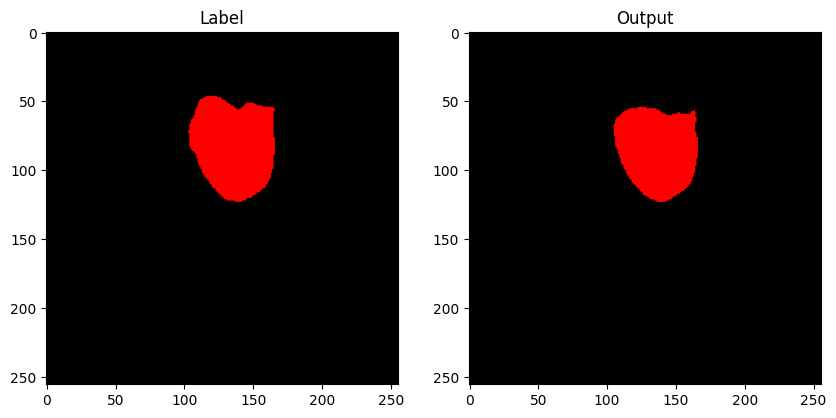

Epoch [5/200] |         Train_loss: 0.0564411723 |         Train_accuracy: 0.3283739556 |         Val_loss: 0.0627073478 |         Val_accuracy: 0.3278791300
New best checkpoint saved!


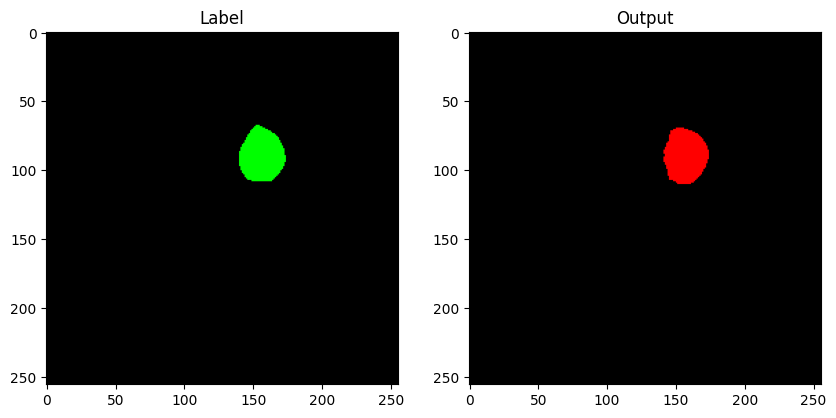

Epoch [6/200] |         Train_loss: 0.0495462325 |         Train_accuracy: 0.3286211593 |         Val_loss: 0.0536777013 |         Val_accuracy: 0.3283466593
New best checkpoint saved!


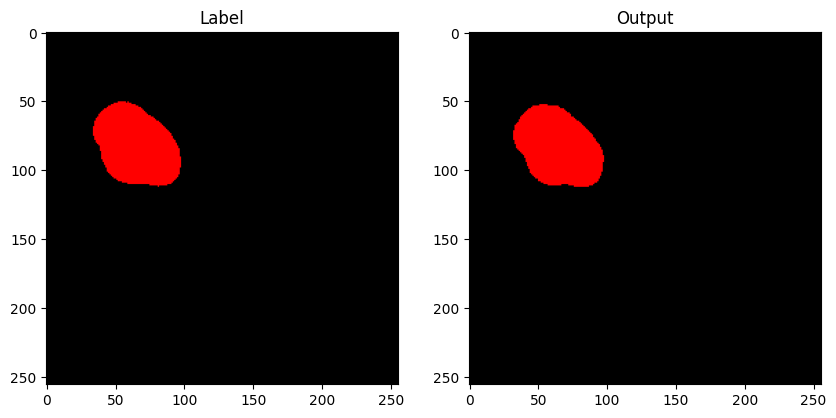

Epoch [7/200] |         Train_loss: 0.0461142124 |         Train_accuracy: 0.3287410482 |         Val_loss: 0.0569178471 |         Val_accuracy: 0.3283674622


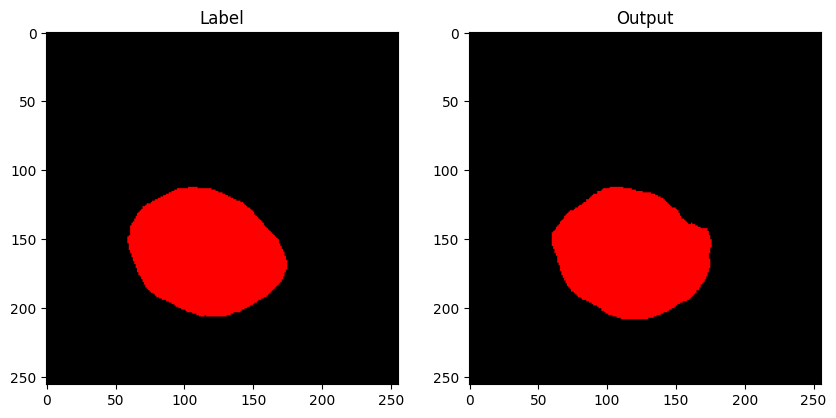

Epoch [8/200] |         Train_loss: 0.0391331183 |         Train_accuracy: 0.3292151388 |         Val_loss: 0.0553155497 |         Val_accuracy: 0.3278805542


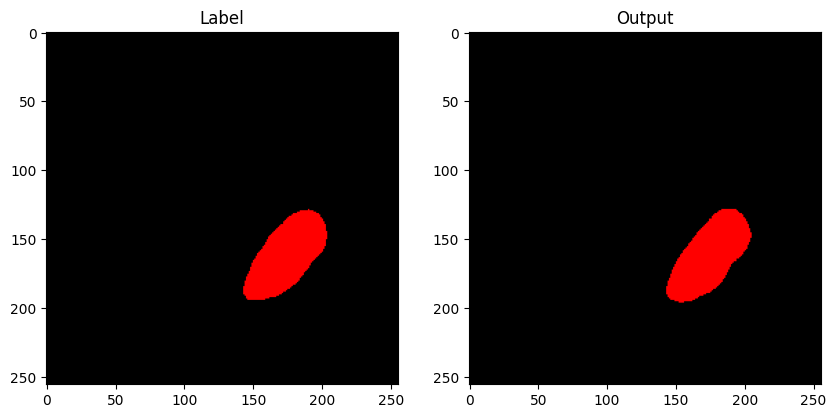

Epoch [9/200] |         Train_loss: 0.0376173911 |         Train_accuracy: 0.3292917209 |         Val_loss: 0.0464631878 |         Val_accuracy: 0.3286548360
New best checkpoint saved!


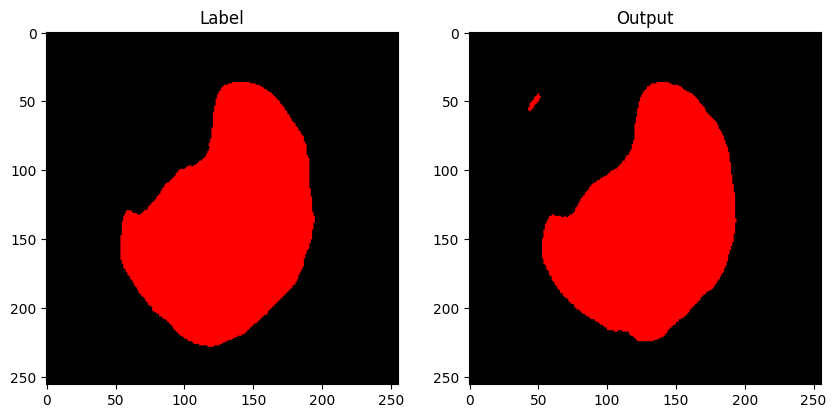

Epoch [10/200] |         Train_loss: 0.0332506594 |         Train_accuracy: 0.3294839704 |         Val_loss: 0.0510651739 |         Val_accuracy: 0.3283630371


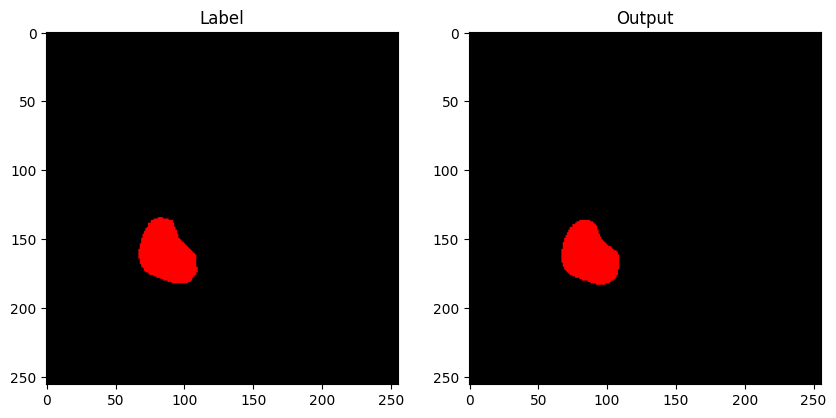

Epoch [11/200] |         Train_loss: 0.0372169908 |         Train_accuracy: 0.3290491288 |         Val_loss: 0.0708348523 |         Val_accuracy: 0.3272948710


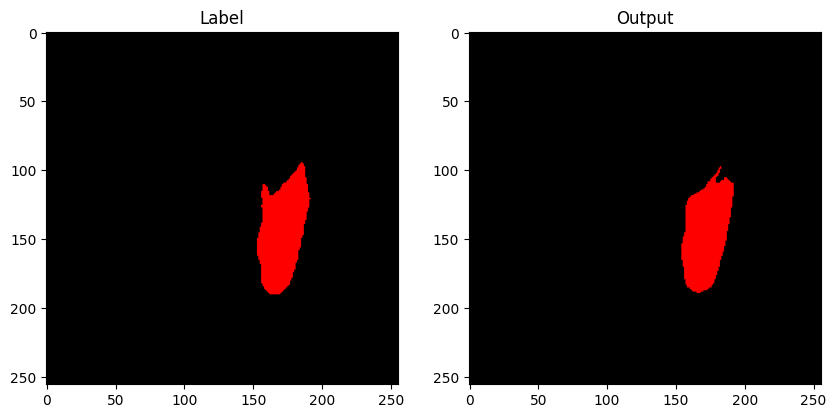

Epoch [12/200] |         Train_loss: 0.0350319862 |         Train_accuracy: 0.3292196147 |         Val_loss: 0.0486916844 |         Val_accuracy: 0.3283775838


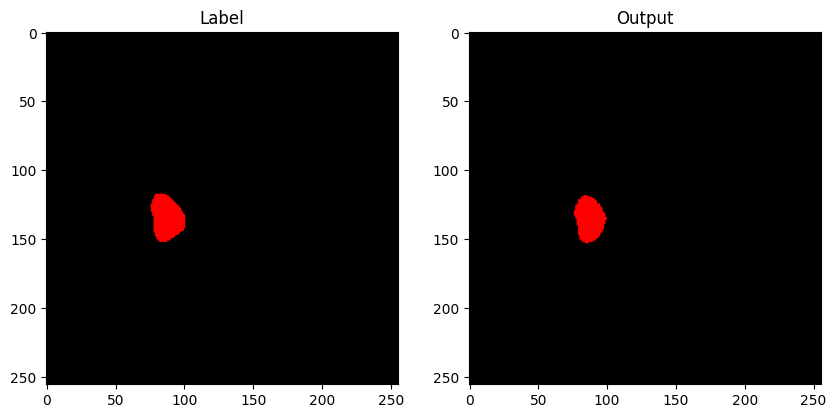

Epoch [13/200] |         Train_loss: 0.0289597143 |         Train_accuracy: 0.3296835271 |         Val_loss: 0.0511515141 |         Val_accuracy: 0.3283416239


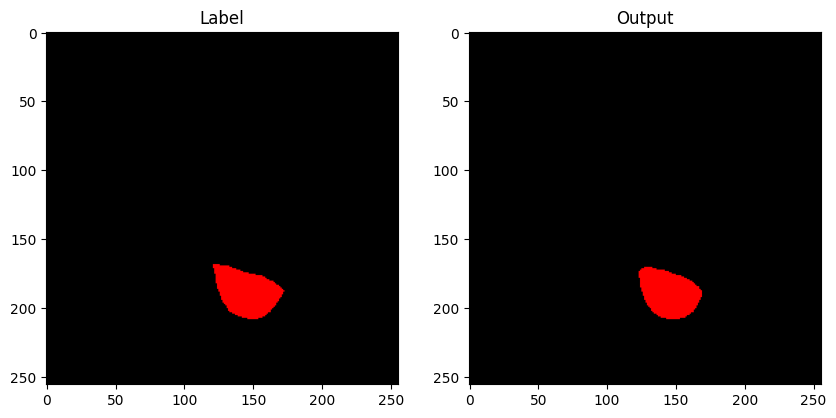

Epoch [14/200] |         Train_loss: 0.0291824148 |         Train_accuracy: 0.3297603861 |         Val_loss: 0.0527098279 |         Val_accuracy: 0.3284880575


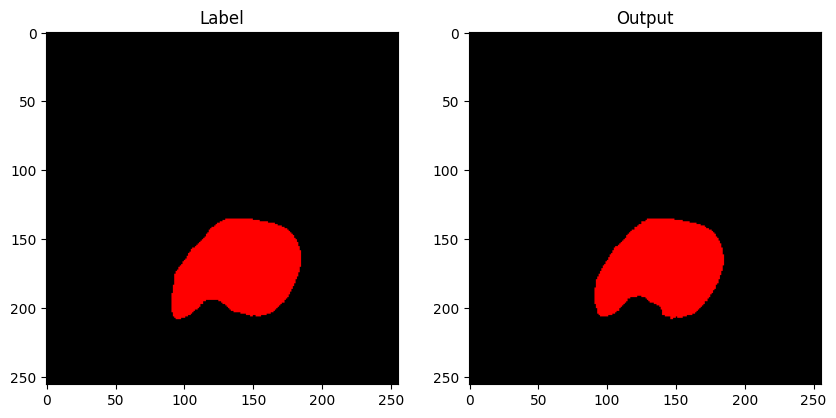

Epoch [15/200] |         Train_loss: 0.0265367846 |         Train_accuracy: 0.3298347247 |         Val_loss: 0.0550251544 |         Val_accuracy: 0.3284307861


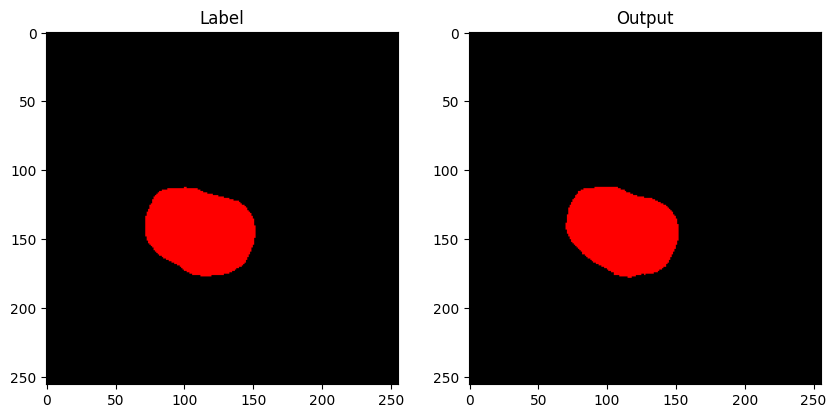

Epoch [16/200] |         Train_loss: 0.0231302394 |         Train_accuracy: 0.3300584807 |         Val_loss: 0.0484330848 |         Val_accuracy: 0.3288229370


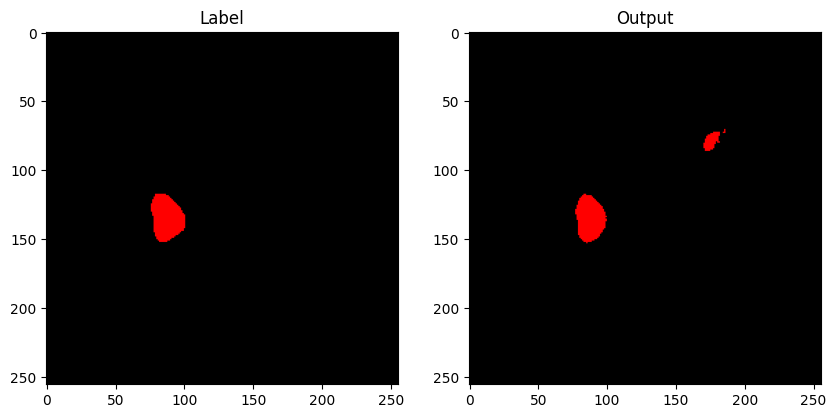

Epoch [17/200] |         Train_loss: 0.0252546803 |         Train_accuracy: 0.3300569661 |         Val_loss: 0.0574003057 |         Val_accuracy: 0.3279276021


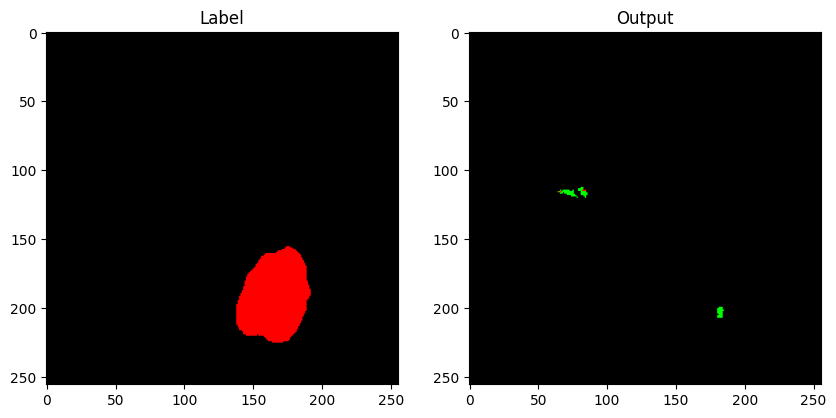

Epoch [18/200] |         Train_loss: 0.0255020939 |         Train_accuracy: 0.3304277660 |         Val_loss: 0.0495108841 |         Val_accuracy: 0.3291714478


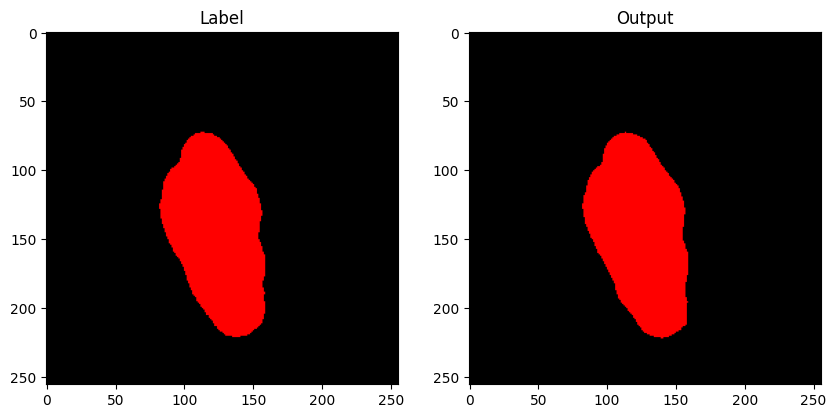

Epoch [19/200] |         Train_loss: 0.0211484940 |         Train_accuracy: 0.3312192903 |         Val_loss: 0.0474338161 |         Val_accuracy: 0.3291255188


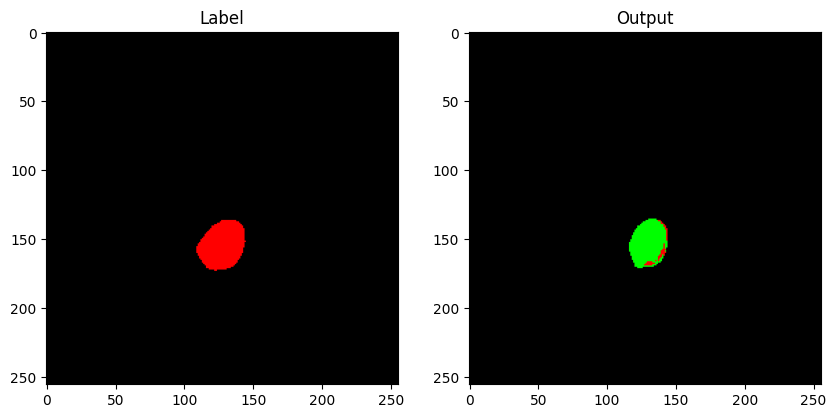

Epoch [20/200] |         Train_loss: 0.0202434375 |         Train_accuracy: 0.3312447894 |         Val_loss: 0.0504464379 |         Val_accuracy: 0.3290646871


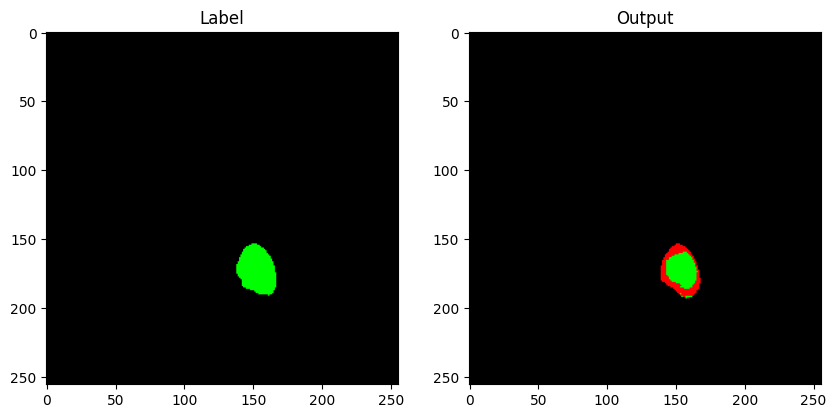

Epoch [21/200] |         Train_loss: 0.0211718443 |         Train_accuracy: 0.3309174206 |         Val_loss: 0.0477298799 |         Val_accuracy: 0.3288964844


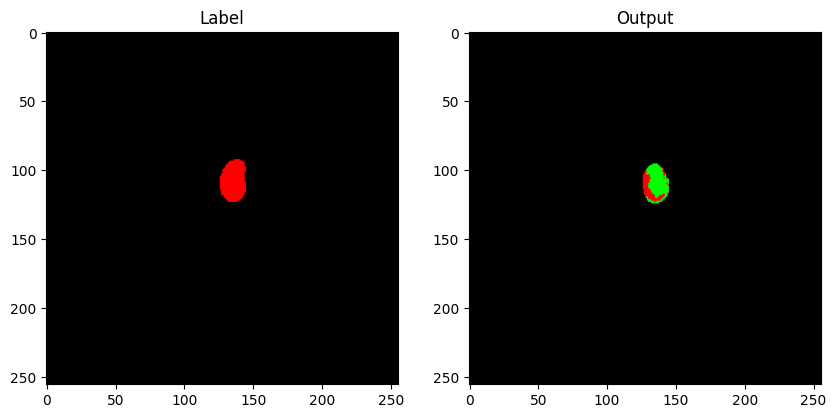

Epoch [22/200] |         Train_loss: 0.0229772837 |         Train_accuracy: 0.3308929782 |         Val_loss: 0.0513394552 |         Val_accuracy: 0.3288615926


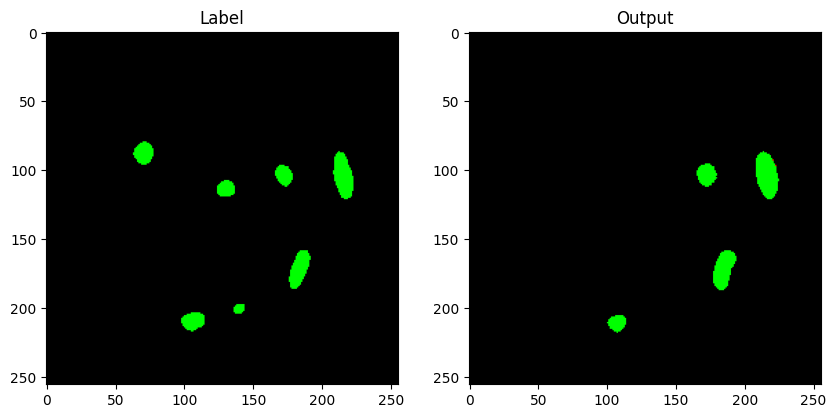

Epoch [23/200] |         Train_loss: 0.0198625197 |         Train_accuracy: 0.3312098637 |         Val_loss: 0.0700697417 |         Val_accuracy: 0.3284275309


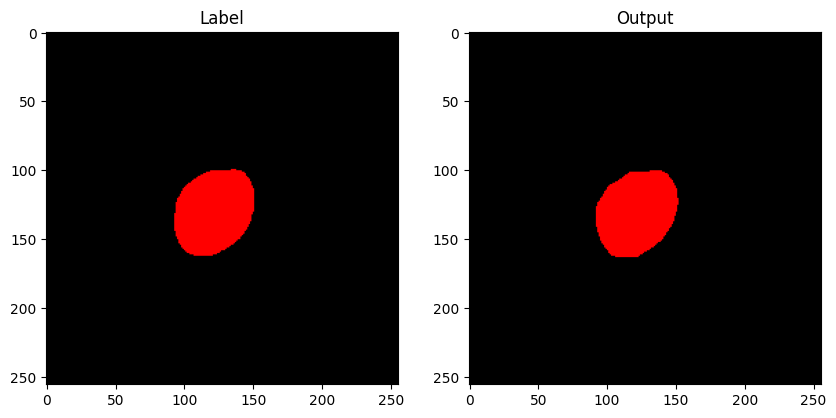

Epoch [24/200] |         Train_loss: 0.0191196078 |         Train_accuracy: 0.3312466148 |         Val_loss: 0.0546245569 |         Val_accuracy: 0.3288630676


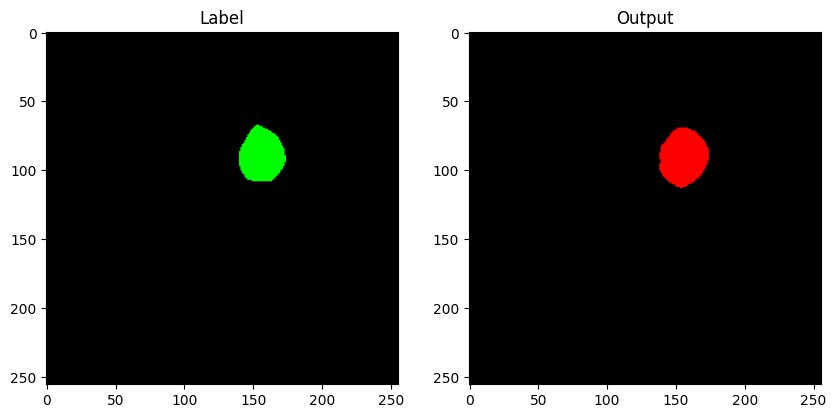

Epoch [25/200] |         Train_loss: 0.0178368801 |         Train_accuracy: 0.3313512505 |         Val_loss: 0.0512558774 |         Val_accuracy: 0.3290042623


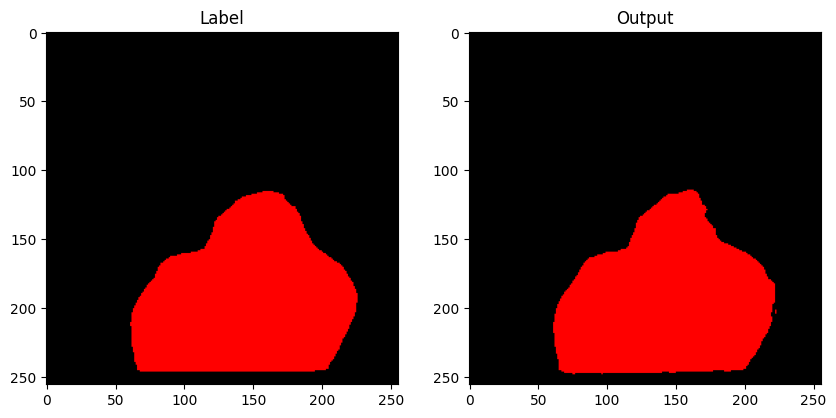

Epoch [26/200] |         Train_loss: 0.0145288385 |         Train_accuracy: 0.3317199481 |         Val_loss: 0.0534934749 |         Val_accuracy: 0.3287112427


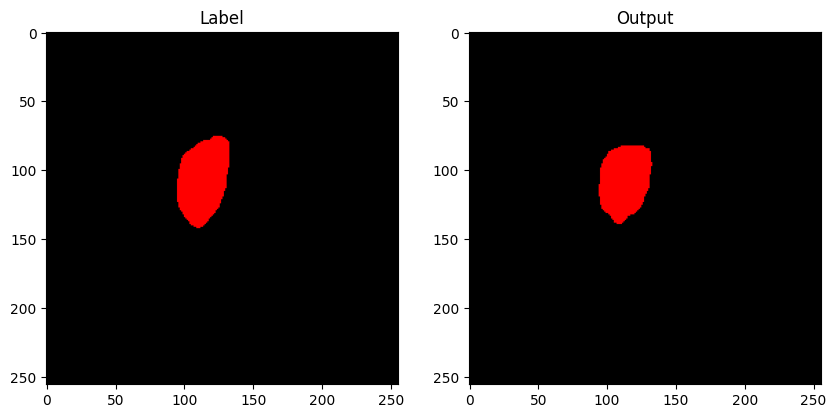

Epoch [27/200] |         Train_loss: 0.0132862374 |         Train_accuracy: 0.3318968935 |         Val_loss: 0.0486051860 |         Val_accuracy: 0.3299976603


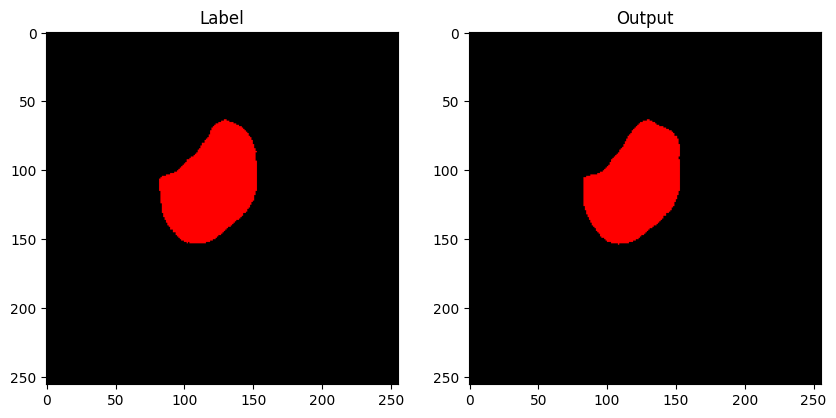

Epoch [28/200] |         Train_loss: 0.0124229429 |         Train_accuracy: 0.3319398499 |         Val_loss: 0.0543328486 |         Val_accuracy: 0.3288383993


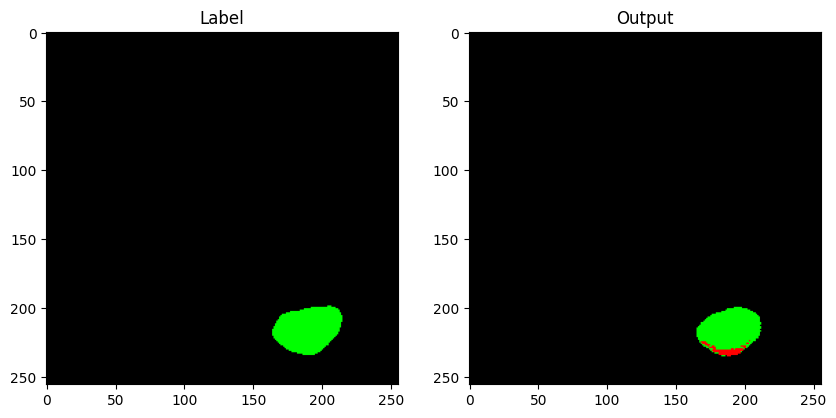

Epoch [29/200] |         Train_loss: 0.0137350868 |         Train_accuracy: 0.3318069854 |         Val_loss: 0.0515465736 |         Val_accuracy: 0.3289429728


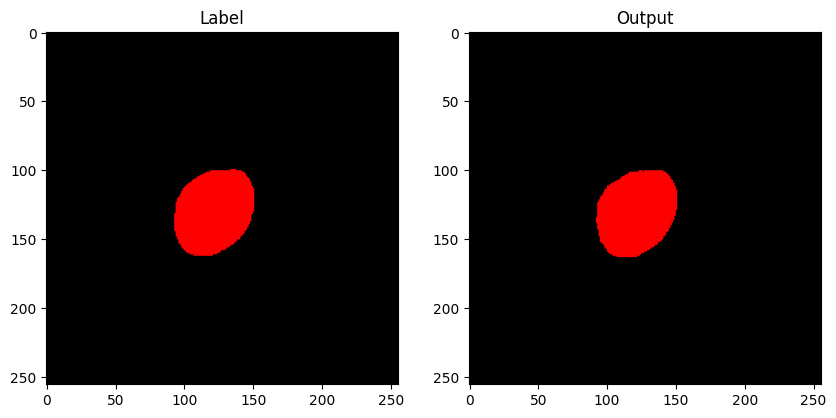

Epoch [30/200] |         Train_loss: 0.0154554804 |         Train_accuracy: 0.3314334333 |         Val_loss: 0.0592508759 |         Val_accuracy: 0.3290457153


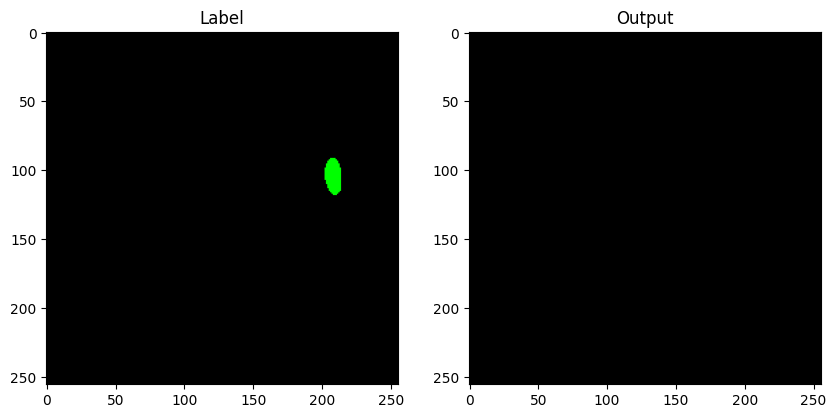

Epoch [31/200] |         Train_loss: 0.0139507281 |         Train_accuracy: 0.3317502509 |         Val_loss: 0.0694519760 |         Val_accuracy: 0.3289787292


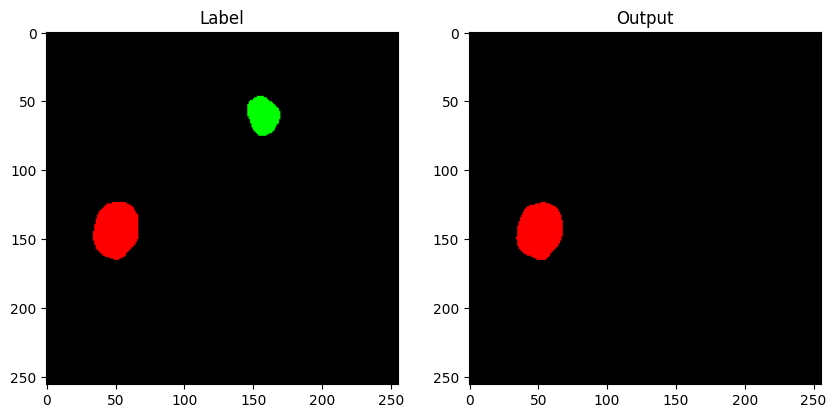

Epoch [32/200] |         Train_loss: 0.0111371237 |         Train_accuracy: 0.3320536239 |         Val_loss: 0.0591419606 |         Val_accuracy: 0.3294960531


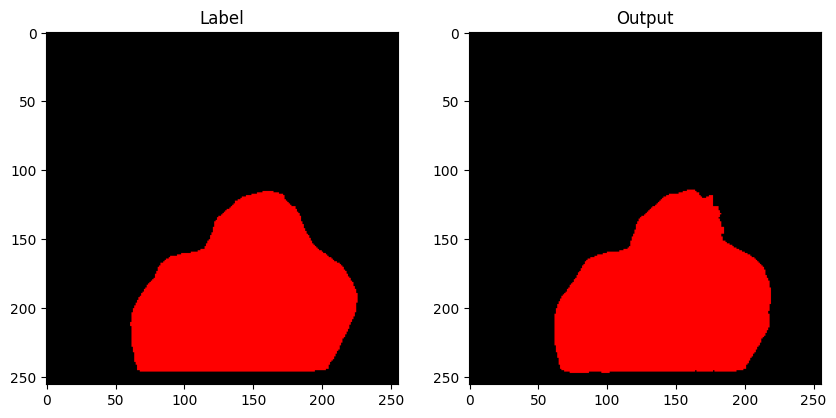

Epoch [33/200] |         Train_loss: 0.0122778266 |         Train_accuracy: 0.3318816347 |         Val_loss: 0.0608031774 |         Val_accuracy: 0.3288907369


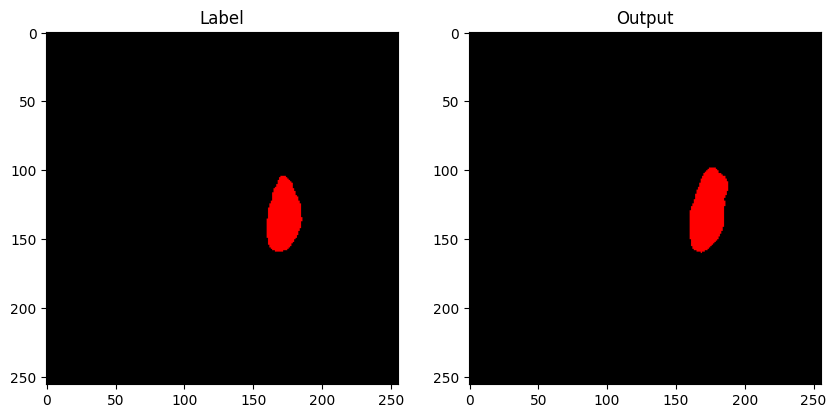

Epoch [34/200] |         Train_loss: 0.0106468369 |         Train_accuracy: 0.3320796769 |         Val_loss: 0.0639763069 |         Val_accuracy: 0.3282965597


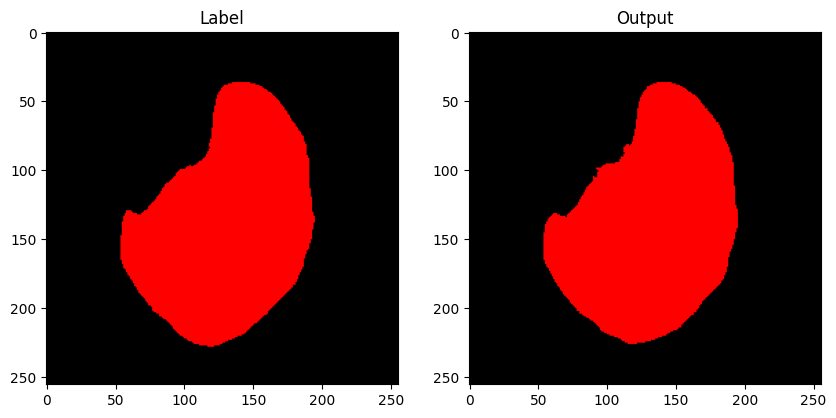

Epoch [35/200] |         Train_loss: 0.0188283647 |         Train_accuracy: 0.3313484531 |         Val_loss: 0.0599404070 |         Val_accuracy: 0.3274432882


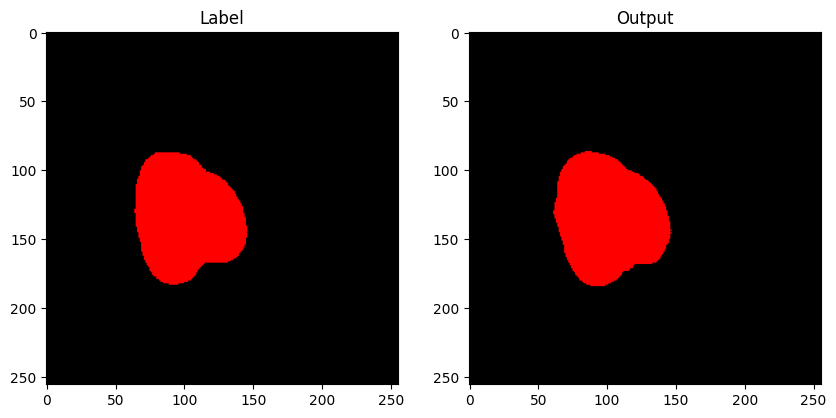

Epoch [36/200] |         Train_loss: 0.0239089249 |         Train_accuracy: 0.3306232368 |         Val_loss: 0.0521943101 |         Val_accuracy: 0.3290959676


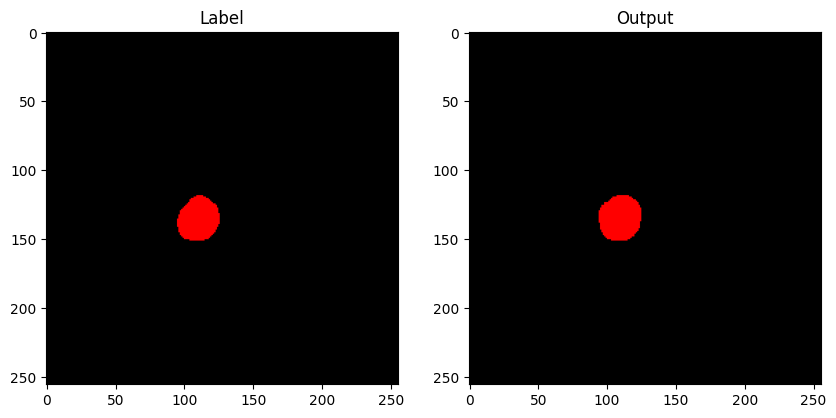

Epoch [37/200] |         Train_loss: 0.0179951059 |         Train_accuracy: 0.3313068192 |         Val_loss: 0.0554721466 |         Val_accuracy: 0.3291935221


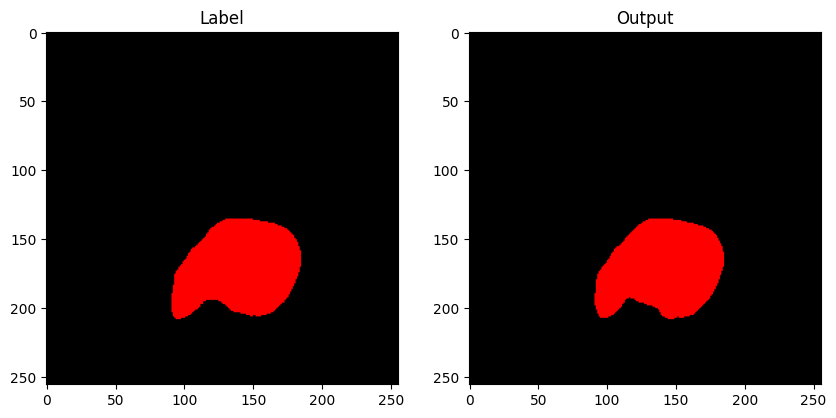

Epoch [38/200] |         Train_loss: 0.0146717226 |         Train_accuracy: 0.3316396530 |         Val_loss: 0.0611160138 |         Val_accuracy: 0.3288492330


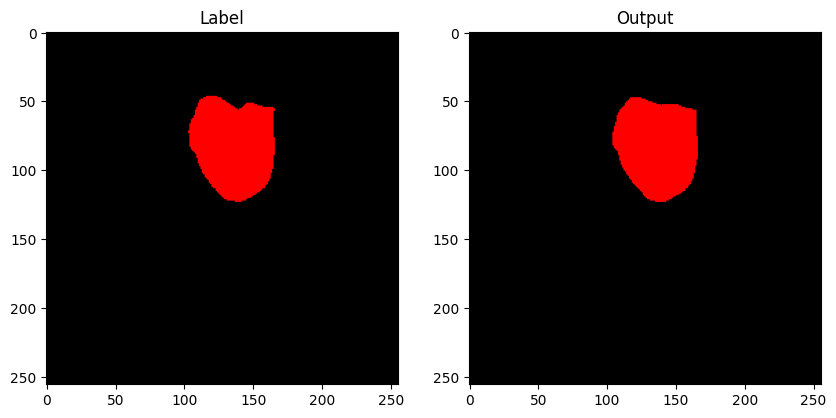

Epoch [39/200] |         Train_loss: 0.0144814391 |         Train_accuracy: 0.3316247389 |         Val_loss: 0.0561959613 |         Val_accuracy: 0.3291153463


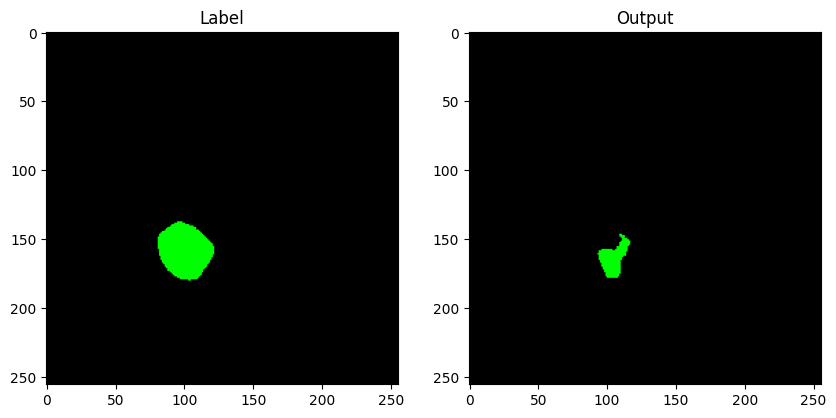

Epoch [40/200] |         Train_loss: 0.0103569713 |         Train_accuracy: 0.3321643010 |         Val_loss: 0.0554127198 |         Val_accuracy: 0.3291697184


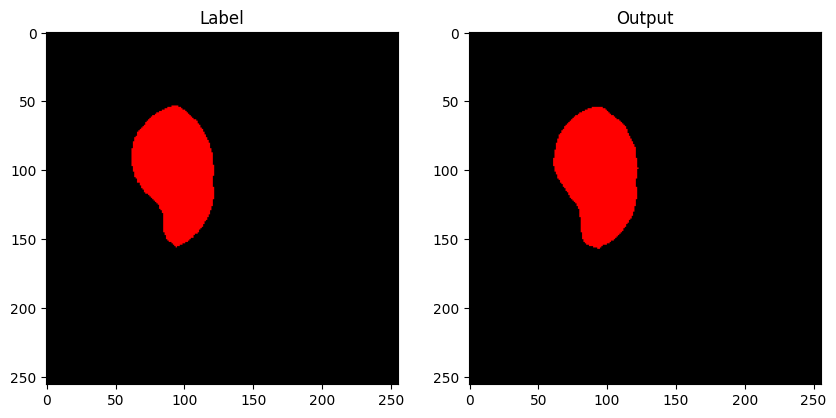

Epoch [41/200] |         Train_loss: 0.0087479595 |         Train_accuracy: 0.3322954418 |         Val_loss: 0.0706599201 |         Val_accuracy: 0.3290130615


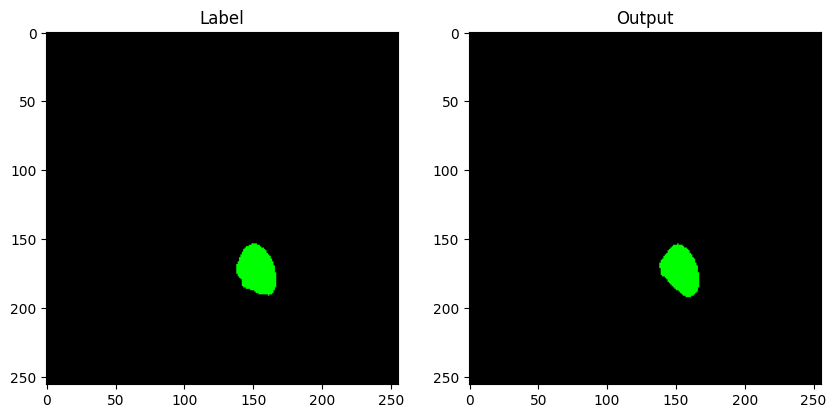

Epoch [42/200] |         Train_loss: 0.0088512916 |         Train_accuracy: 0.3322603240 |         Val_loss: 0.0514831453 |         Val_accuracy: 0.3296962992


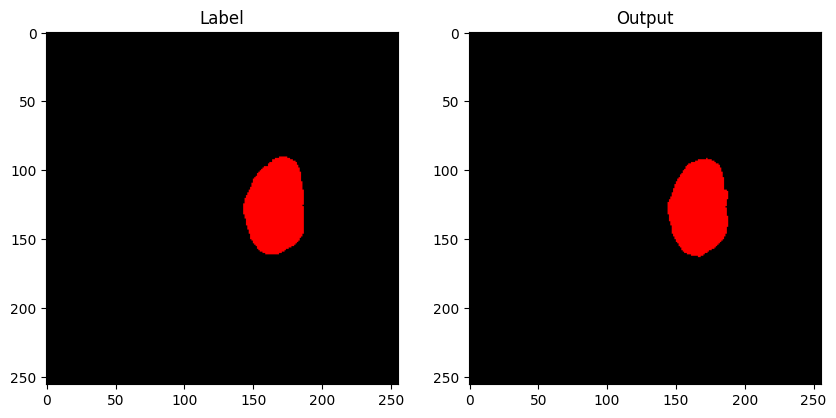

Epoch [43/200] |         Train_loss: 0.0090405073 |         Train_accuracy: 0.3322389617 |         Val_loss: 0.0530757029 |         Val_accuracy: 0.3295621236


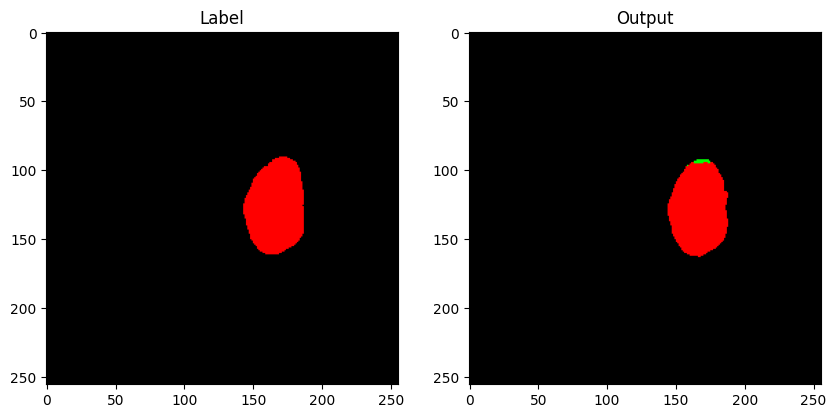

Epoch [44/200] |         Train_loss: 0.0079220742 |         Train_accuracy: 0.3323692830 |         Val_loss: 0.0547510555 |         Val_accuracy: 0.3295551554


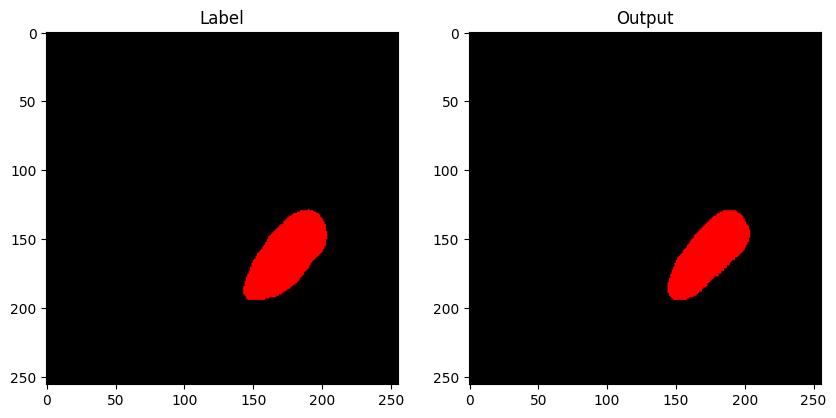

Epoch [45/200] |         Train_loss: 0.0068914127 |         Train_accuracy: 0.3324636502 |         Val_loss: 0.0578760411 |         Val_accuracy: 0.3295313517


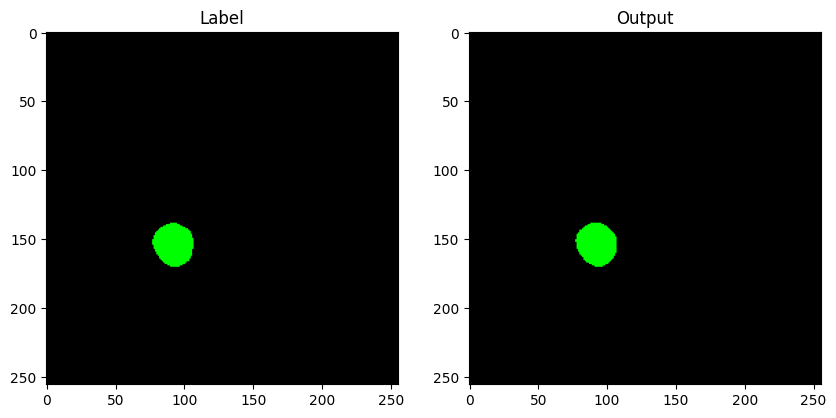

Epoch [46/200] |         Train_loss: 0.0070950938 |         Train_accuracy: 0.3324492165 |         Val_loss: 0.0647859073 |         Val_accuracy: 0.3293185425


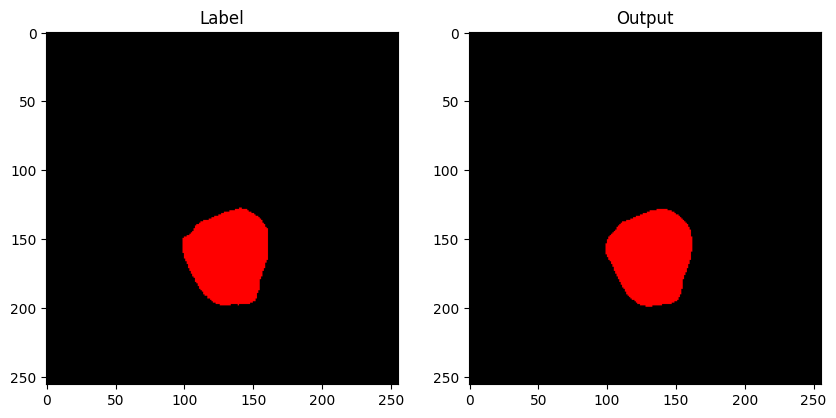

Epoch [47/200] |         Train_loss: 0.0085009422 |         Train_accuracy: 0.3323091634 |         Val_loss: 0.0645304352 |         Val_accuracy: 0.3291996257


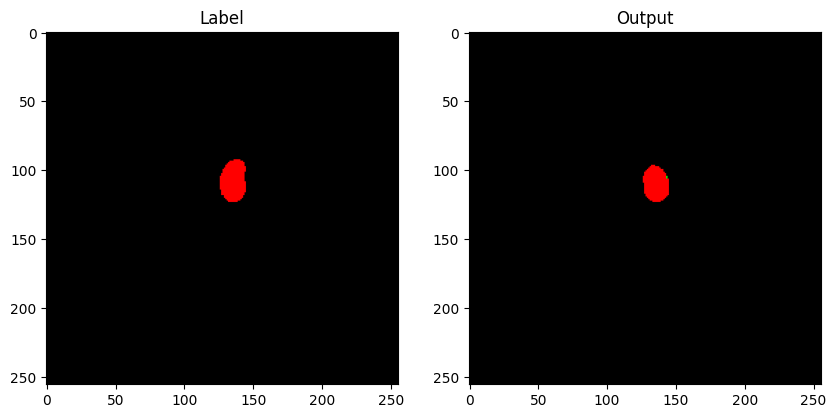

Epoch [48/200] |         Train_loss: 0.0091479770 |         Train_accuracy: 0.3321933775 |         Val_loss: 0.0689343013 |         Val_accuracy: 0.3290813700


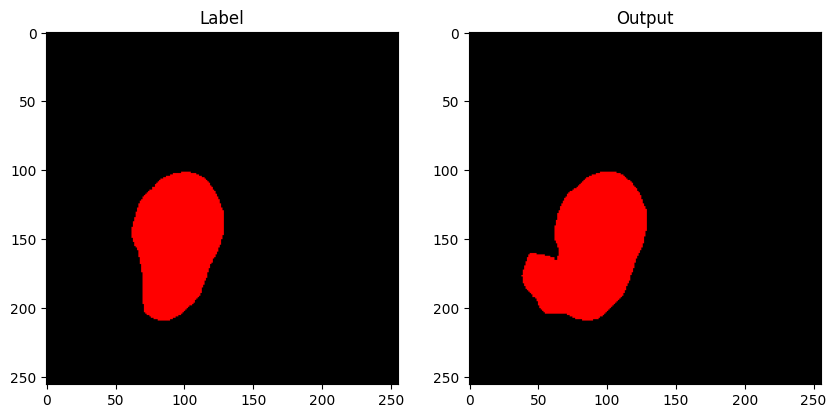

Epoch [49/200] |         Train_loss: 0.0093923494 |         Train_accuracy: 0.3322066583 |         Val_loss: 0.0574425509 |         Val_accuracy: 0.3294726562


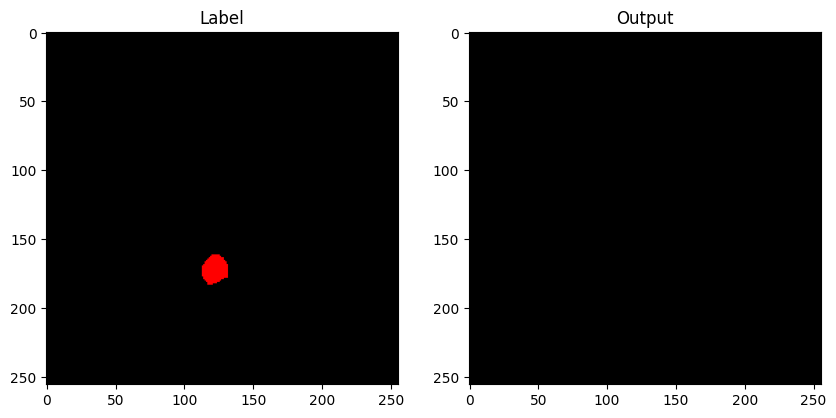

Epoch [50/200] |         Train_loss: 0.0074176937 |         Train_accuracy: 0.3324001510 |         Val_loss: 0.0741500378 |         Val_accuracy: 0.3296708171


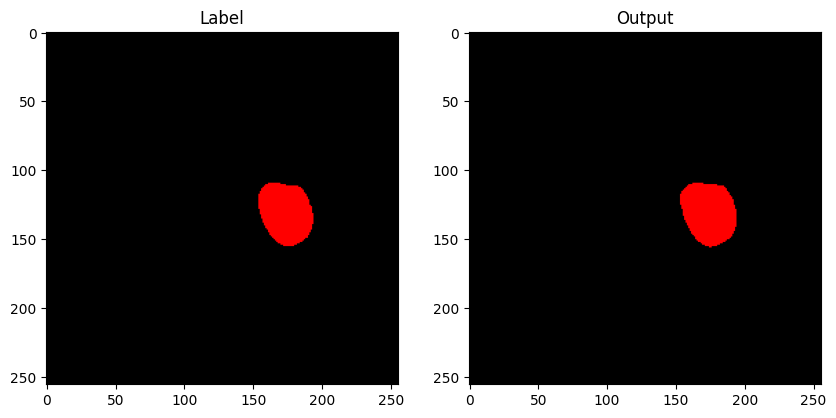

Epoch [51/200] |         Train_loss: 0.0071754301 |         Train_accuracy: 0.3324465999 |         Val_loss: 0.0583157537 |         Val_accuracy: 0.3295841471


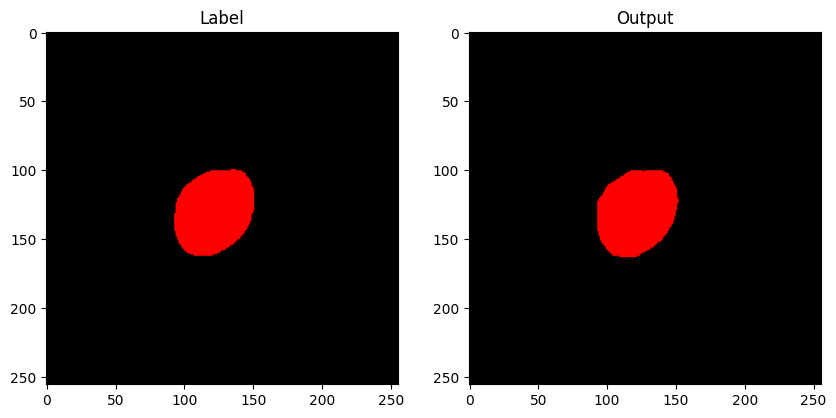

Epoch [52/200] |         Train_loss: 0.0060661593 |         Train_accuracy: 0.3325528406 |         Val_loss: 0.0584804022 |         Val_accuracy: 0.3297179667


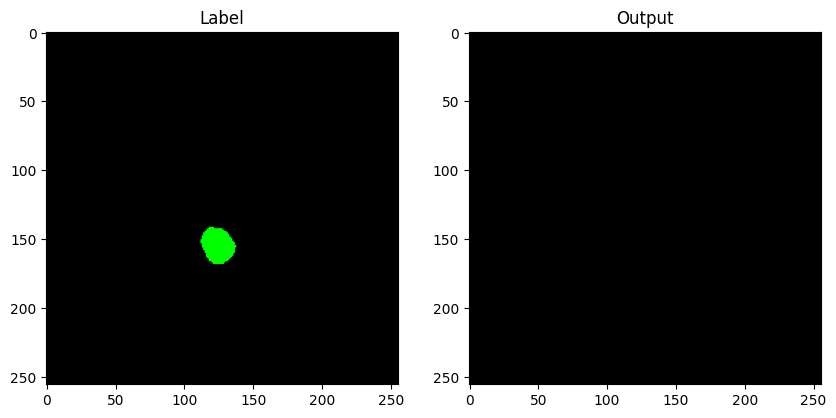

Epoch [53/200] |         Train_loss: 0.0064704361 |         Train_accuracy: 0.3325241428 |         Val_loss: 0.0562987748 |         Val_accuracy: 0.3293957011


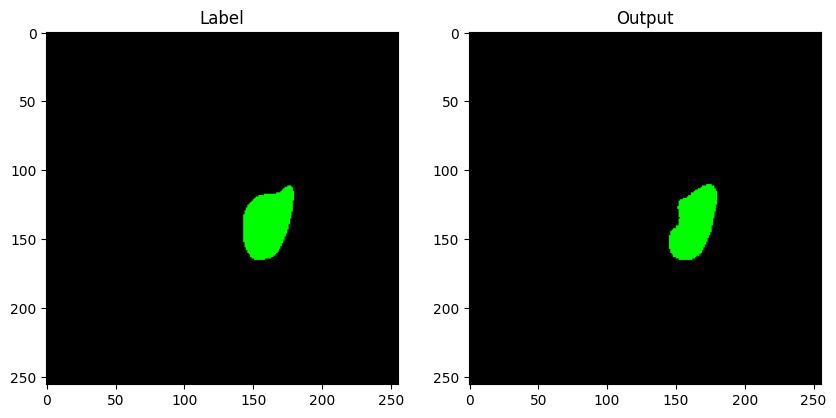

Epoch [54/200] |         Train_loss: 0.0063412382 |         Train_accuracy: 0.3325184688 |         Val_loss: 0.0622606858 |         Val_accuracy: 0.3292689006


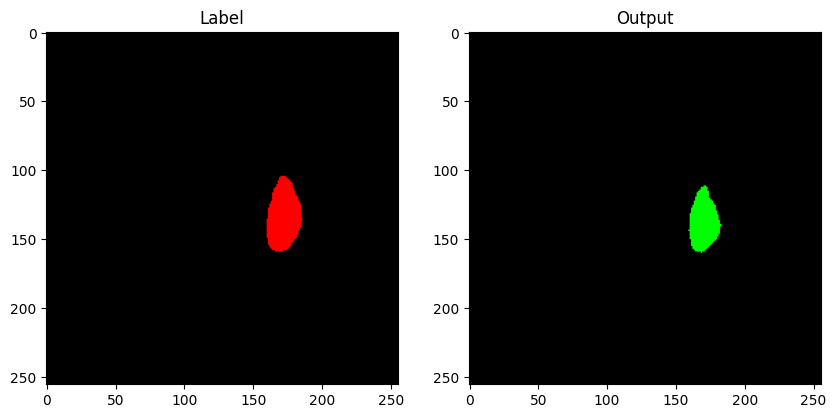

Epoch [55/200] |         Train_loss: 0.0059191520 |         Train_accuracy: 0.3325712133 |         Val_loss: 0.0704985730 |         Val_accuracy: 0.3293735758


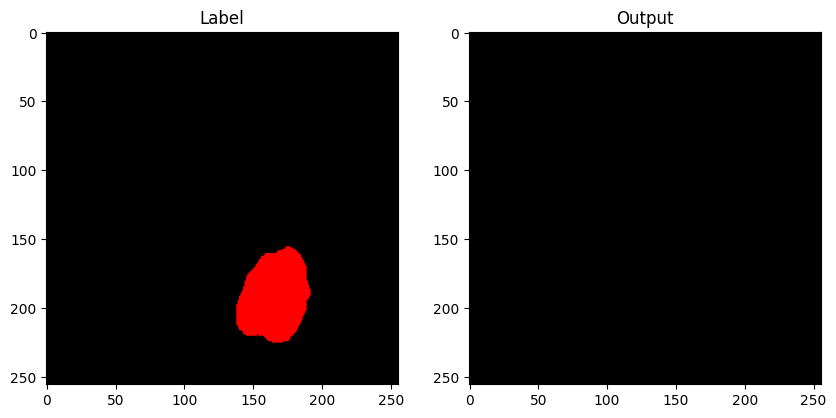

Epoch [56/200] |         Train_loss: 0.0090562282 |         Train_accuracy: 0.3322363507 |         Val_loss: 0.0750451016 |         Val_accuracy: 0.3290252686


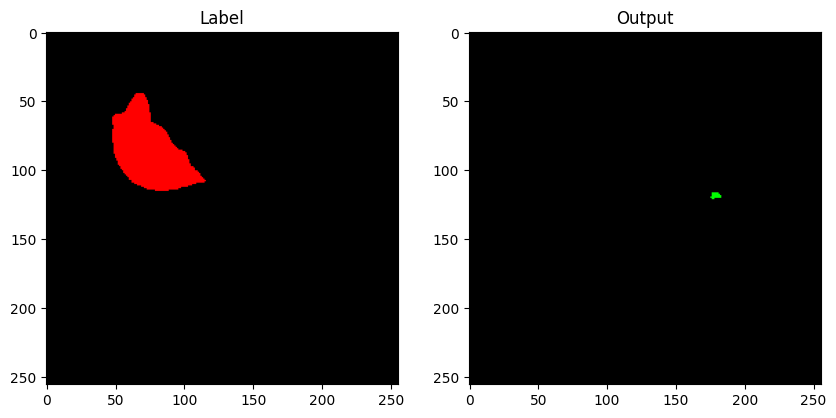

Epoch [57/200] |         Train_loss: 0.0088238688 |         Train_accuracy: 0.3322449974 |         Val_loss: 0.0591508525 |         Val_accuracy: 0.3286364237


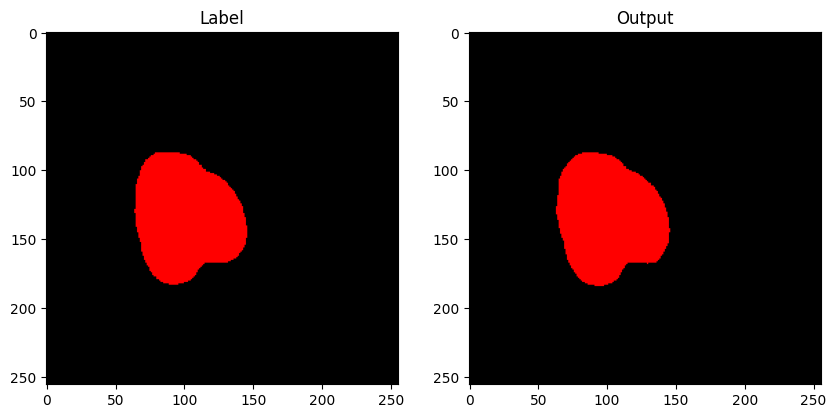

Epoch [58/200] |         Train_loss: 0.0108047968 |         Train_accuracy: 0.3320436718 |         Val_loss: 0.0622342770 |         Val_accuracy: 0.3292417399


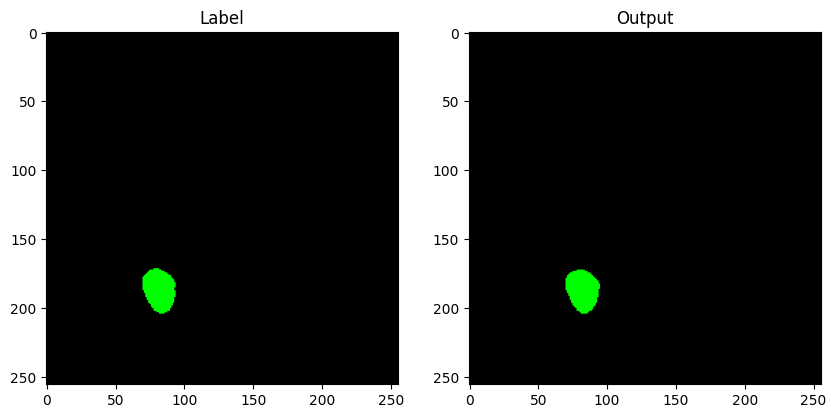

Epoch [59/200] |         Train_loss: 0.0093778278 |         Train_accuracy: 0.3322260934 |         Val_loss: 0.0718681903 |         Val_accuracy: 0.3287423197


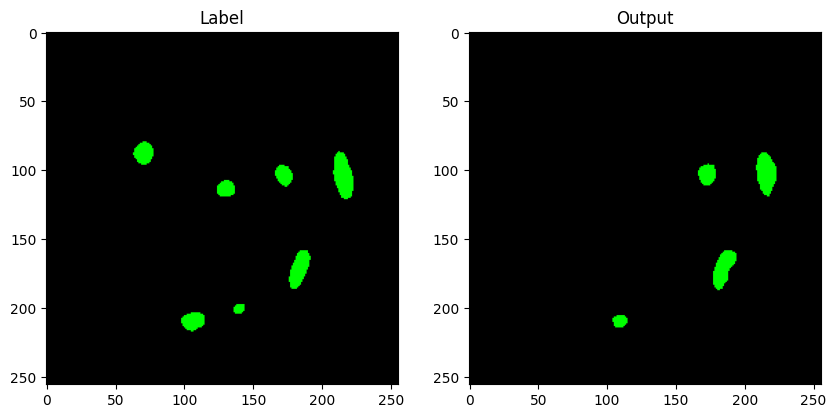

Epoch [60/200] |         Train_loss: 0.0276576795 |         Train_accuracy: 0.3303564905 |         Val_loss: 0.0749916177 |         Val_accuracy: 0.3281642151


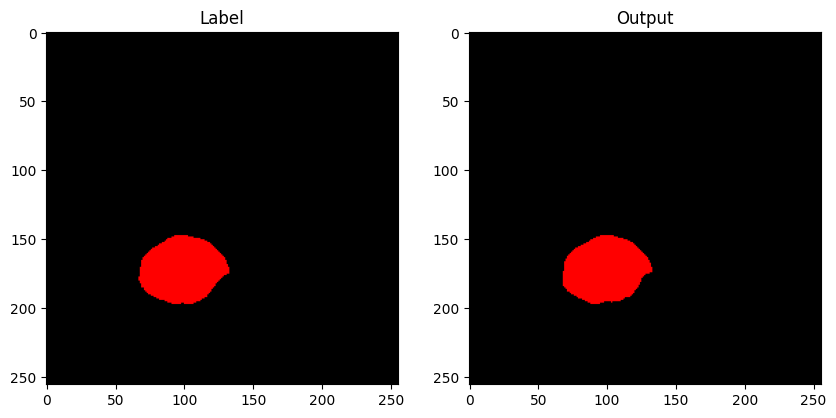

Epoch [61/200] |         Train_loss: 0.0171660790 |         Train_accuracy: 0.3313708327 |         Val_loss: 0.0584181948 |         Val_accuracy: 0.3290569560


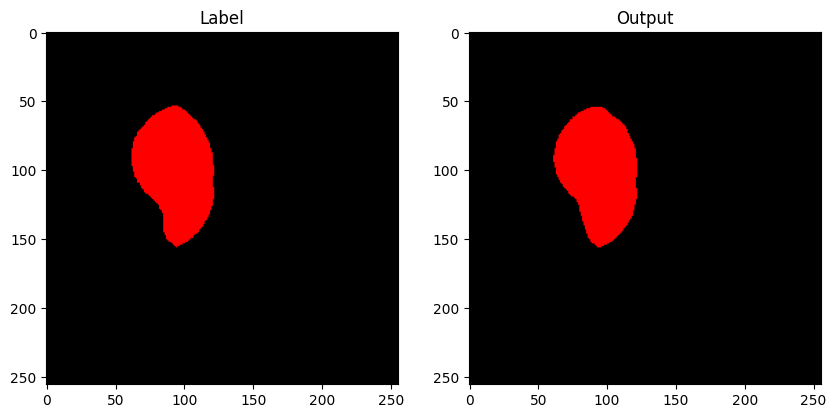

Epoch [62/200] |         Train_loss: 0.0125061257 |         Train_accuracy: 0.3318343212 |         Val_loss: 0.0568062726 |         Val_accuracy: 0.3293647766


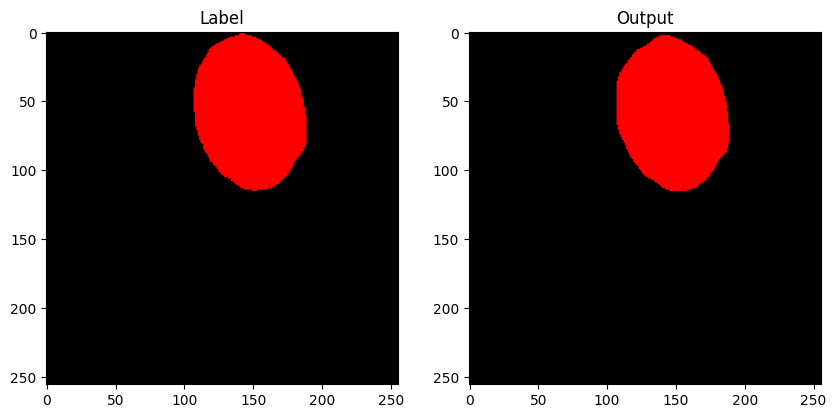

Epoch [63/200] |         Train_loss: 0.0086665053 |         Train_accuracy: 0.3322455908 |         Val_loss: 0.0626176490 |         Val_accuracy: 0.3289729818


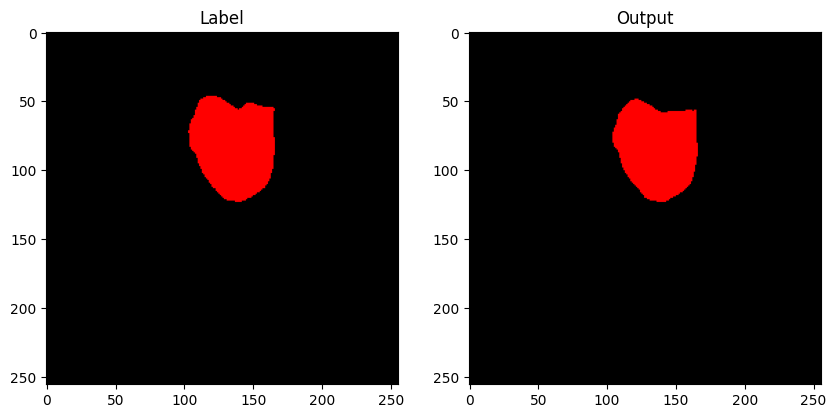

Epoch [64/200] |         Train_loss: 0.0080703717 |         Train_accuracy: 0.3323152274 |         Val_loss: 0.0591121388 |         Val_accuracy: 0.3292450460


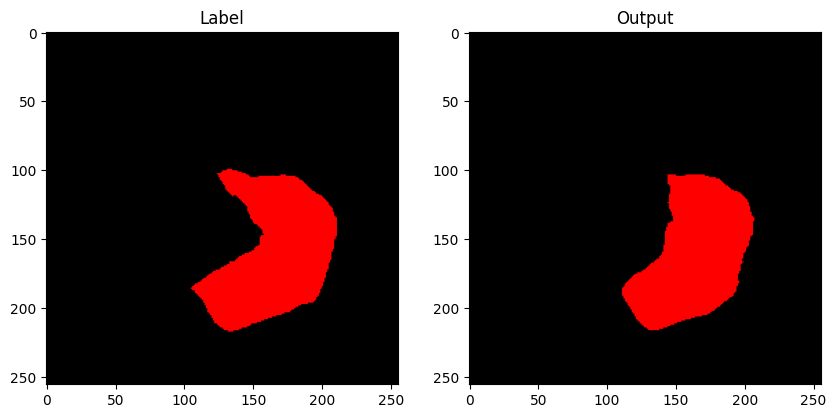

Epoch [65/200] |         Train_loss: 0.0071784039 |         Train_accuracy: 0.3324348506 |         Val_loss: 0.0758380125 |         Val_accuracy: 0.3293416850


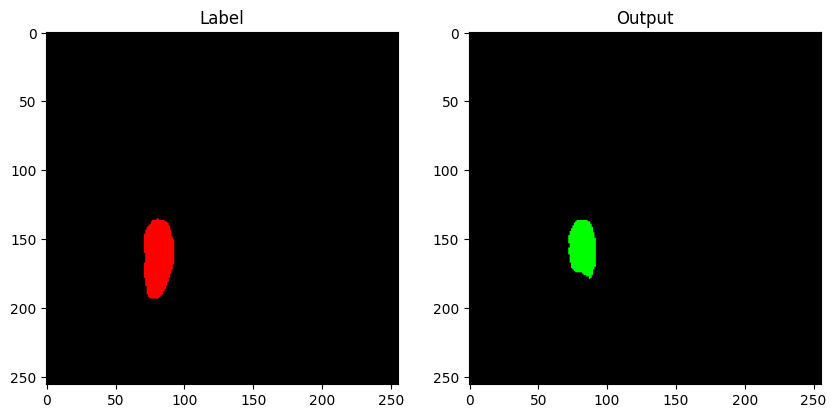

Epoch [66/200] |         Train_loss: 0.0072941161 |         Train_accuracy: 0.3324403777 |         Val_loss: 0.0622593065 |         Val_accuracy: 0.3294658915


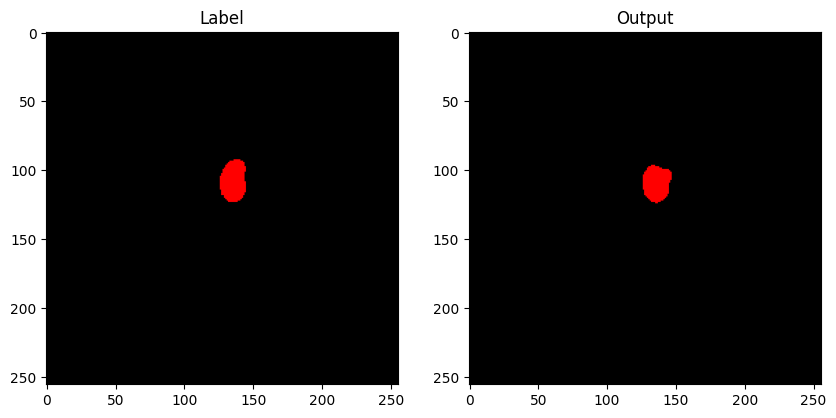

Epoch [67/200] |         Train_loss: 0.0066964586 |         Train_accuracy: 0.3325059057 |         Val_loss: 0.0645647346 |         Val_accuracy: 0.3292860413


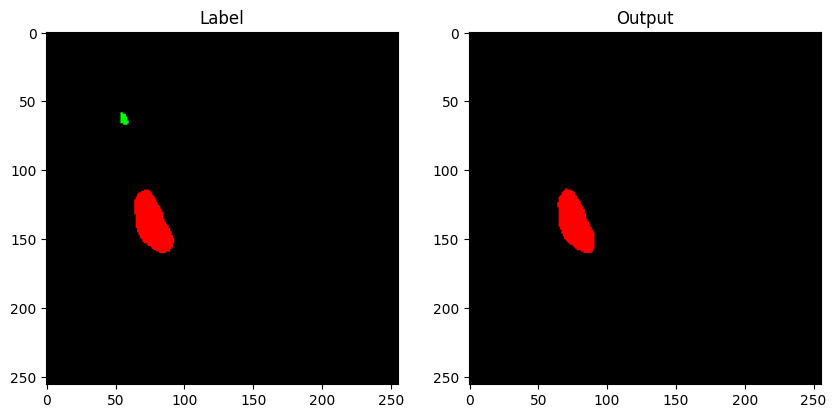

Epoch [68/200] |         Train_loss: 0.0058214271 |         Train_accuracy: 0.3325785997 |         Val_loss: 0.0638905702 |         Val_accuracy: 0.3294461568


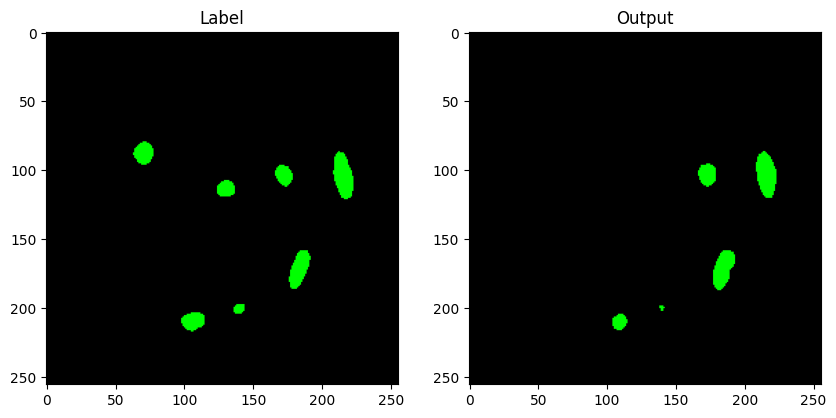

Epoch [69/200] |         Train_loss: 0.0056348471 |         Train_accuracy: 0.3325904564 |         Val_loss: 0.0645553950 |         Val_accuracy: 0.3295510864


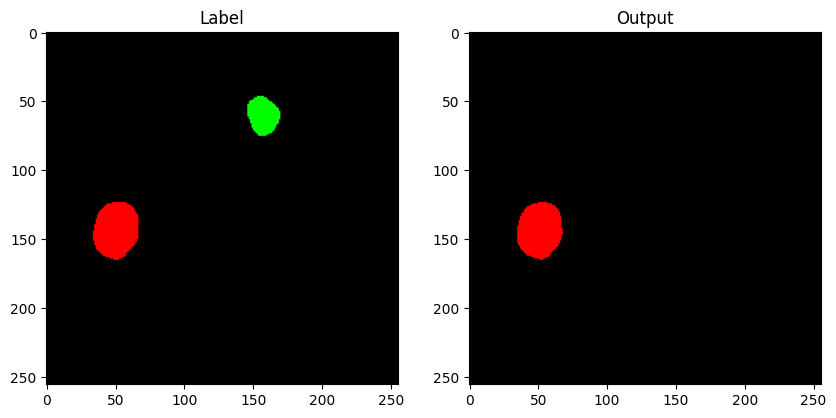

Epoch [70/200] |         Train_loss: 0.0053538670 |         Train_accuracy: 0.3326279308 |         Val_loss: 0.0629322164 |         Val_accuracy: 0.3295582581


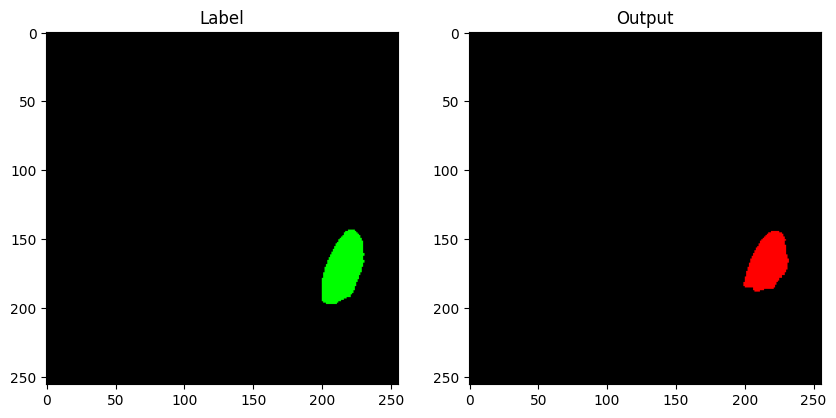

Epoch [71/200] |         Train_loss: 0.0060920413 |         Train_accuracy: 0.3325199155 |         Val_loss: 0.0693304615 |         Val_accuracy: 0.3293825277


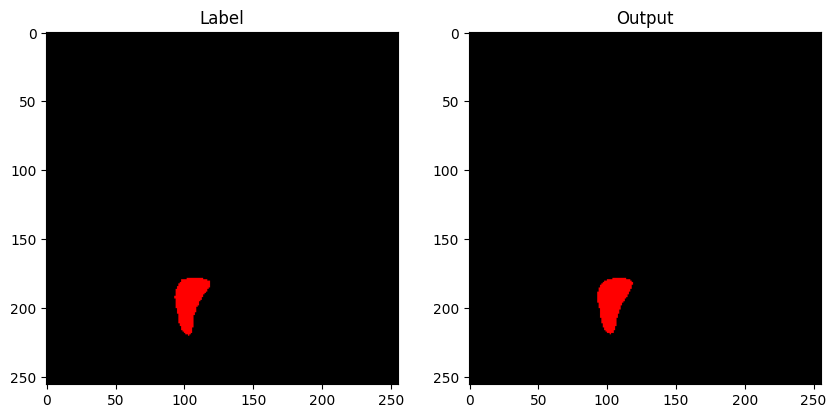

Epoch [72/200] |         Train_loss: 0.0050328263 |         Train_accuracy: 0.3326575611 |         Val_loss: 0.0702003971 |         Val_accuracy: 0.3292186991


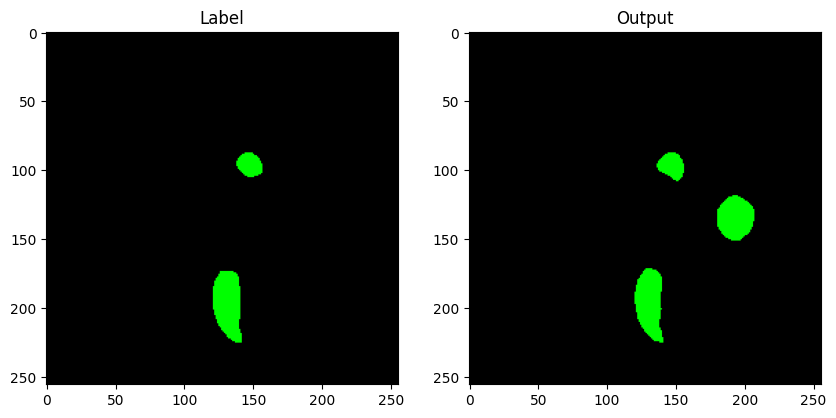

Epoch [73/200] |         Train_loss: 0.0052831162 |         Train_accuracy: 0.3326221494 |         Val_loss: 0.0698601447 |         Val_accuracy: 0.3293523153


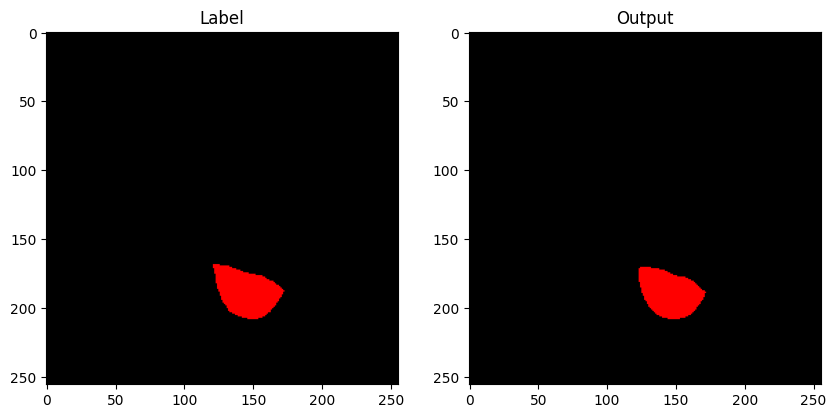

Epoch [74/200] |         Train_loss: 0.0049524915 |         Train_accuracy: 0.3326682479 |         Val_loss: 0.0718618982 |         Val_accuracy: 0.3292442830


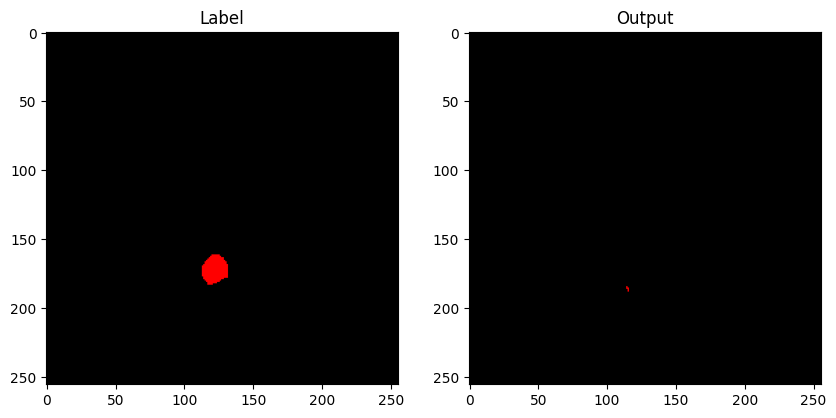

Epoch [75/200] |         Train_loss: 0.0048794397 |         Train_accuracy: 0.3326829303 |         Val_loss: 0.0643709225 |         Val_accuracy: 0.3295965576


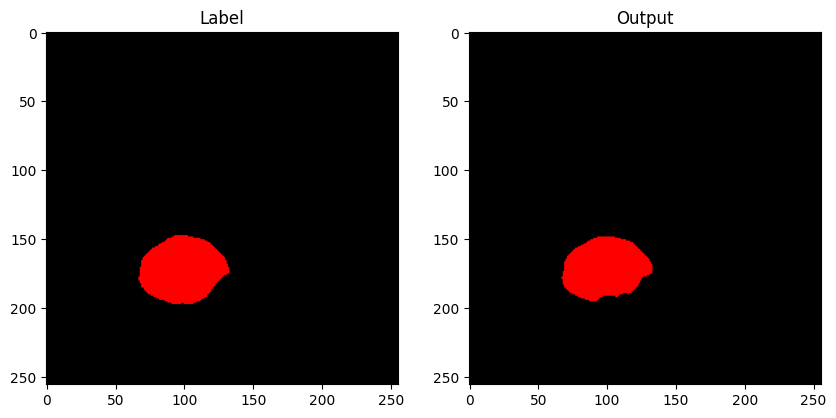

Epoch [76/200] |         Train_loss: 0.0066394552 |         Train_accuracy: 0.3325232160 |         Val_loss: 0.0680844436 |         Val_accuracy: 0.3294944255


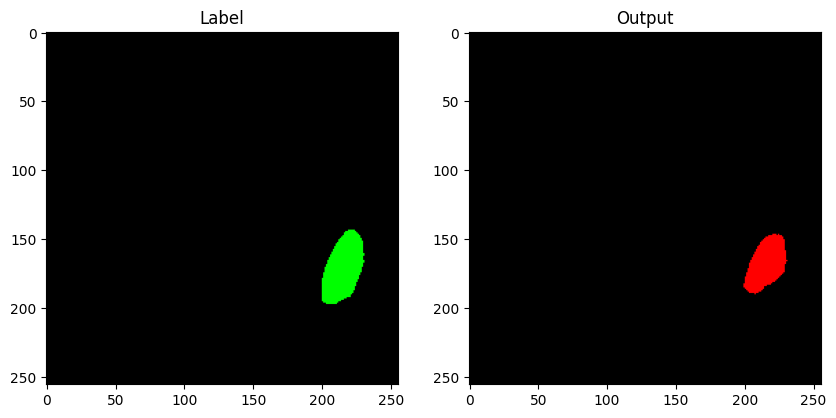

Epoch [77/200] |         Train_loss: 0.0056744375 |         Train_accuracy: 0.3325943050 |         Val_loss: 0.0699685454 |         Val_accuracy: 0.3295475260


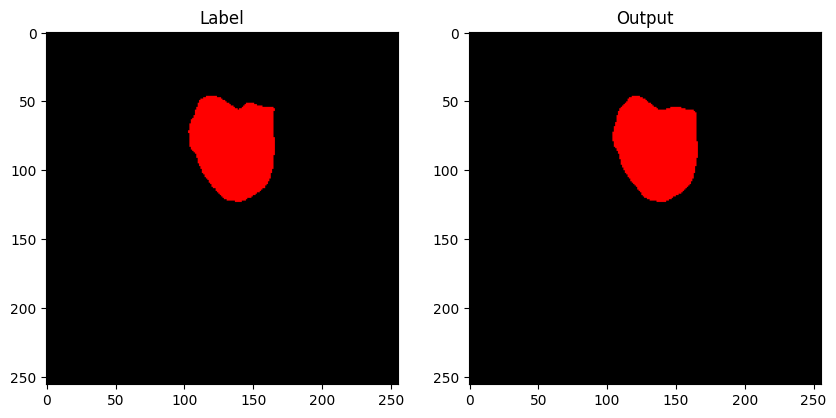

Epoch [78/200] |         Train_loss: 0.0108021720 |         Train_accuracy: 0.3320492497 |         Val_loss: 0.0708708052 |         Val_accuracy: 0.3289340210


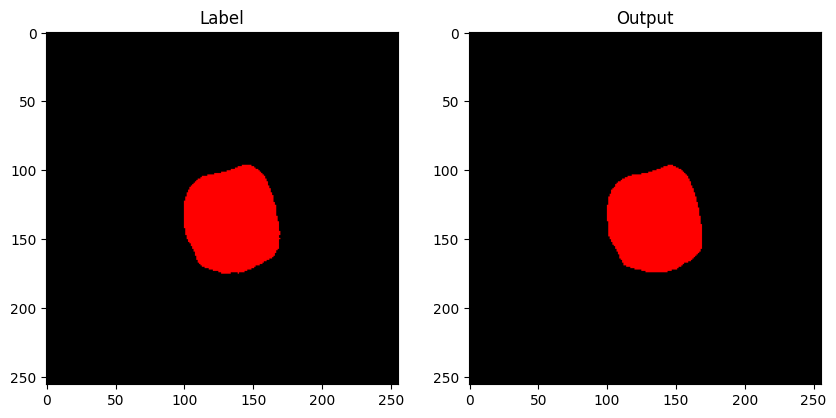

Epoch [79/200] |         Train_loss: 0.0070651345 |         Train_accuracy: 0.3324563994 |         Val_loss: 0.0738559091 |         Val_accuracy: 0.3292309062


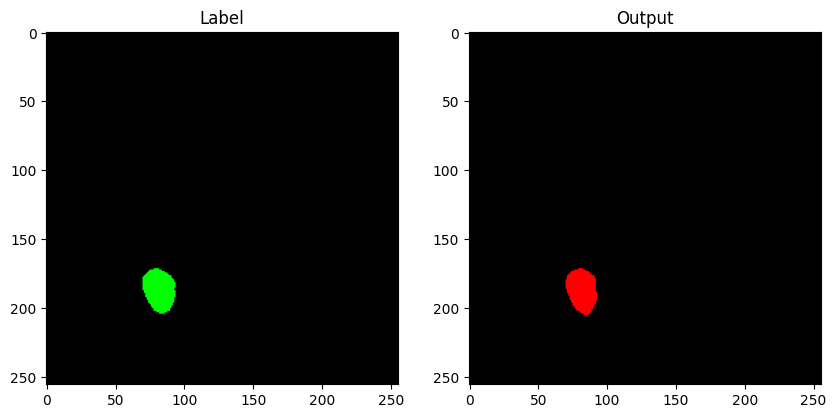

Epoch [80/200] |         Train_loss: 0.0130583945 |         Train_accuracy: 0.3318429452 |         Val_loss: 0.0590571578 |         Val_accuracy: 0.3283220927


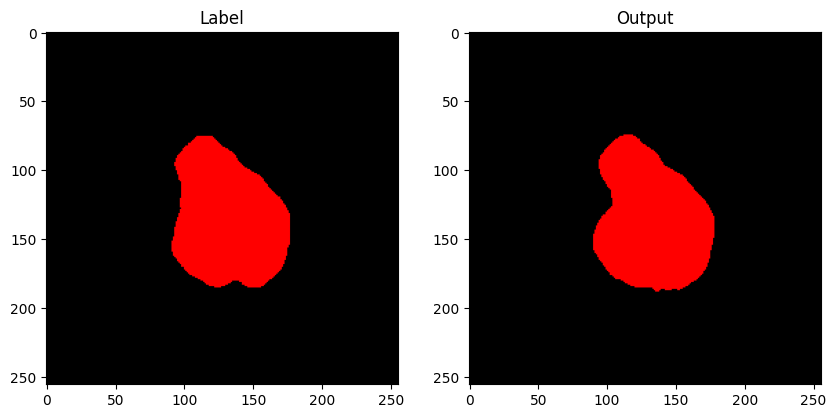

Epoch [81/200] |         Train_loss: 0.0102400271 |         Train_accuracy: 0.3320675942 |         Val_loss: 0.0699475862 |         Val_accuracy: 0.3291202799


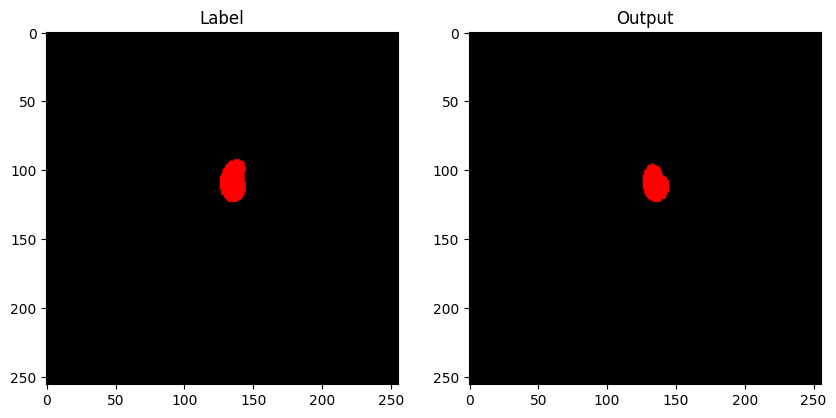

Epoch [82/200] |         Train_loss: 0.0117330777 |         Train_accuracy: 0.3319342324 |         Val_loss: 0.0577631518 |         Val_accuracy: 0.3295000203


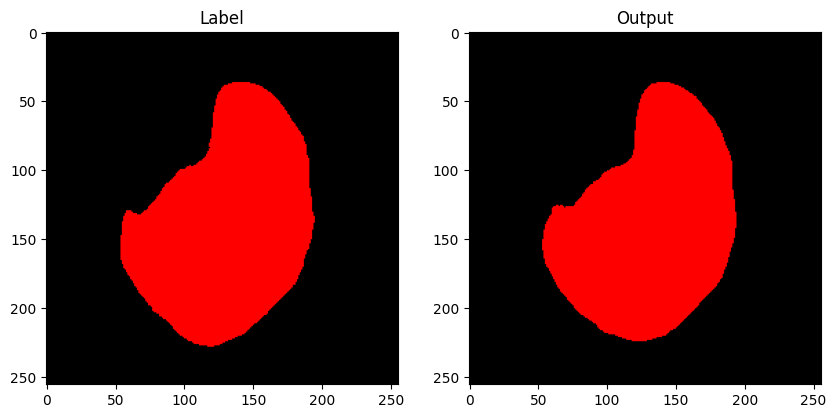

Epoch [83/200] |         Train_loss: 0.0073256189 |         Train_accuracy: 0.3324088259 |         Val_loss: 0.0654109730 |         Val_accuracy: 0.3297674561


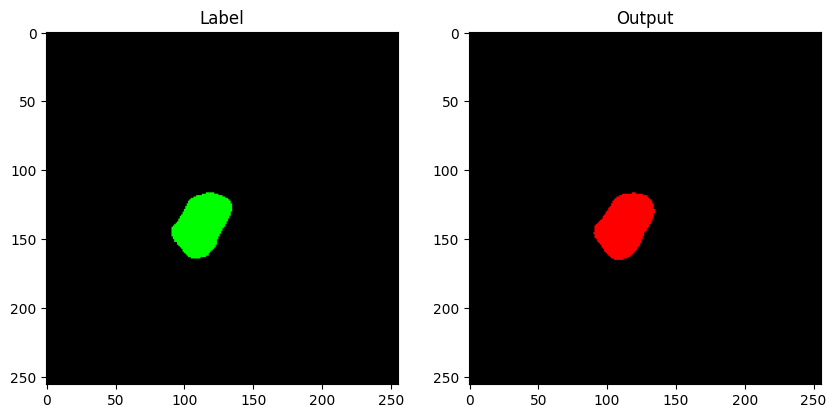

Epoch [84/200] |         Train_loss: 0.0078315240 |         Train_accuracy: 0.3324127423 |         Val_loss: 0.0572349726 |         Val_accuracy: 0.3297467550


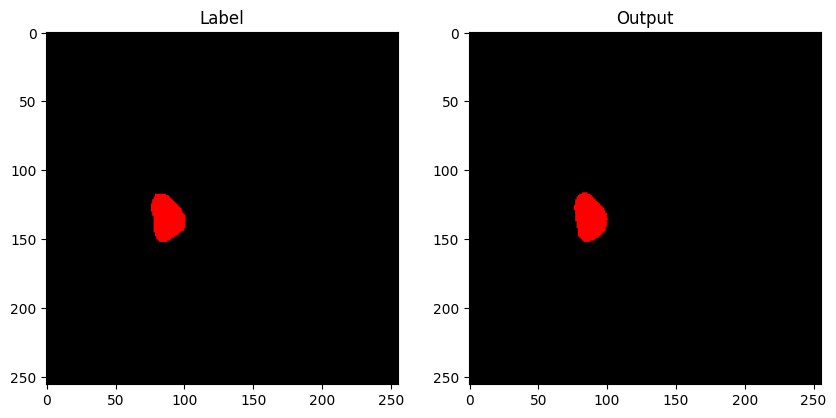

Epoch [85/200] |         Train_loss: 0.0058276342 |         Train_accuracy: 0.3325759323 |         Val_loss: 0.0595720130 |         Val_accuracy: 0.3299351501


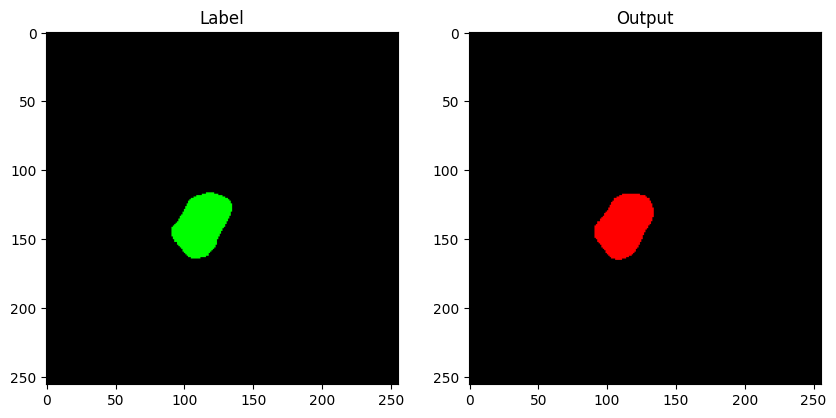

Epoch [86/200] |         Train_loss: 0.0052576826 |         Train_accuracy: 0.3326260941 |         Val_loss: 0.0608289271 |         Val_accuracy: 0.3297340902


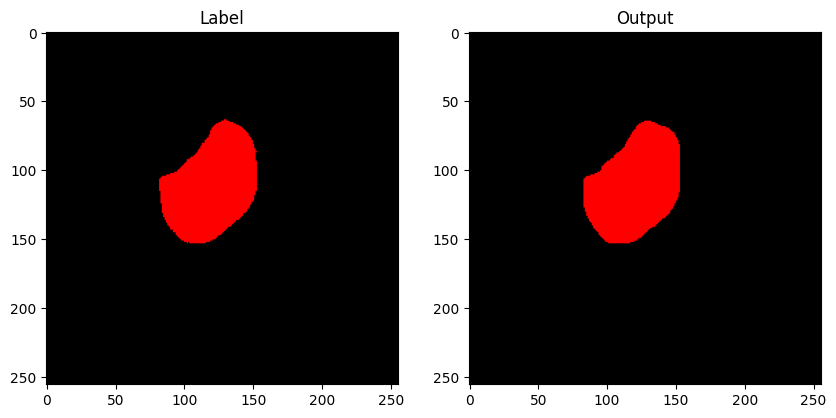

Epoch [87/200] |         Train_loss: 0.0047303877 |         Train_accuracy: 0.3326960811 |         Val_loss: 0.0653122701 |         Val_accuracy: 0.3299107361


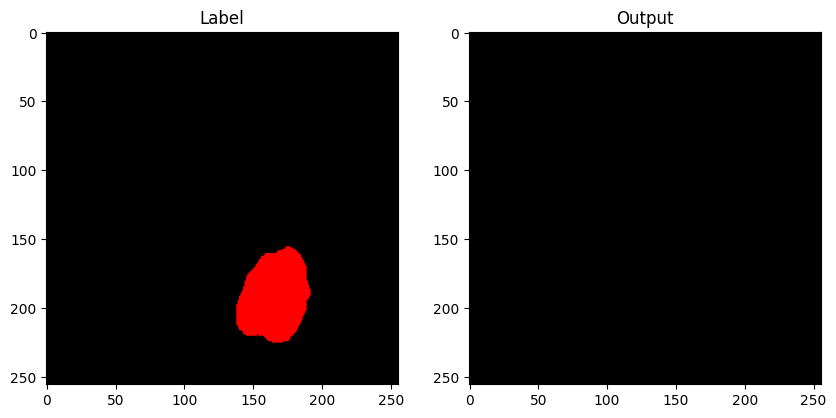

Epoch [88/200] |         Train_loss: 0.0047975437 |         Train_accuracy: 0.3326827720 |         Val_loss: 0.0660751620 |         Val_accuracy: 0.3295368449


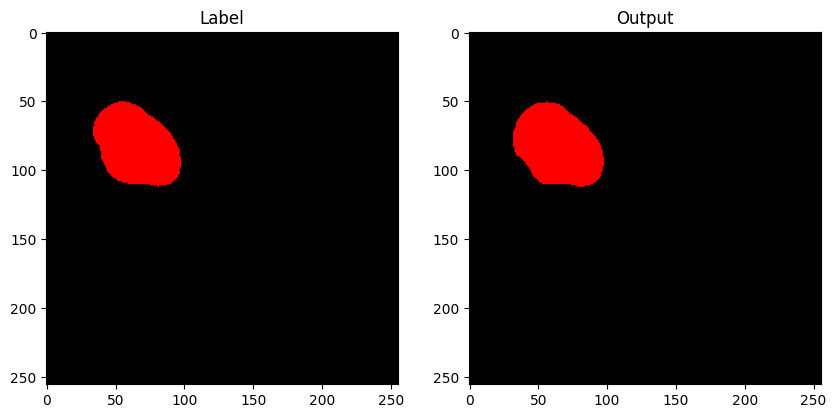

Epoch [89/200] |         Train_loss: 0.0045171485 |         Train_accuracy: 0.3327263613 |         Val_loss: 0.0646822870 |         Val_accuracy: 0.3296362813


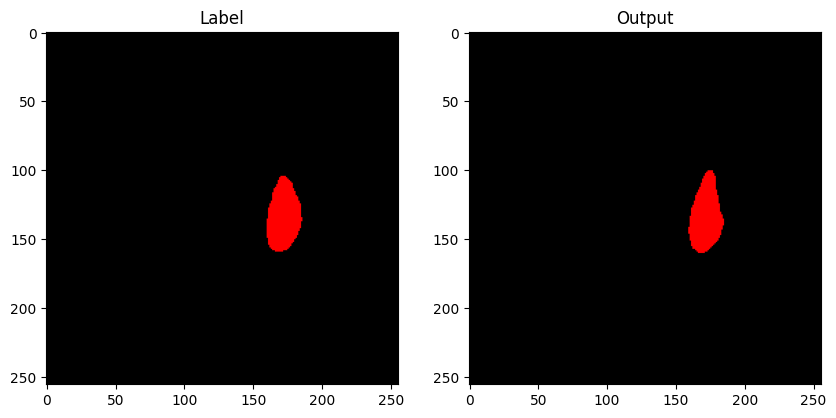

Epoch [90/200] |         Train_loss: 0.0043310561 |         Train_accuracy: 0.3327452822 |         Val_loss: 0.0694638319 |         Val_accuracy: 0.3295985921


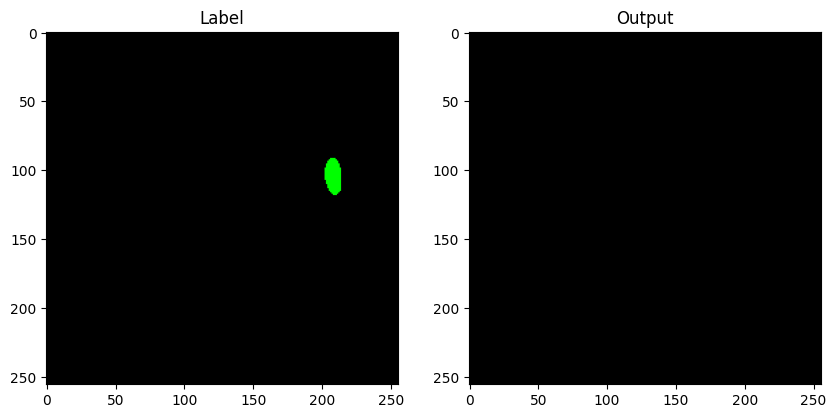

Epoch [91/200] |         Train_loss: 0.0041603480 |         Train_accuracy: 0.3327674866 |         Val_loss: 0.0755271217 |         Val_accuracy: 0.3294855245


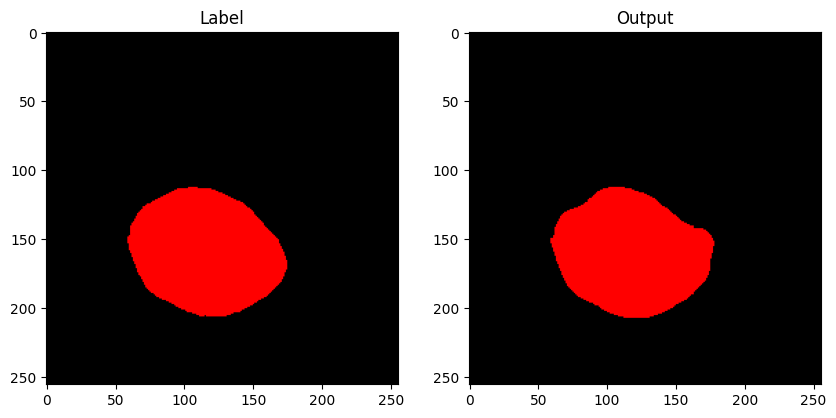

Epoch [92/200] |         Train_loss: 0.0045753484 |         Train_accuracy: 0.3327108821 |         Val_loss: 0.0856728951 |         Val_accuracy: 0.3292624410


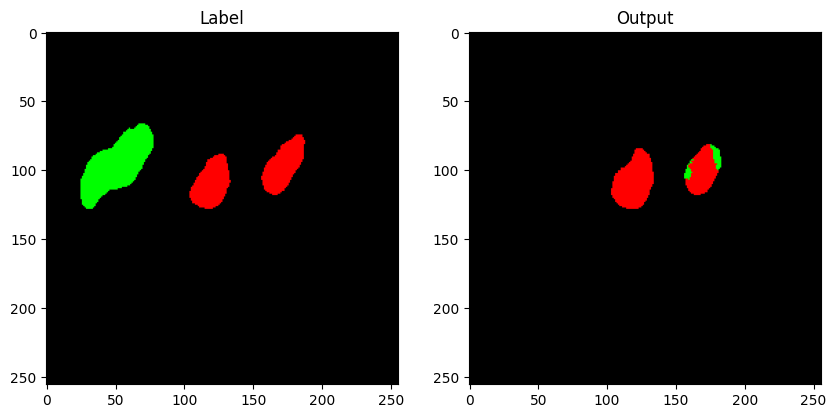

Epoch [93/200] |         Train_loss: 0.0047363499 |         Train_accuracy: 0.3327123006 |         Val_loss: 0.0729467882 |         Val_accuracy: 0.3294480896


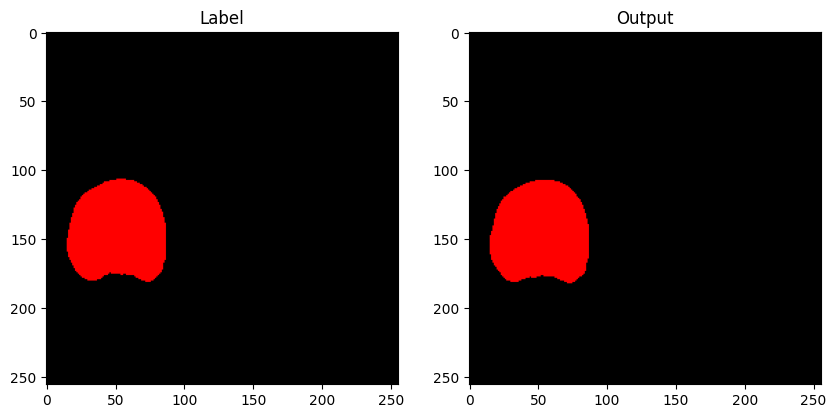

Epoch [94/200] |         Train_loss: 0.0053811160 |         Train_accuracy: 0.3326455180 |         Val_loss: 0.0809935462 |         Val_accuracy: 0.3292778015


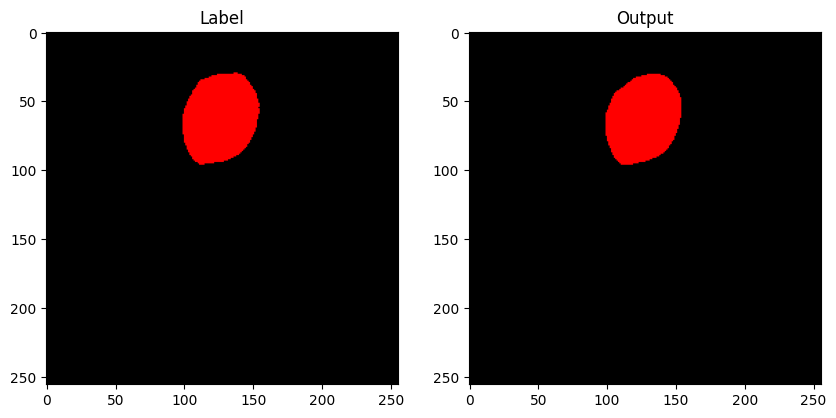

Epoch [95/200] |         Train_loss: 0.0114323535 |         Train_accuracy: 0.3320505608 |         Val_loss: 0.0891094725 |         Val_accuracy: 0.3286297607


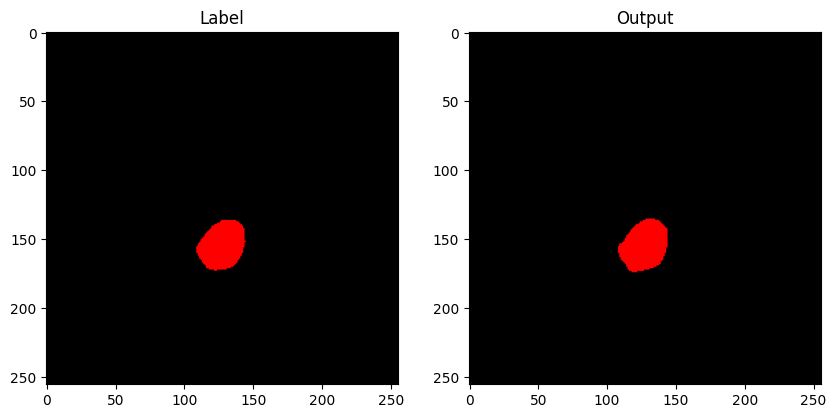

Epoch [96/200] |         Train_loss: 0.0123752016 |         Train_accuracy: 0.3319177529 |         Val_loss: 0.0704320036 |         Val_accuracy: 0.3290442403


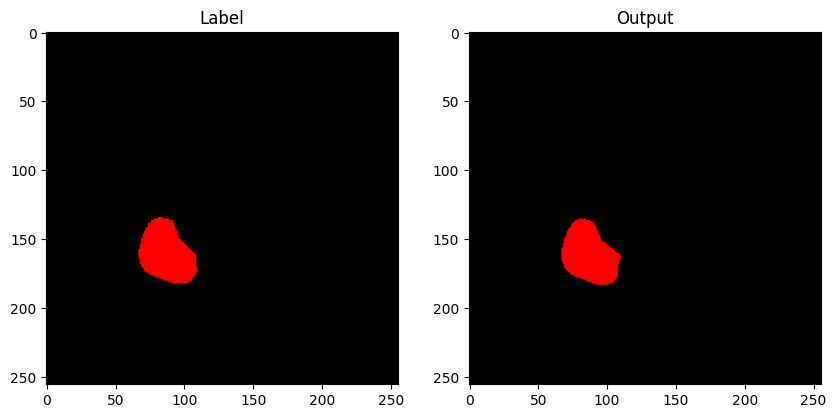

Epoch [97/200] |         Train_loss: 0.0083727750 |         Train_accuracy: 0.3322608157 |         Val_loss: 0.0583281820 |         Val_accuracy: 0.3296206156


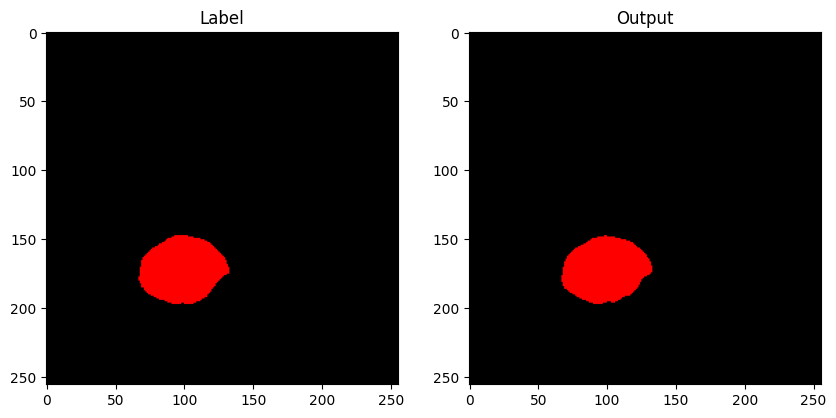

Epoch [98/200] |         Train_loss: 0.0091924326 |         Train_accuracy: 0.3322038891 |         Val_loss: 0.0745066937 |         Val_accuracy: 0.3285780843


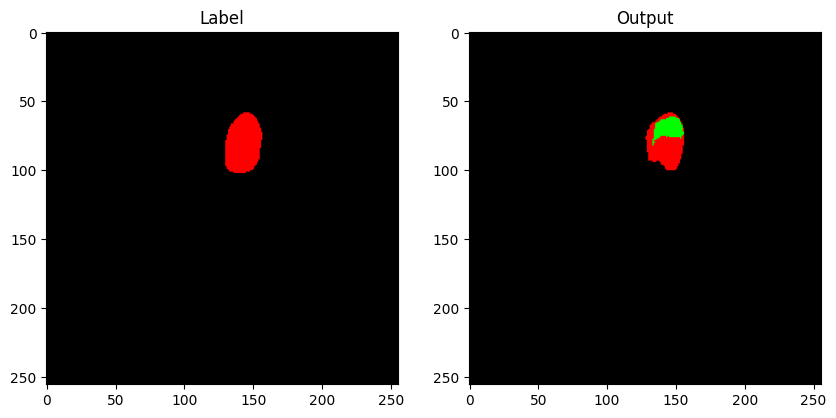

Epoch [99/200] |         Train_loss: 0.0071715823 |         Train_accuracy: 0.3324414062 |         Val_loss: 0.0633003651 |         Val_accuracy: 0.3296560160


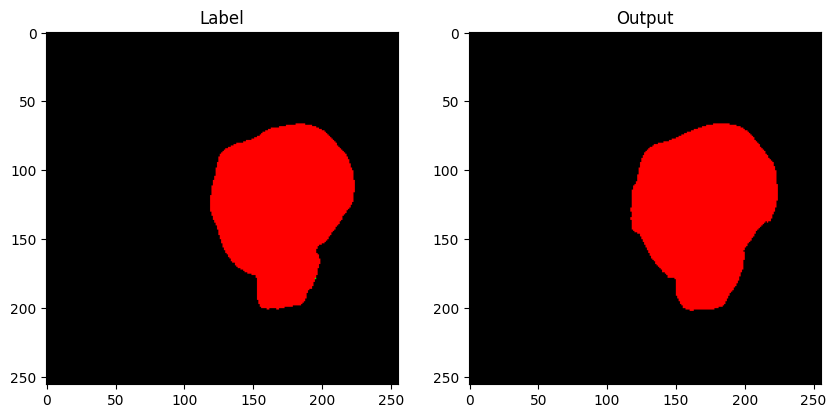

Epoch [100/200] |         Train_loss: 0.0072175689 |         Train_accuracy: 0.3323953191 |         Val_loss: 0.0863276437 |         Val_accuracy: 0.3269864909


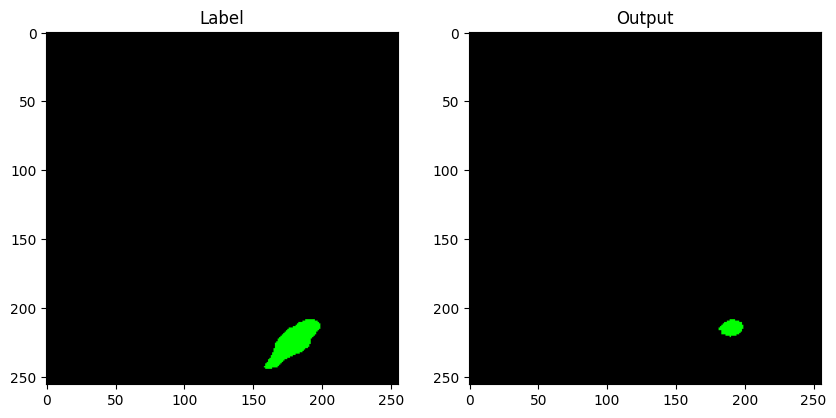

Epoch [101/200] |         Train_loss: 0.0062013856 |         Train_accuracy: 0.3325340214 |         Val_loss: 0.0539846153 |         Val_accuracy: 0.3298723857


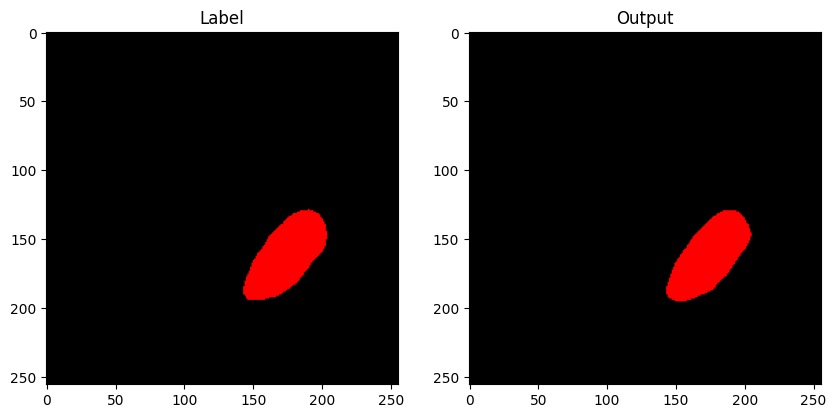

Epoch [102/200] |         Train_loss: 0.0054367284 |         Train_accuracy: 0.3326322033 |         Val_loss: 0.0702890859 |         Val_accuracy: 0.3296853129


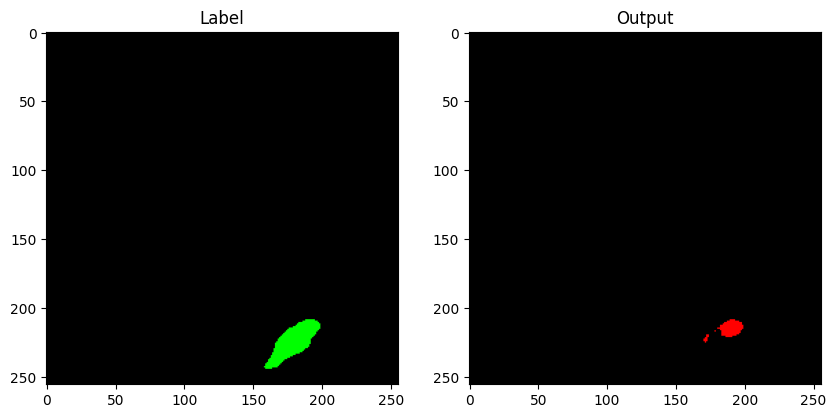

Epoch [103/200] |         Train_loss: 0.0052463284 |         Train_accuracy: 0.3326398948 |         Val_loss: 0.0678855897 |         Val_accuracy: 0.3296697998


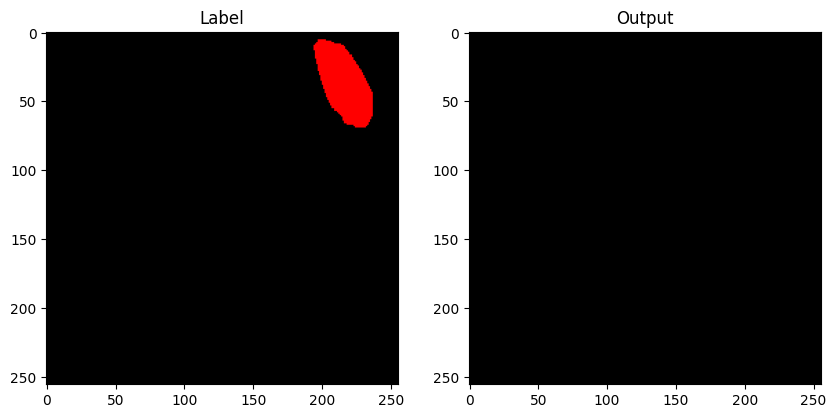

Epoch [104/200] |         Train_loss: 0.0043882141 |         Train_accuracy: 0.3327299895 |         Val_loss: 0.0730265005 |         Val_accuracy: 0.3295721436


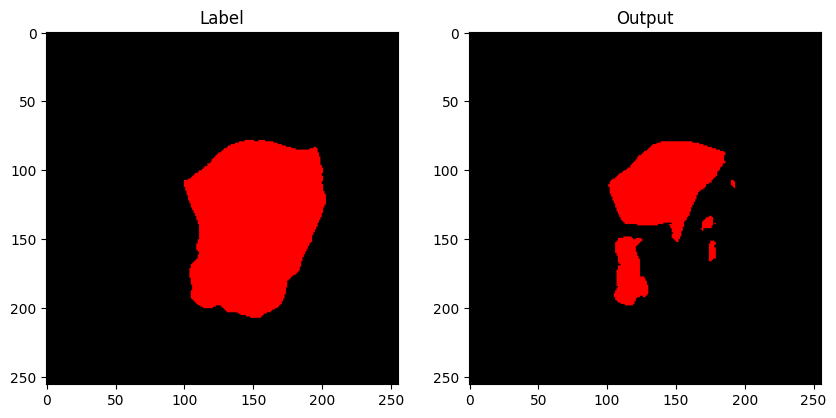

Epoch [105/200] |         Train_loss: 0.0041452483 |         Train_accuracy: 0.3327611570 |         Val_loss: 0.0778818151 |         Val_accuracy: 0.3294982910


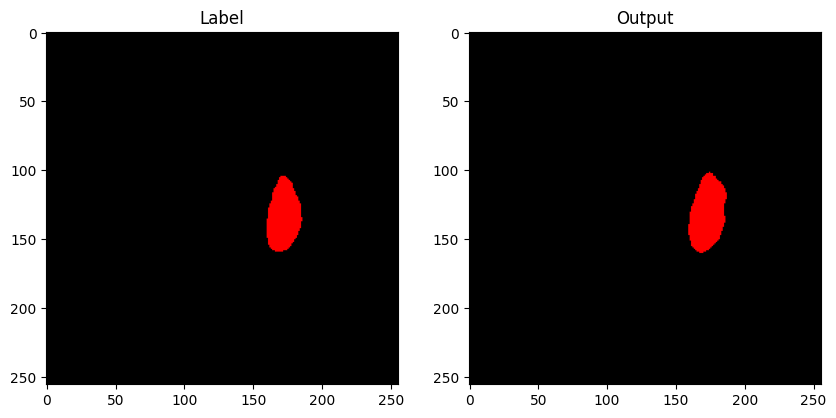

Epoch [106/200] |         Train_loss: 0.0041357322 |         Train_accuracy: 0.3327635701 |         Val_loss: 0.0717310303 |         Val_accuracy: 0.3296371969


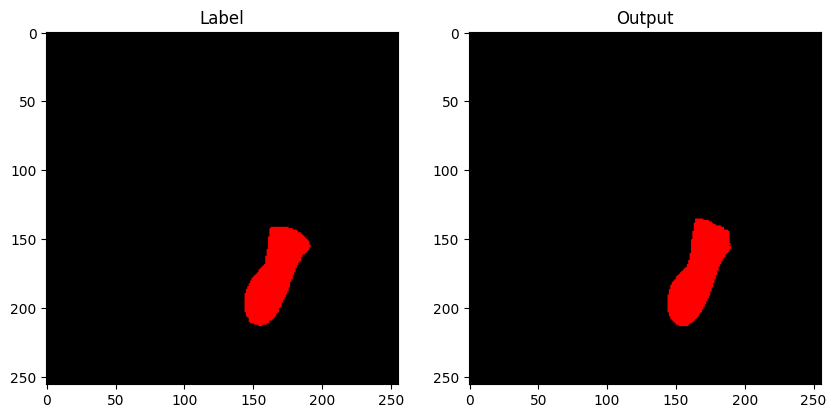

Epoch [107/200] |         Train_loss: 0.0038761614 |         Train_accuracy: 0.3327918611 |         Val_loss: 0.0740679673 |         Val_accuracy: 0.3295392354


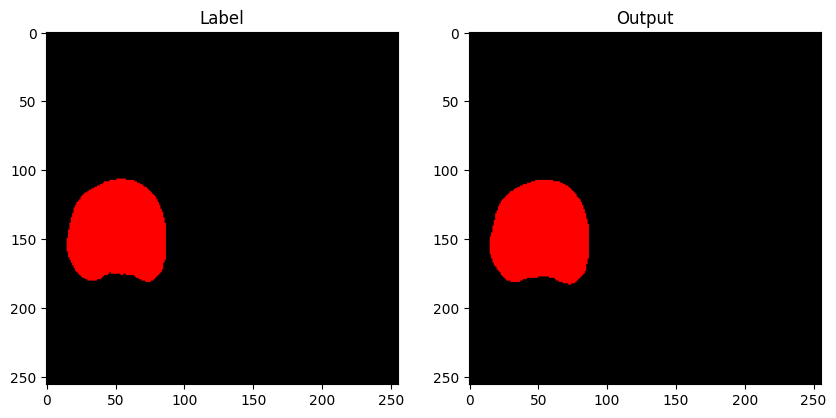

Epoch [108/200] |         Train_loss: 0.0041907883 |         Train_accuracy: 0.3327680461 |         Val_loss: 0.0851217678 |         Val_accuracy: 0.3296292114


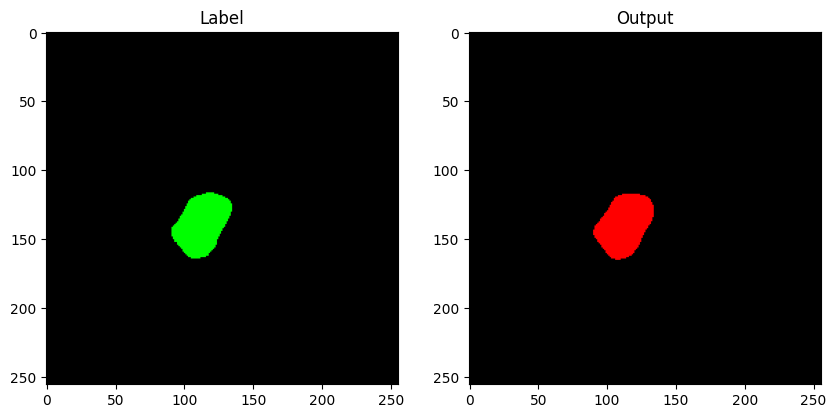

Epoch [109/200] |         Train_loss: 0.0056831277 |         Train_accuracy: 0.3326315873 |         Val_loss: 0.0803898937 |         Val_accuracy: 0.3293835449


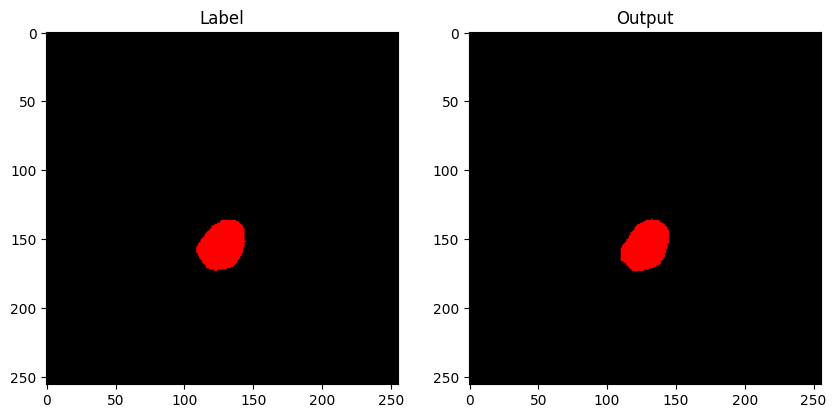

Epoch [110/200] |         Train_loss: 0.0049312447 |         Train_accuracy: 0.3326671911 |         Val_loss: 0.0774597043 |         Val_accuracy: 0.3296394857


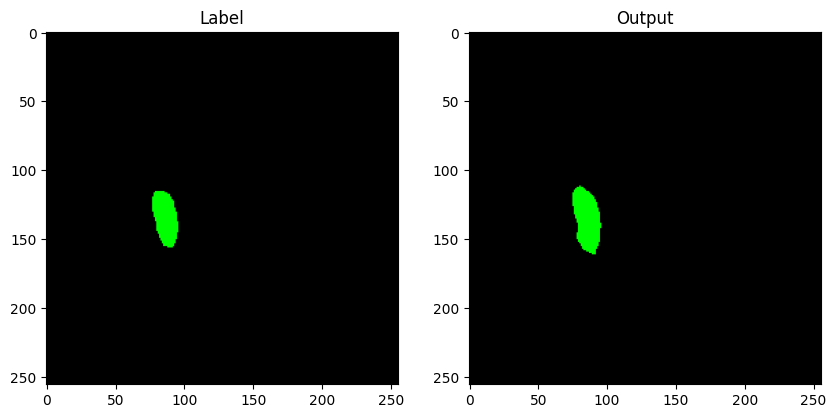

Epoch [111/200] |         Train_loss: 0.0041517638 |         Train_accuracy: 0.3327594898 |         Val_loss: 0.0876968817 |         Val_accuracy: 0.3294797262


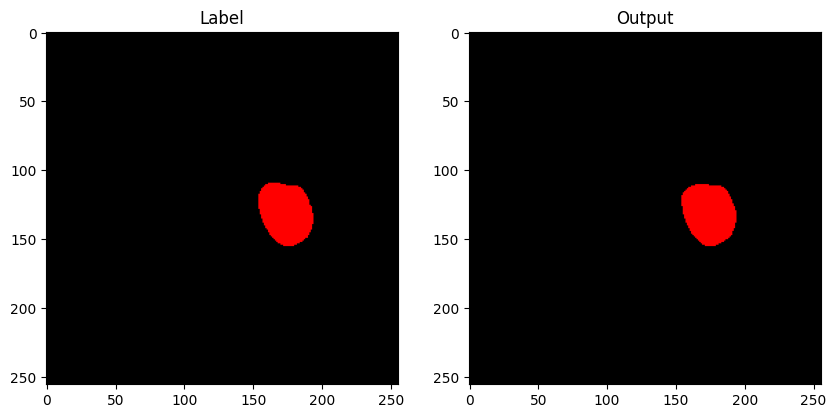

Epoch [112/200] |         Train_loss: 0.0039771802 |         Train_accuracy: 0.3327828640 |         Val_loss: 0.0824450598 |         Val_accuracy: 0.3291546631


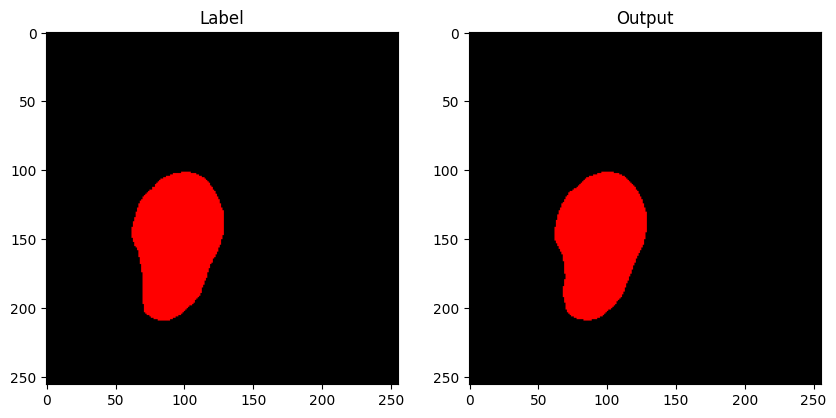

Epoch [113/200] |         Train_loss: 0.0037371926 |         Train_accuracy: 0.3328137603 |         Val_loss: 0.0802366261 |         Val_accuracy: 0.3294213359


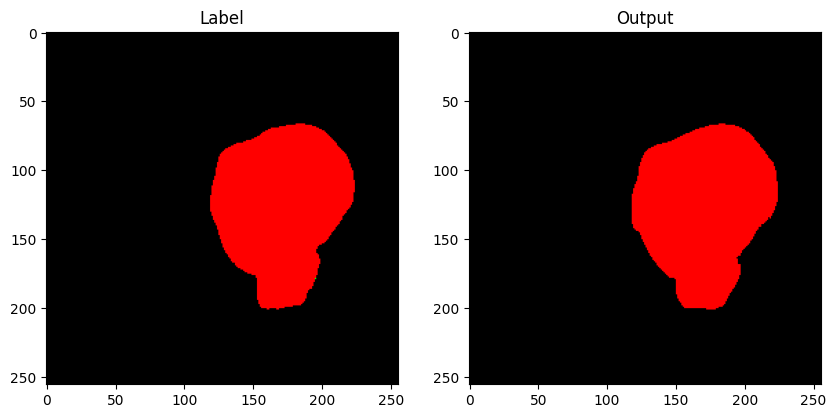

Epoch [114/200] |         Train_loss: 0.0037303038 |         Train_accuracy: 0.3328161395 |         Val_loss: 0.0737807479 |         Val_accuracy: 0.3297516378


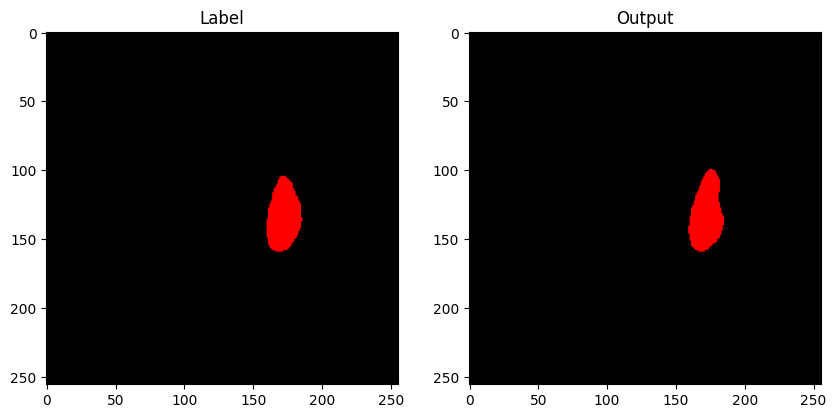

Epoch [115/200] |         Train_loss: 0.0036917002 |         Train_accuracy: 0.3328222995 |         Val_loss: 0.0869074307 |         Val_accuracy: 0.3299452209


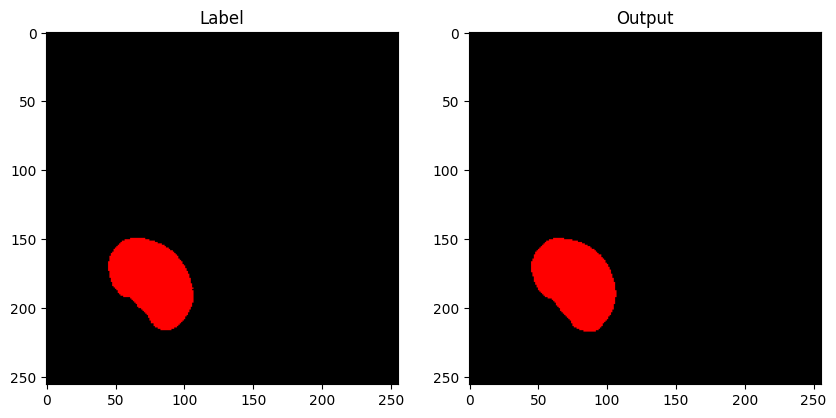

Epoch [116/200] |         Train_loss: 0.0036346508 |         Train_accuracy: 0.3328286517 |         Val_loss: 0.0794852644 |         Val_accuracy: 0.3295802307


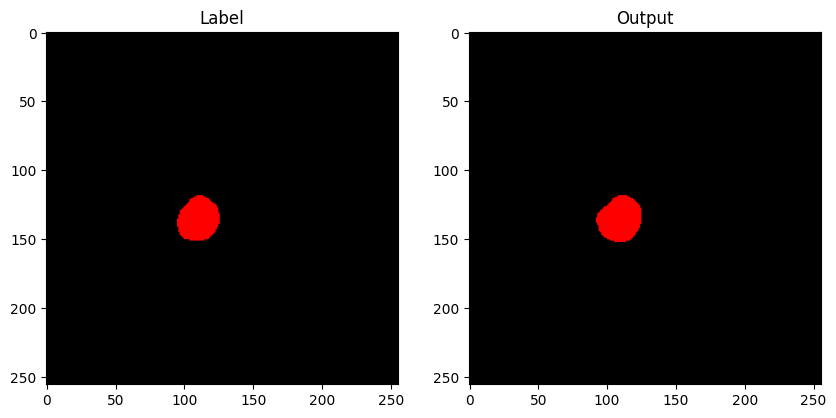

Epoch [117/200] |         Train_loss: 0.0037189417 |         Train_accuracy: 0.3328251026 |         Val_loss: 0.0762499348 |         Val_accuracy: 0.3298720805


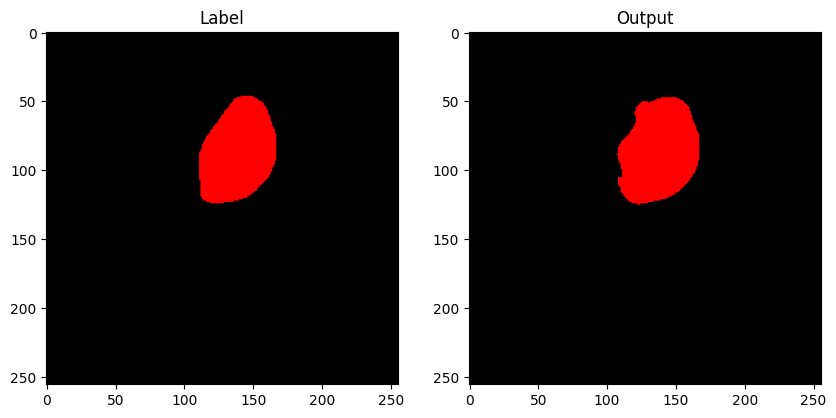

Epoch [118/200] |         Train_loss: 0.0036282381 |         Train_accuracy: 0.3328277757 |         Val_loss: 0.0735266798 |         Val_accuracy: 0.3299086507


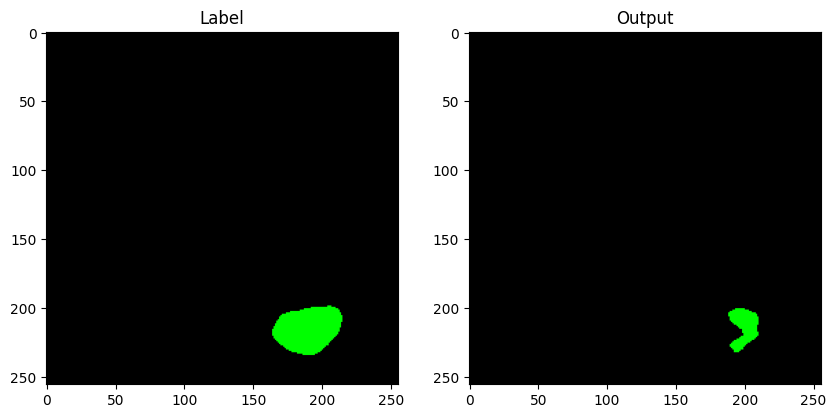

Epoch [119/200] |         Train_loss: 0.0072777747 |         Train_accuracy: 0.3324424009 |         Val_loss: 0.0826445852 |         Val_accuracy: 0.3290961711


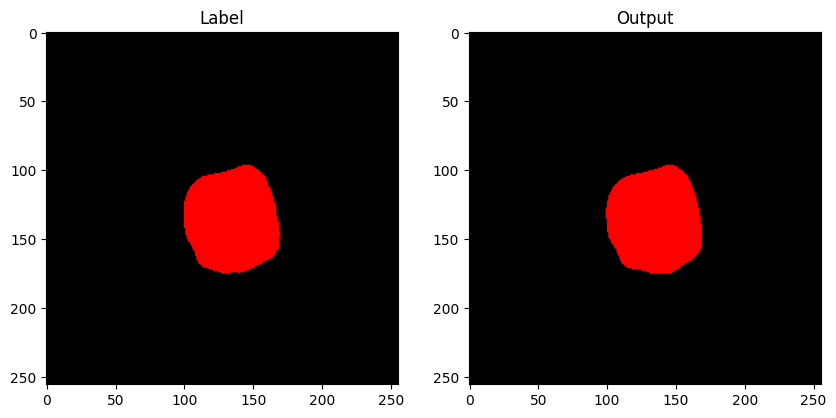

Epoch [120/200] |         Train_loss: 0.0081241476 |         Train_accuracy: 0.3323333288 |         Val_loss: 0.0890181066 |         Val_accuracy: 0.3290017192


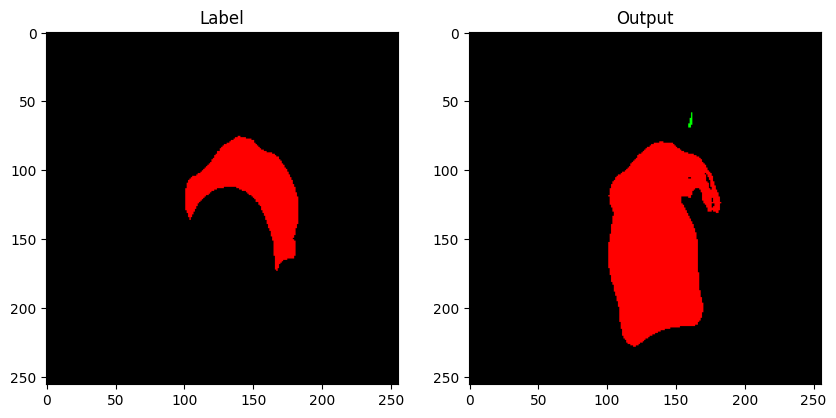

Epoch [121/200] |         Train_loss: 0.0072966007 |         Train_accuracy: 0.3324520252 |         Val_loss: 0.0821955017 |         Val_accuracy: 0.3291249084


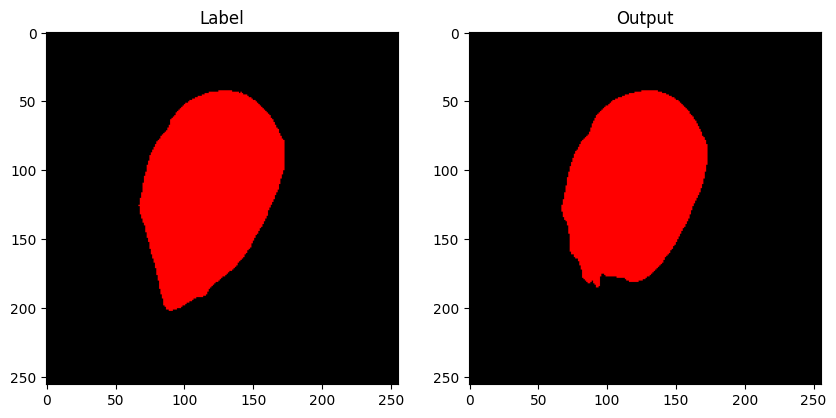

Epoch [122/200] |         Train_loss: 0.0071776950 |         Train_accuracy: 0.3324100975 |         Val_loss: 0.0934220792 |         Val_accuracy: 0.3289300028


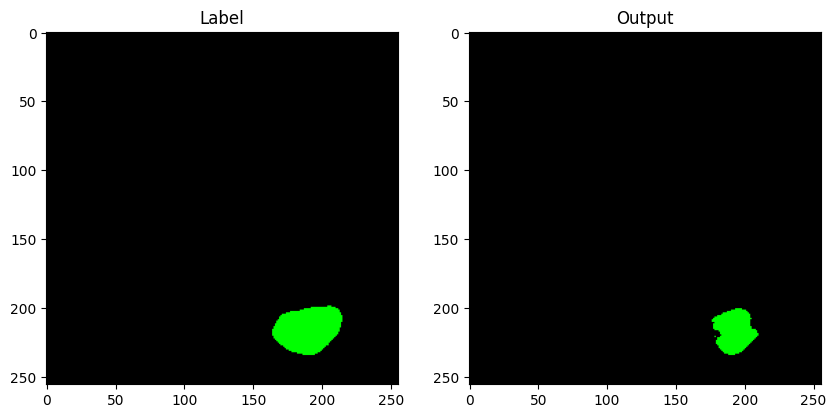

Epoch [123/200] |         Train_loss: 0.0073149449 |         Train_accuracy: 0.3323777601 |         Val_loss: 0.0815481715 |         Val_accuracy: 0.3289239502


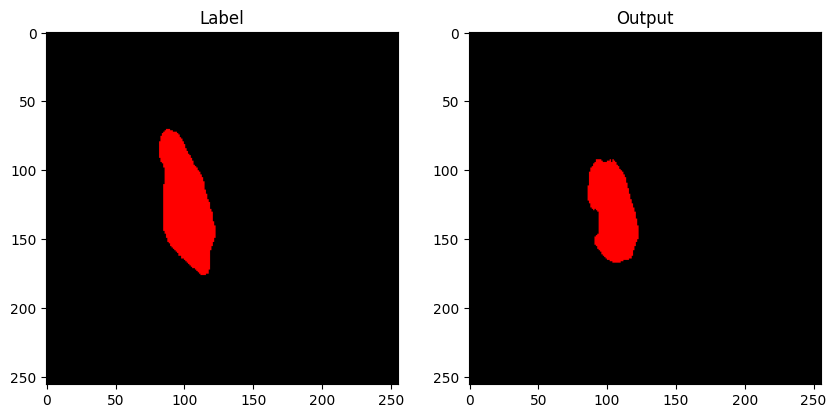

Epoch [124/200] |         Train_loss: 0.0067537004 |         Train_accuracy: 0.3325059001 |         Val_loss: 0.0833611758 |         Val_accuracy: 0.3289872233


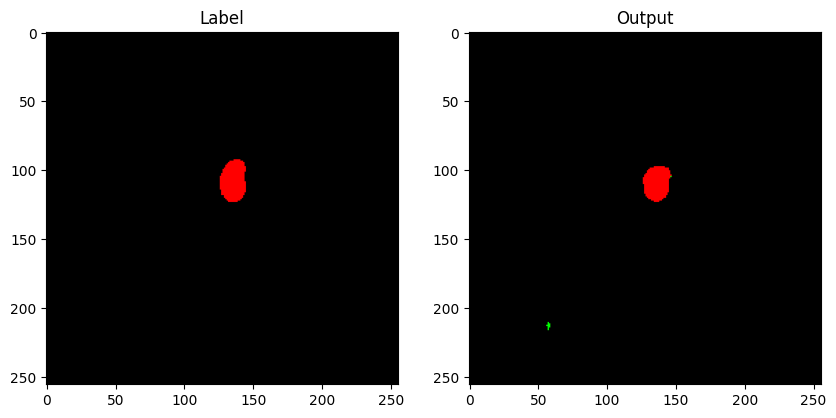

Epoch [125/200] |         Train_loss: 0.0062115861 |         Train_accuracy: 0.3325548525 |         Val_loss: 0.0846681952 |         Val_accuracy: 0.3290808105


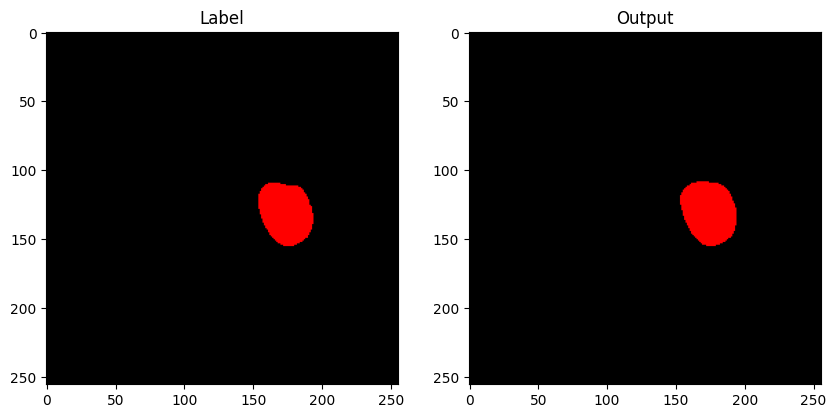

Epoch [126/200] |         Train_loss: 0.0057702222 |         Train_accuracy: 0.3325613516 |         Val_loss: 0.0791245671 |         Val_accuracy: 0.3289685567


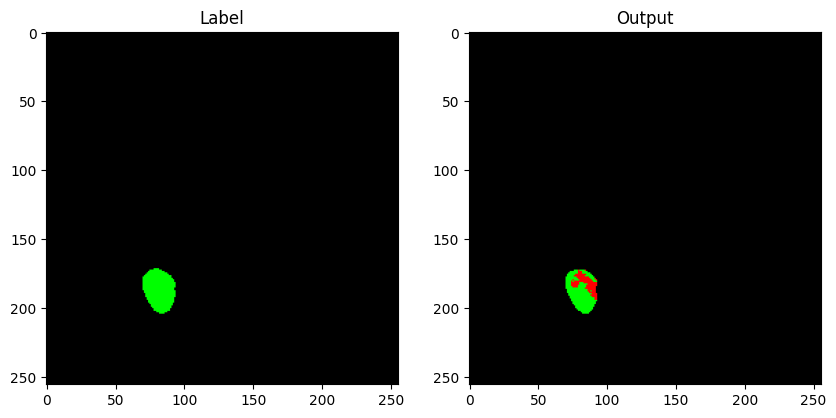

Epoch [127/200] |         Train_loss: 0.0045699684 |         Train_accuracy: 0.3327181894 |         Val_loss: 0.0769863546 |         Val_accuracy: 0.3291780090


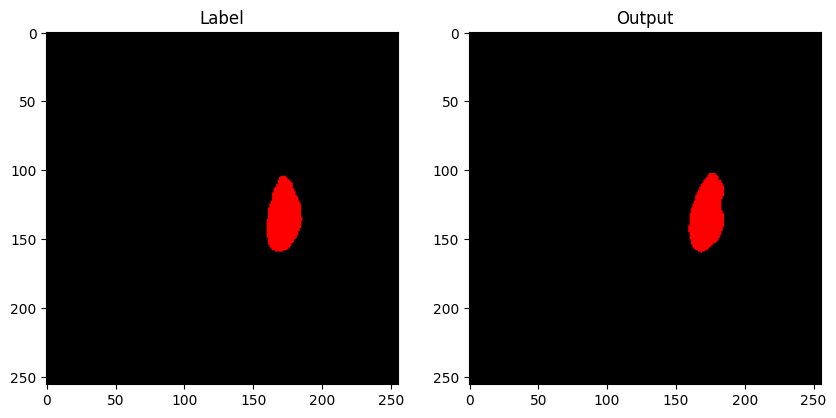

Epoch [128/200] |         Train_loss: 0.0060949754 |         Train_accuracy: 0.3325155753 |         Val_loss: 0.0723369887 |         Val_accuracy: 0.3293108114


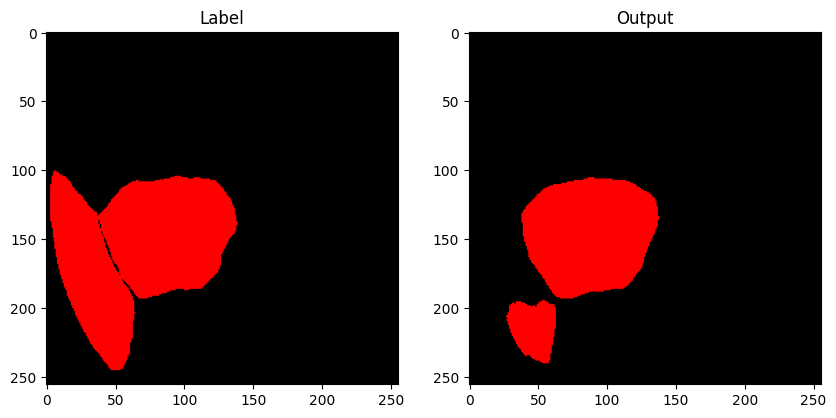

Epoch [129/200] |         Train_loss: 0.0051516680 |         Train_accuracy: 0.3326397988 |         Val_loss: 0.0807287701 |         Val_accuracy: 0.3293849182


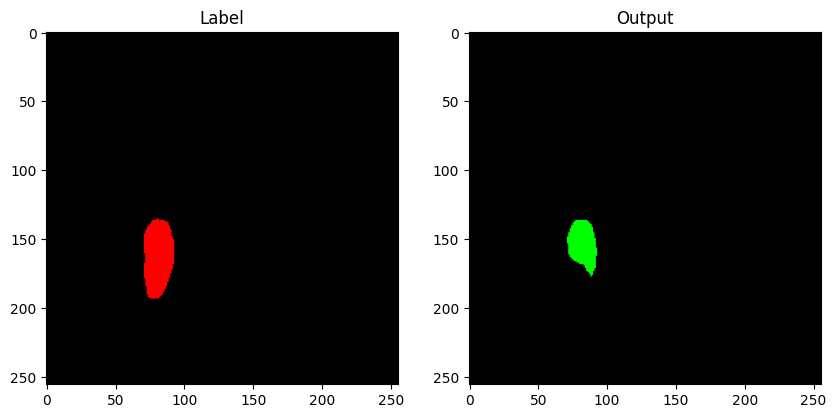

Epoch [130/200] |         Train_loss: 0.0045110719 |         Train_accuracy: 0.3327295487 |         Val_loss: 0.0892382058 |         Val_accuracy: 0.3289186096


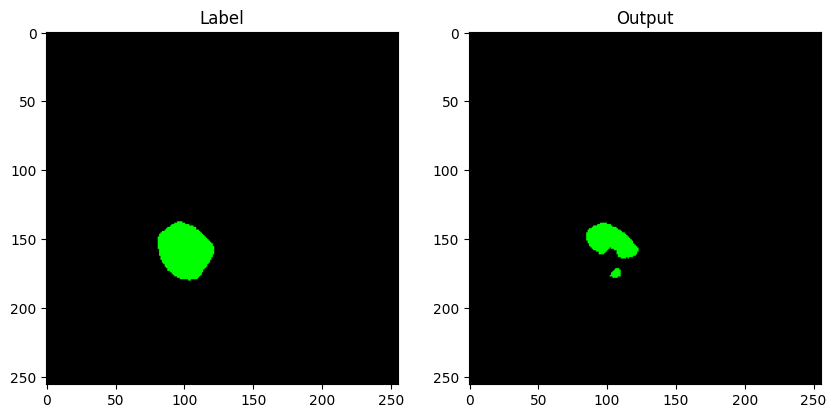

Epoch [131/200] |         Train_loss: 0.0069657210 |         Train_accuracy: 0.3324728733 |         Val_loss: 0.1004675016 |         Val_accuracy: 0.3287571208


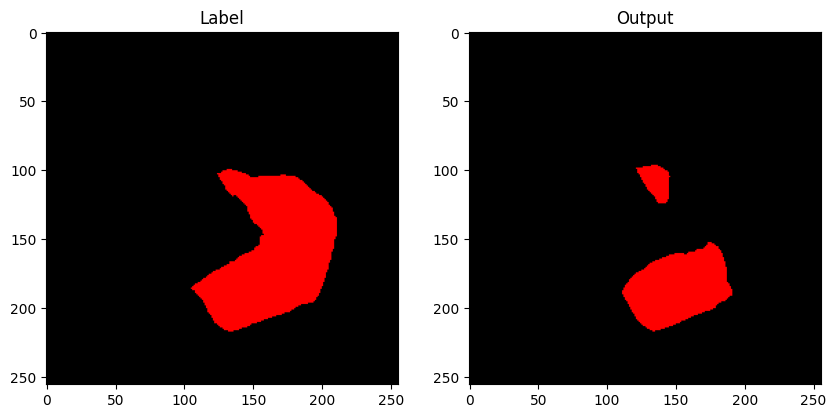

Epoch [132/200] |         Train_loss: 0.0110557858 |         Train_accuracy: 0.3320015349 |         Val_loss: 0.0759977010 |         Val_accuracy: 0.3284449259


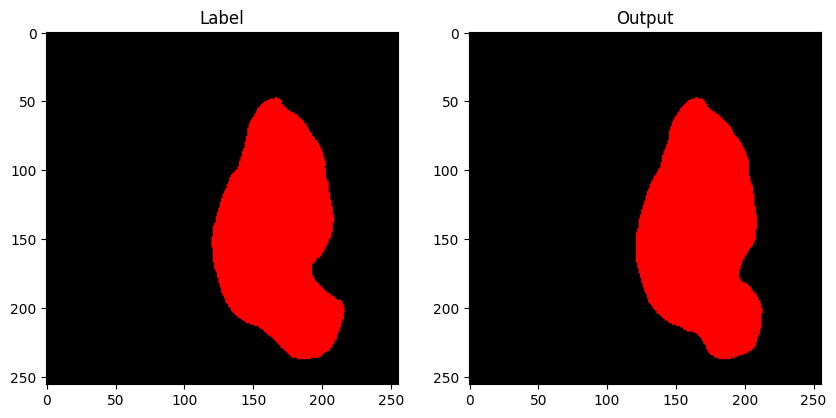

Epoch [133/200] |         Train_loss: 0.0060020607 |         Train_accuracy: 0.3325493763 |         Val_loss: 0.0872375161 |         Val_accuracy: 0.3285899353


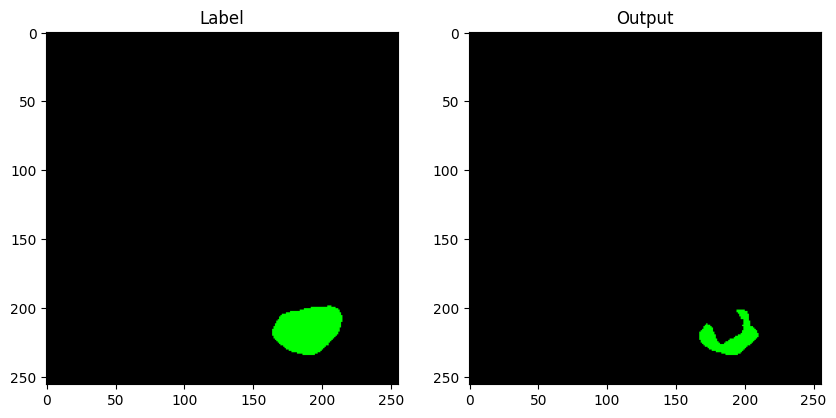

Epoch [134/200] |         Train_loss: 0.0048031218 |         Train_accuracy: 0.3326766968 |         Val_loss: 0.0778911328 |         Val_accuracy: 0.3291191610


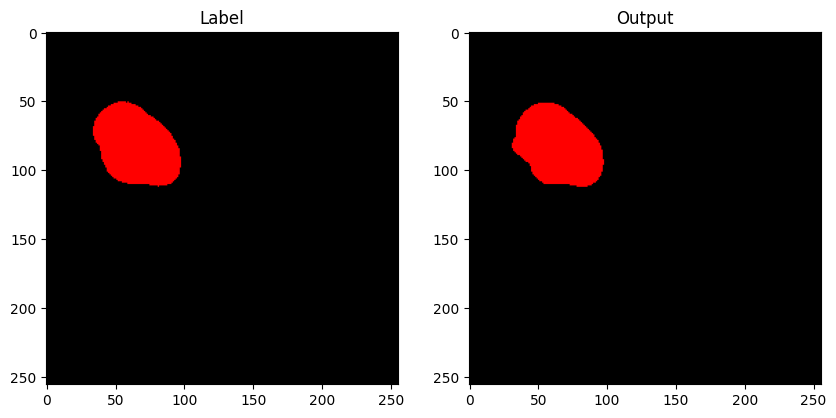

Epoch [135/200] |         Train_loss: 0.0041172101 |         Train_accuracy: 0.3327776082 |         Val_loss: 0.0814098177 |         Val_accuracy: 0.3290217082


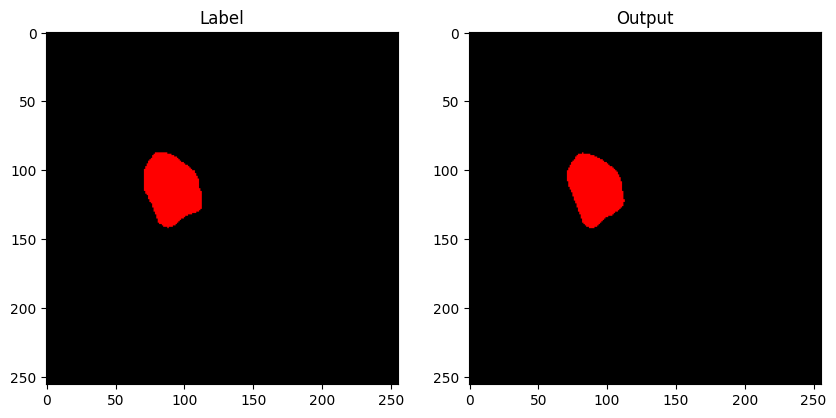

Epoch [136/200] |         Train_loss: 0.0041355876 |         Train_accuracy: 0.3327741439 |         Val_loss: 0.0843278205 |         Val_accuracy: 0.3289411926


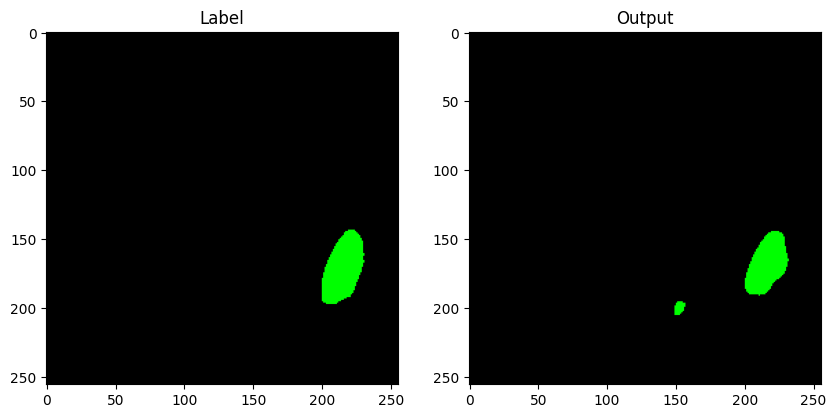

Epoch [137/200] |         Train_loss: 0.0041618721 |         Train_accuracy: 0.3327746582 |         Val_loss: 0.0858199778 |         Val_accuracy: 0.3288605754


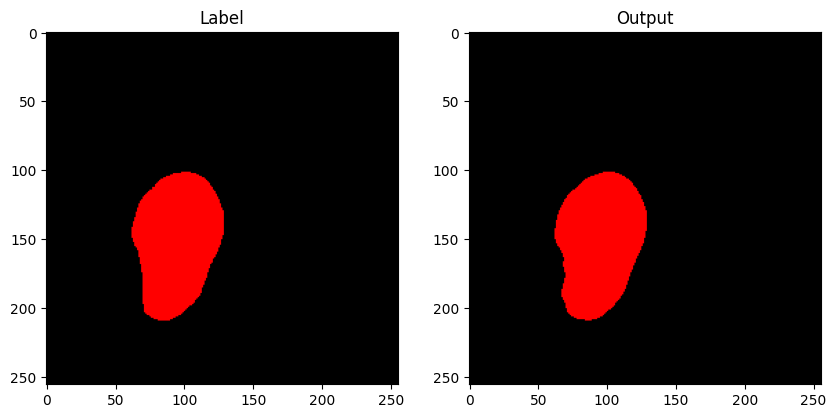

Epoch [138/200] |         Train_loss: 0.0037822713 |         Train_accuracy: 0.3328148001 |         Val_loss: 0.0899223110 |         Val_accuracy: 0.3287605286


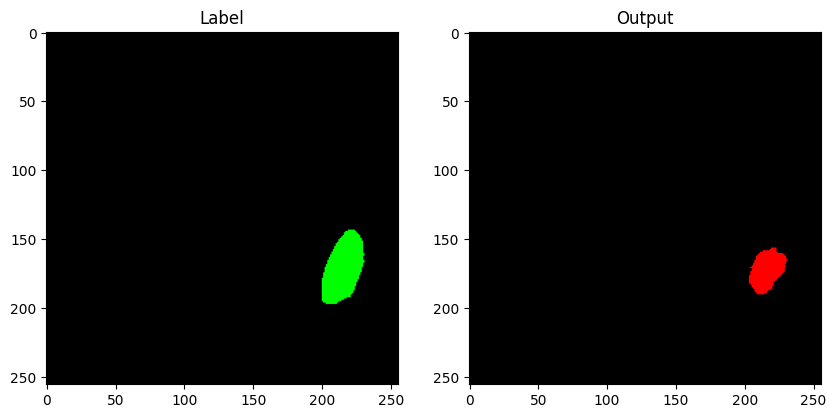

Epoch [139/200] |         Train_loss: 0.0035576739 |         Train_accuracy: 0.3328406949 |         Val_loss: 0.0848221482 |         Val_accuracy: 0.3290464274


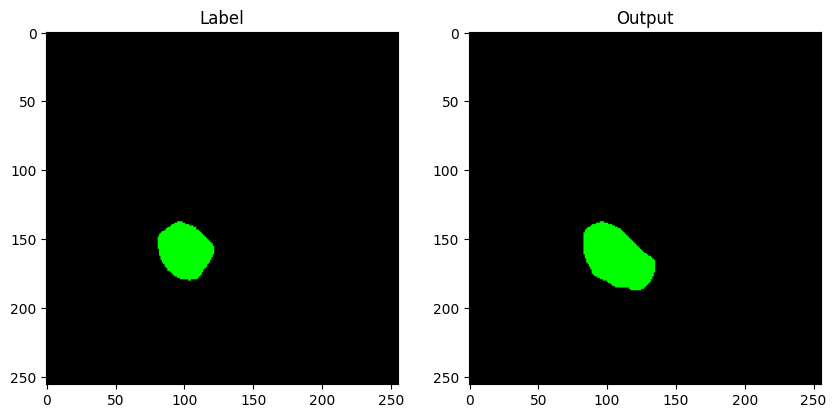

Epoch [140/200] |         Train_loss: 0.0035948378 |         Train_accuracy: 0.3328374396 |         Val_loss: 0.0854979308 |         Val_accuracy: 0.3289492798


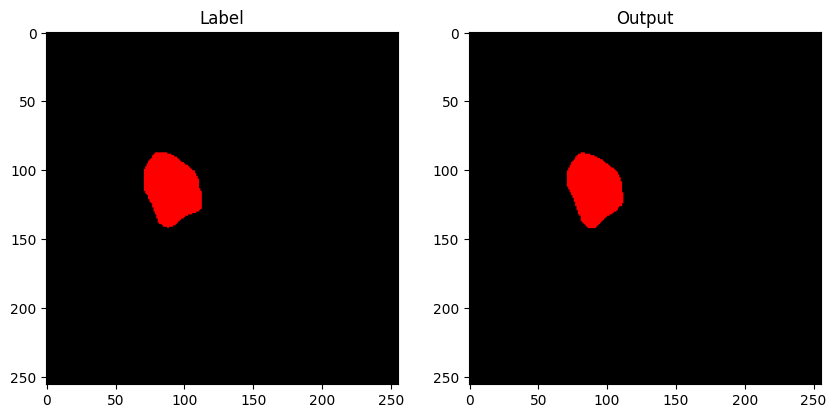

Epoch [141/200] |         Train_loss: 0.0034675310 |         Train_accuracy: 0.3328531562 |         Val_loss: 0.0766008357 |         Val_accuracy: 0.3294674683


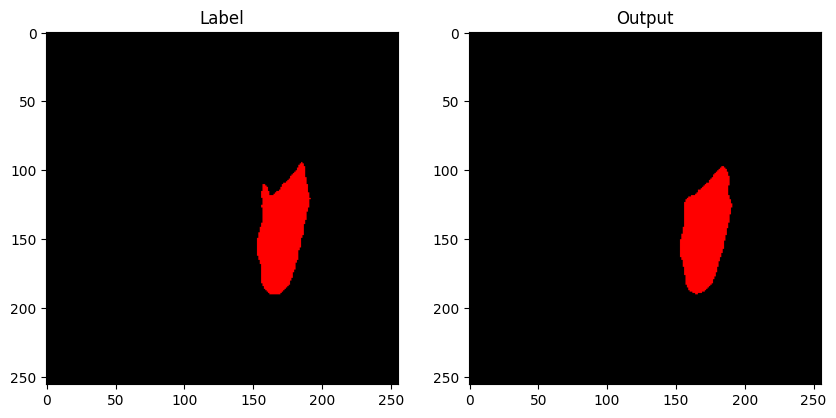

Epoch [142/200] |         Train_loss: 0.0036283187 |         Train_accuracy: 0.3328350095 |         Val_loss: 0.0916320275 |         Val_accuracy: 0.3290450541


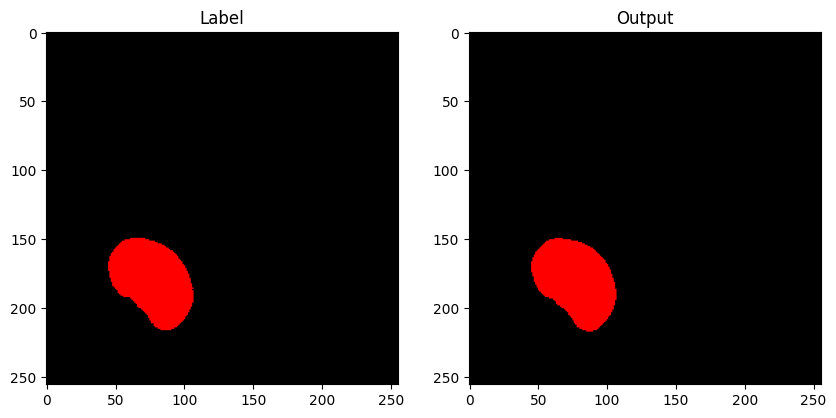

Epoch [143/200] |         Train_loss: 0.0035409602 |         Train_accuracy: 0.3328364620 |         Val_loss: 0.0894054258 |         Val_accuracy: 0.3293176778


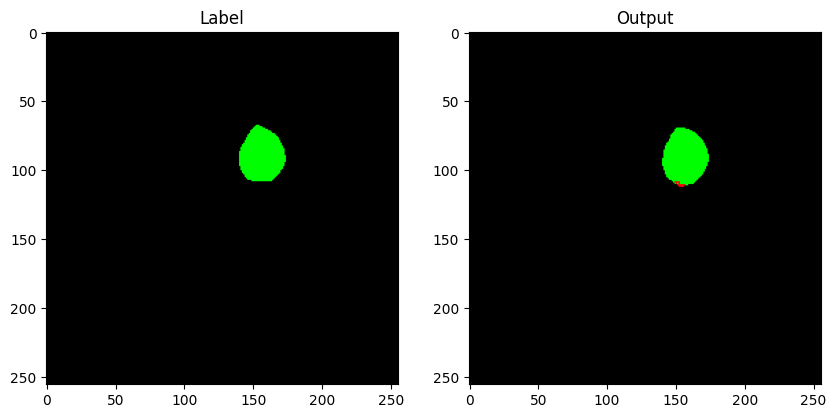

Epoch [144/200] |         Train_loss: 0.0034528890 |         Train_accuracy: 0.3328560384 |         Val_loss: 0.0941556989 |         Val_accuracy: 0.3292807007


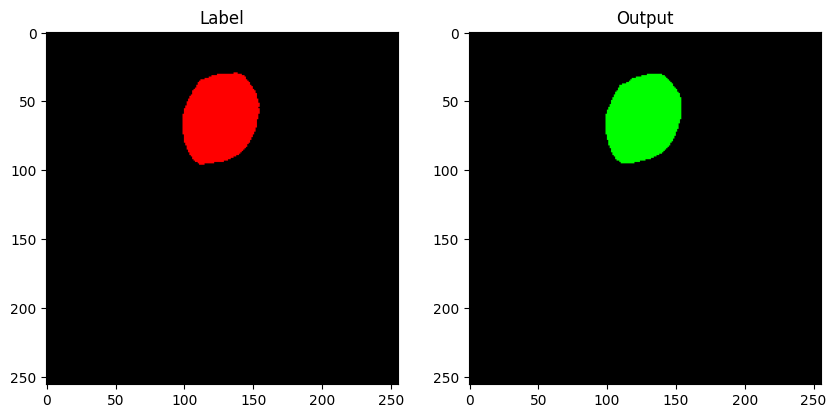

Epoch [145/200] |         Train_loss: 0.0032443321 |         Train_accuracy: 0.3328765643 |         Val_loss: 0.0912732397 |         Val_accuracy: 0.3292878723


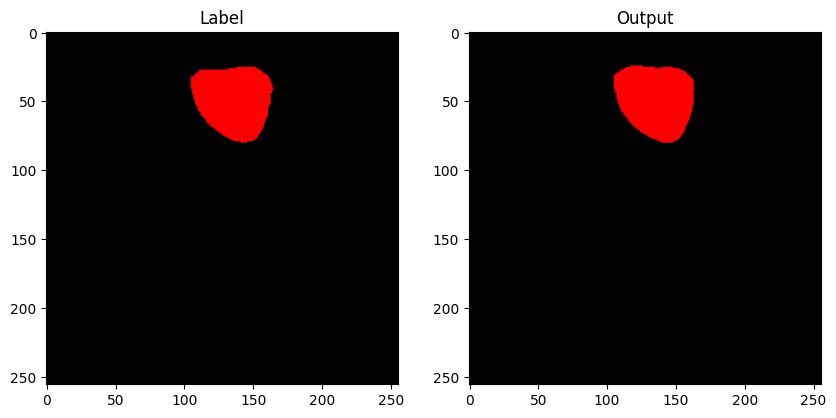

Epoch [146/200] |         Train_loss: 0.0031602728 |         Train_accuracy: 0.3328916818 |         Val_loss: 0.0892696080 |         Val_accuracy: 0.3294310506


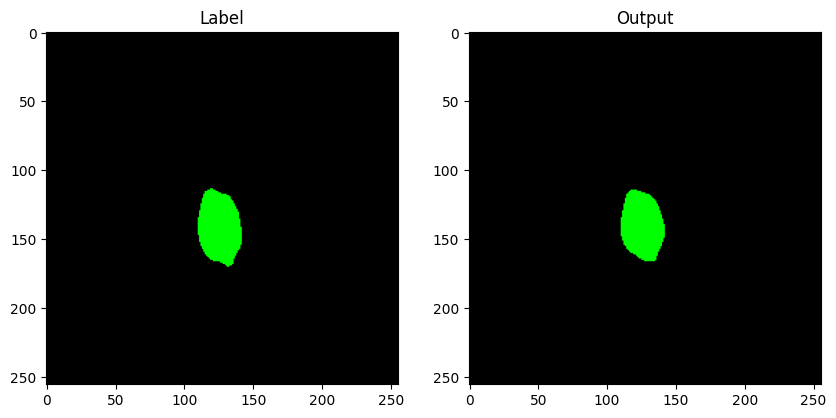

Epoch [147/200] |         Train_loss: 0.0031158989 |         Train_accuracy: 0.3328965251 |         Val_loss: 0.0918116094 |         Val_accuracy: 0.3293474325


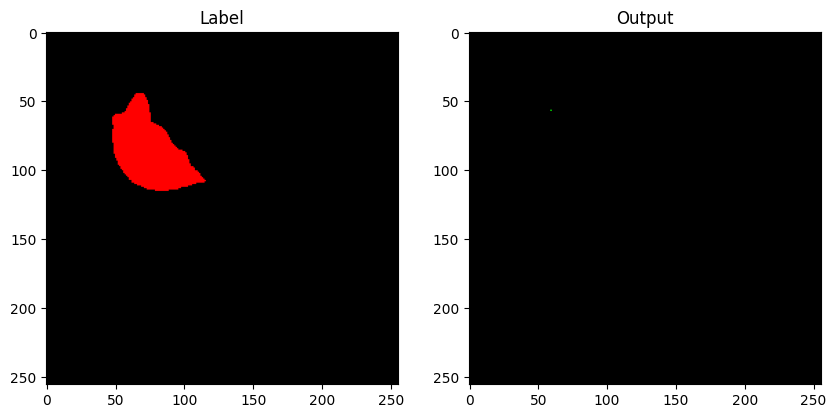

Epoch [148/200] |         Train_loss: 0.0030754990 |         Train_accuracy: 0.3329001307 |         Val_loss: 0.0953424292 |         Val_accuracy: 0.3293260193


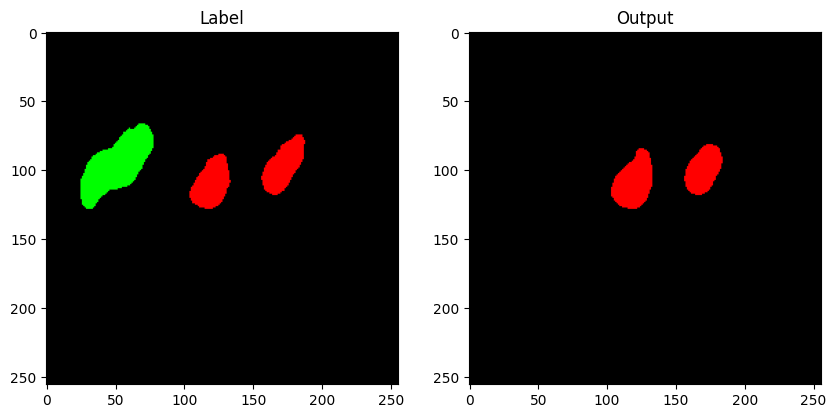

Epoch [149/200] |         Train_loss: 0.0032902719 |         Train_accuracy: 0.3328911280 |         Val_loss: 0.1160446612 |         Val_accuracy: 0.3292805481


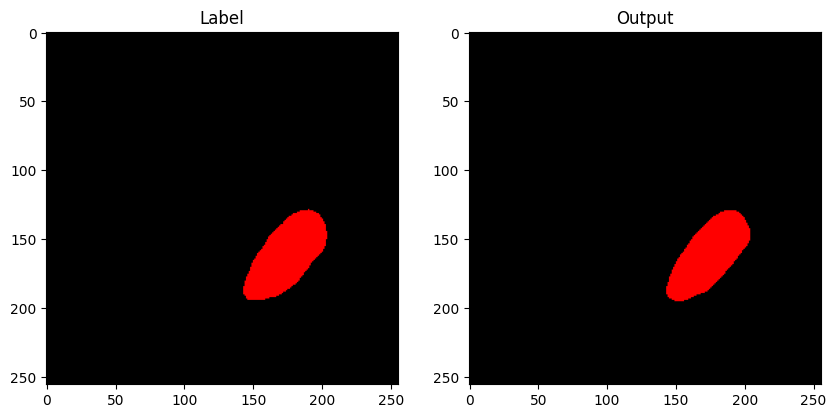

Epoch [150/200] |         Train_loss: 0.0038302863 |         Train_accuracy: 0.3328217570 |         Val_loss: 0.0857314030 |         Val_accuracy: 0.3295179749


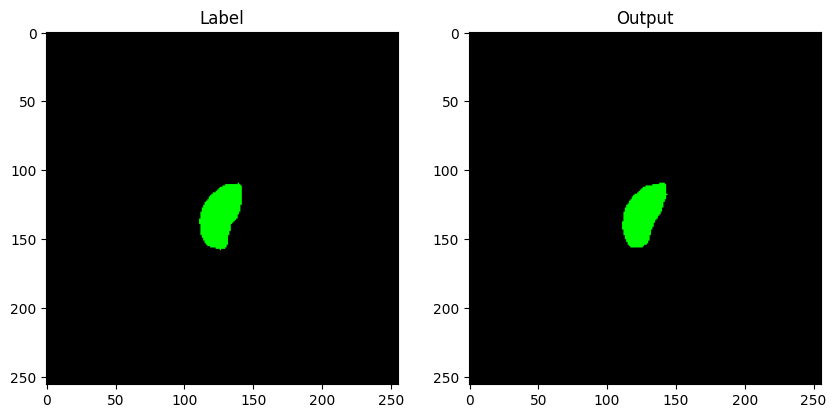

Epoch [151/200] |         Train_loss: 0.0034025145 |         Train_accuracy: 0.3328685619 |         Val_loss: 0.0935938562 |         Val_accuracy: 0.3295082601


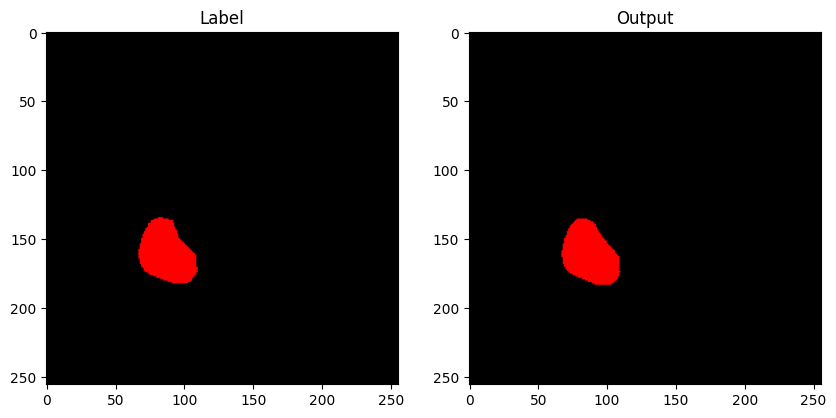

Epoch [152/200] |         Train_loss: 0.0032483332 |         Train_accuracy: 0.3328800682 |         Val_loss: 0.0952291921 |         Val_accuracy: 0.3294545492


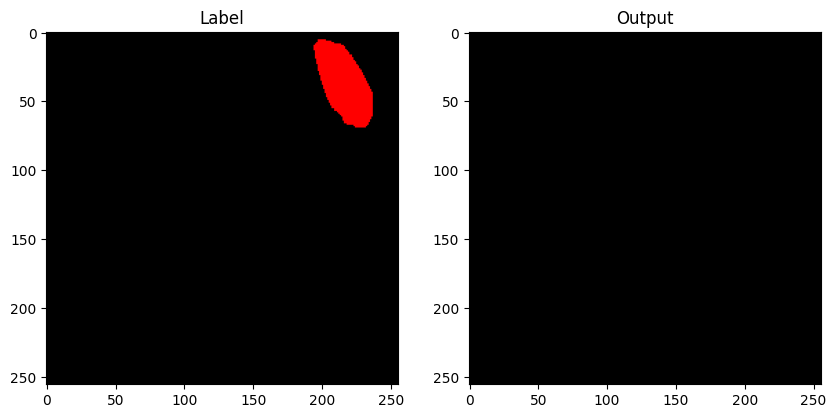

Epoch [153/200] |         Train_loss: 0.0049074584 |         Train_accuracy: 0.3327477575 |         Val_loss: 0.0940361495 |         Val_accuracy: 0.3291033936


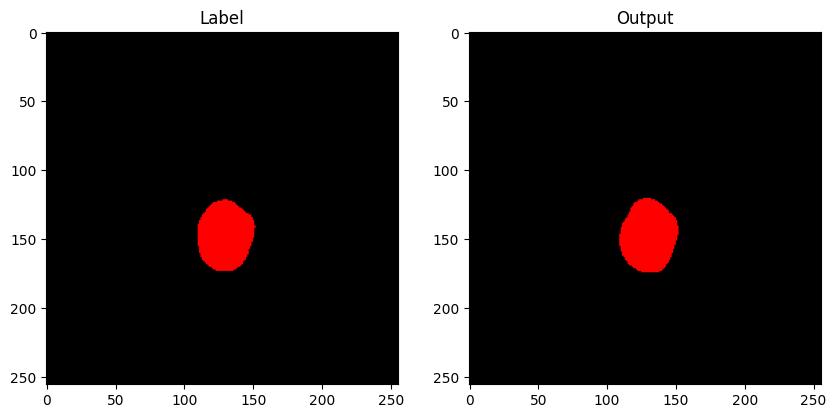

Epoch [154/200] |         Train_loss: 0.0035635441 |         Train_accuracy: 0.3328453742 |         Val_loss: 0.0902503682 |         Val_accuracy: 0.3292087809


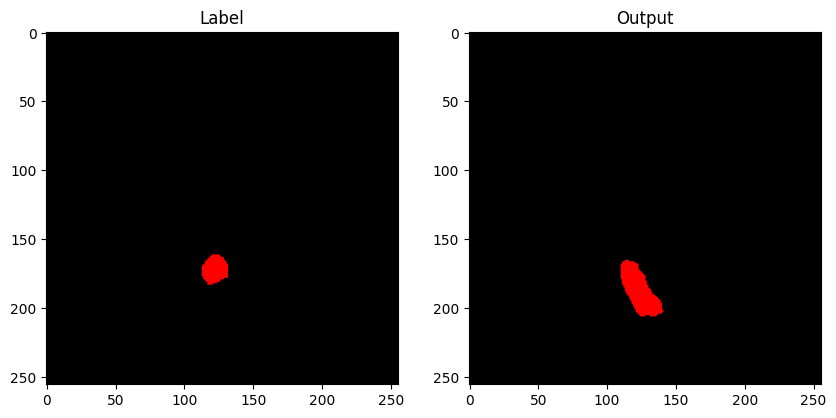

Epoch [155/200] |         Train_loss: 0.0044345508 |         Train_accuracy: 0.3327575627 |         Val_loss: 0.1085964070 |         Val_accuracy: 0.3290535482


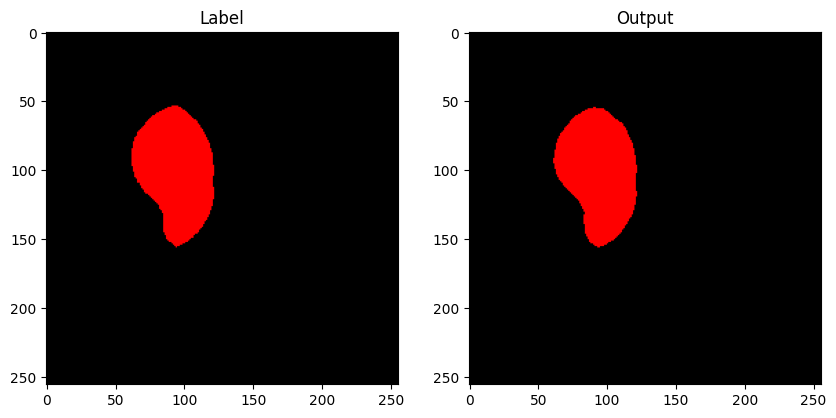

Epoch [156/200] |         Train_loss: 0.0045794283 |         Train_accuracy: 0.3327451748 |         Val_loss: 0.1033762681 |         Val_accuracy: 0.3282062785


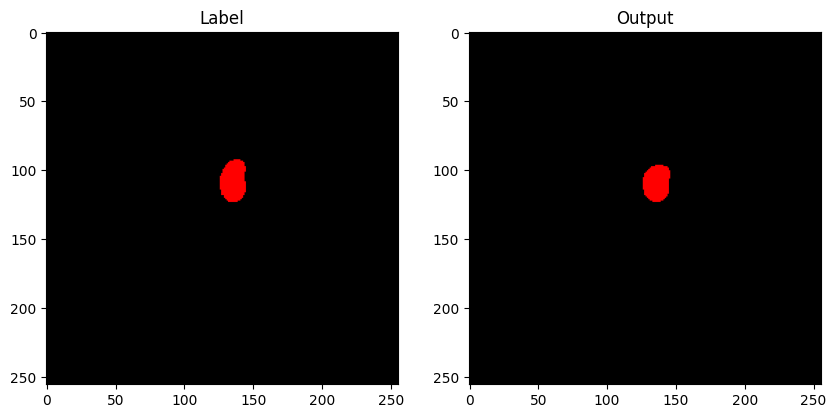

Epoch [157/200] |         Train_loss: 0.0085944145 |         Train_accuracy: 0.3322802282 |         Val_loss: 0.0983611999 |         Val_accuracy: 0.3284293620


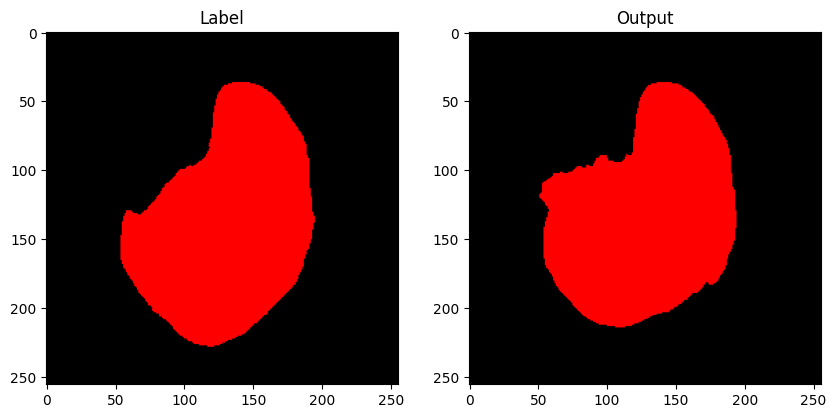

Epoch [158/200] |         Train_loss: 0.0160651507 |         Train_accuracy: 0.3314198586 |         Val_loss: 0.0891109279 |         Val_accuracy: 0.3276000468


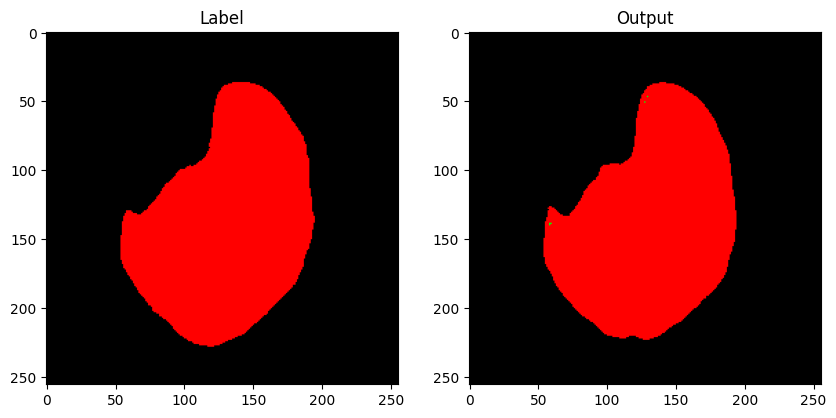

Epoch [159/200] |         Train_loss: 0.0163225308 |         Train_accuracy: 0.3317074189 |         Val_loss: 0.0717430721 |         Val_accuracy: 0.3291329447


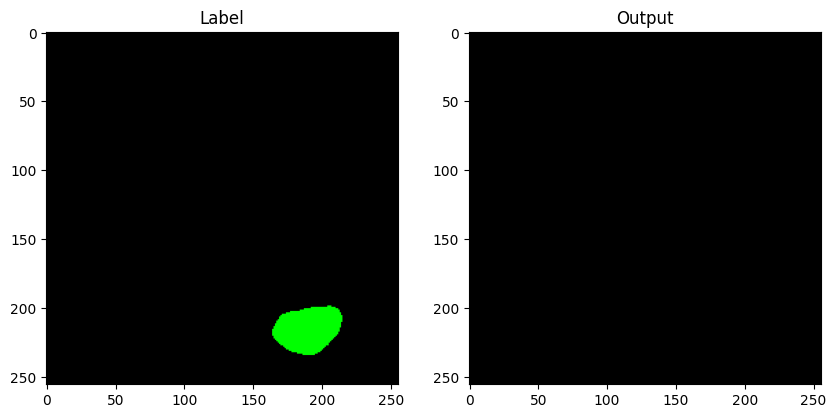

Epoch [160/200] |         Train_loss: 0.0077942510 |         Train_accuracy: 0.3323700968 |         Val_loss: 0.0640134874 |         Val_accuracy: 0.3296284993


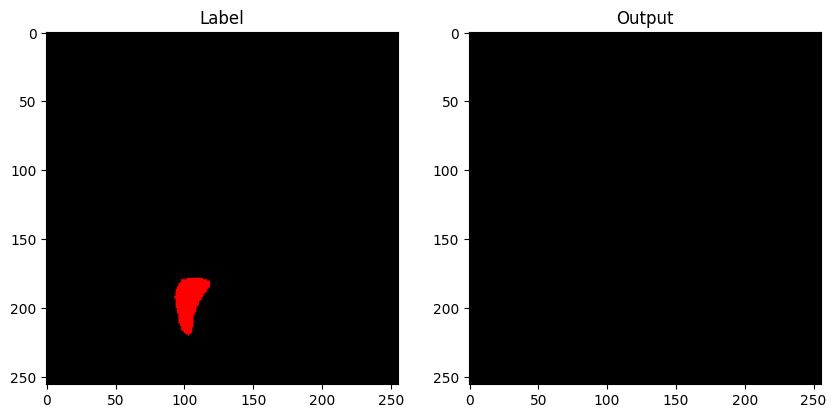

Epoch [161/200] |         Train_loss: 0.0055926024 |         Train_accuracy: 0.3326159498 |         Val_loss: 0.0769566493 |         Val_accuracy: 0.3294761658


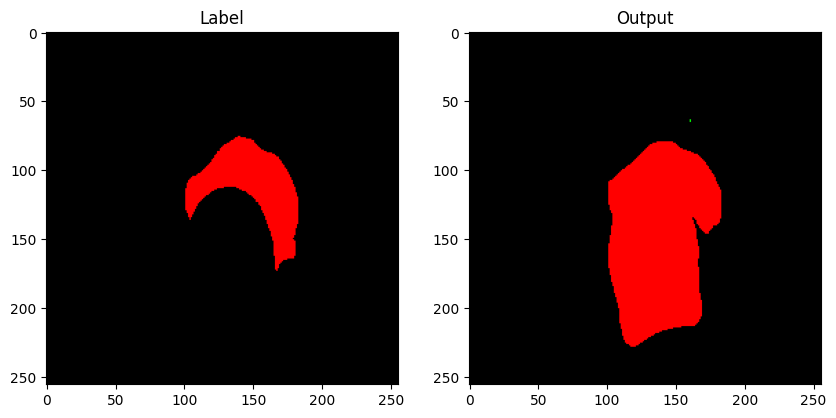

Epoch [162/200] |         Train_loss: 0.0048431497 |         Train_accuracy: 0.3326873836 |         Val_loss: 0.0703658653 |         Val_accuracy: 0.3294804382


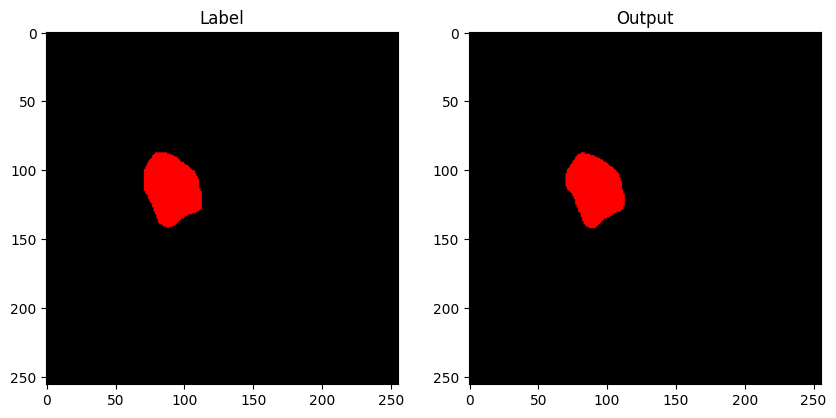

Epoch [163/200] |         Train_loss: 0.0050625208 |         Train_accuracy: 0.3326652188 |         Val_loss: 0.0795192110 |         Val_accuracy: 0.3292290243


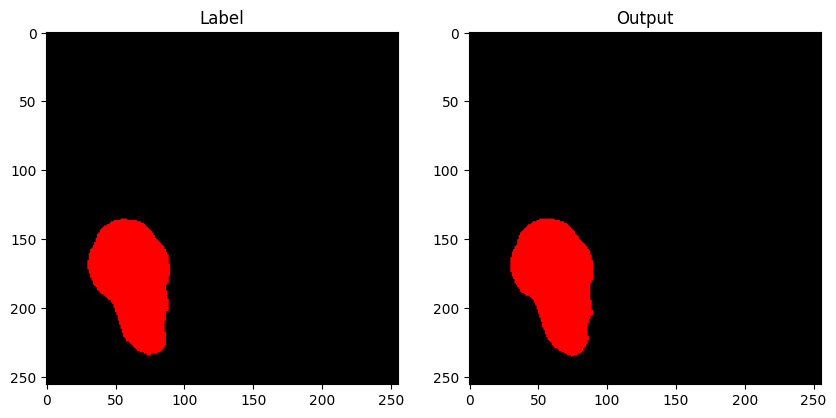

Epoch [164/200] |         Train_loss: 0.0045118559 |         Train_accuracy: 0.3327209303 |         Val_loss: 0.0759922141 |         Val_accuracy: 0.3291727193


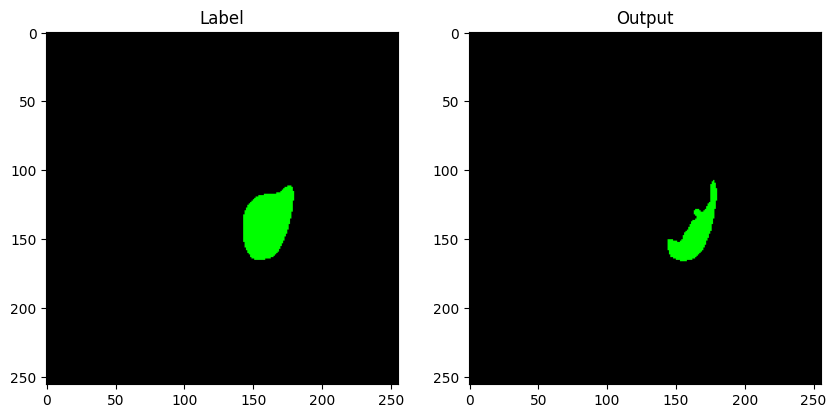

Epoch [165/200] |         Train_loss: 0.0037684543 |         Train_accuracy: 0.3328146023 |         Val_loss: 0.0828226406 |         Val_accuracy: 0.3292940267


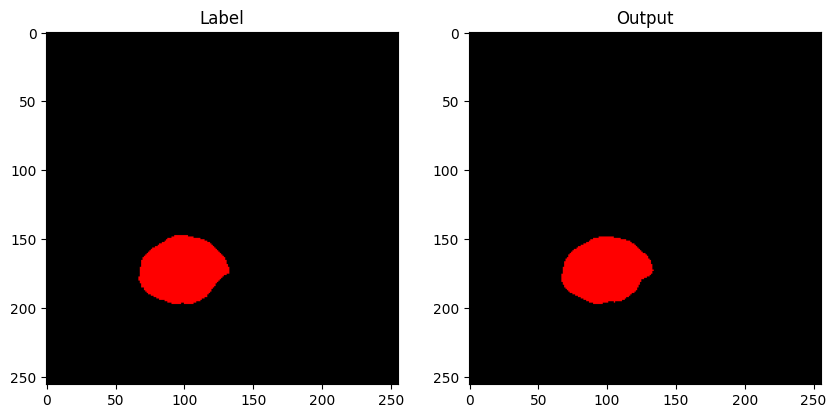

Epoch [166/200] |         Train_loss: 0.0037370557 |         Train_accuracy: 0.3328290247 |         Val_loss: 0.0854594230 |         Val_accuracy: 0.3291819763


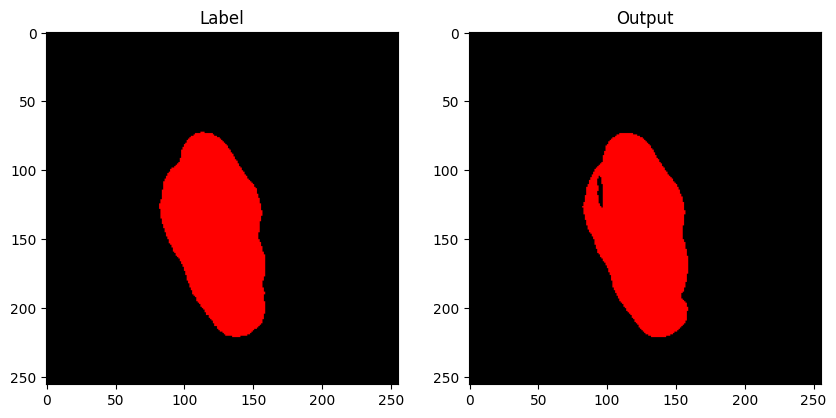

Epoch [167/200] |         Train_loss: 0.0035296705 |         Train_accuracy: 0.3328446508 |         Val_loss: 0.0865262391 |         Val_accuracy: 0.3293167623


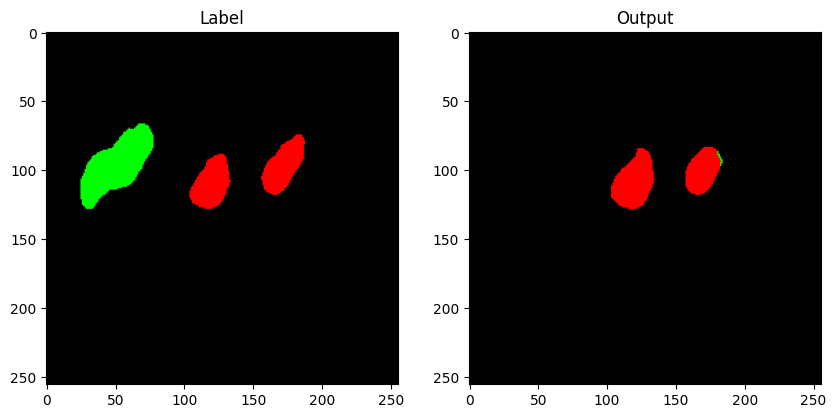

Epoch [168/200] |         Train_loss: 0.0033874702 |         Train_accuracy: 0.3328629049 |         Val_loss: 0.0905777996 |         Val_accuracy: 0.3292189026


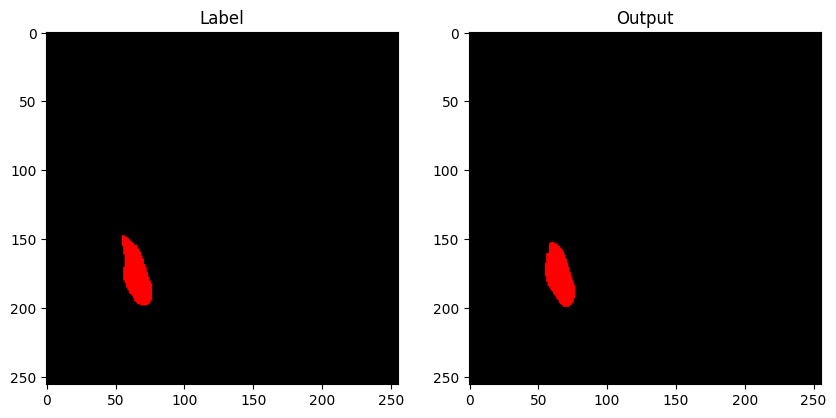

Epoch [169/200] |         Train_loss: 0.0032011749 |         Train_accuracy: 0.3328897886 |         Val_loss: 0.0887865960 |         Val_accuracy: 0.3292428589


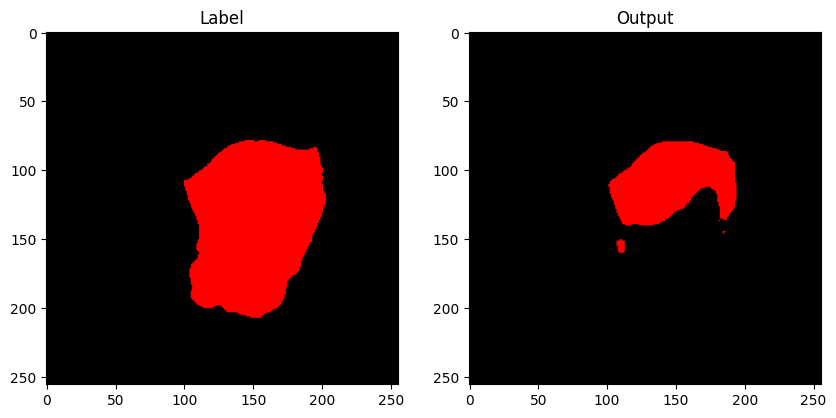

Epoch [170/200] |         Train_loss: 0.0031511023 |         Train_accuracy: 0.3328965420 |         Val_loss: 0.0821750061 |         Val_accuracy: 0.3293427531


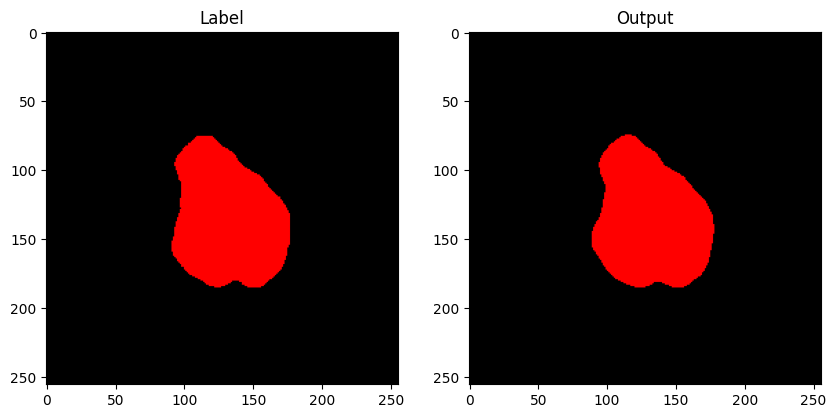

Epoch [171/200] |         Train_loss: 0.0031463146 |         Train_accuracy: 0.3328920435 |         Val_loss: 0.0920292211 |         Val_accuracy: 0.3292470805


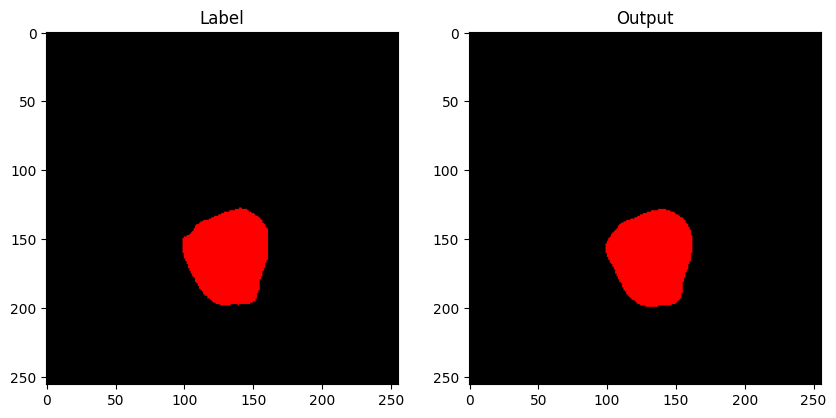

Epoch [172/200] |         Train_loss: 0.0050062447 |         Train_accuracy: 0.3327025463 |         Val_loss: 0.0906437686 |         Val_accuracy: 0.3287922668


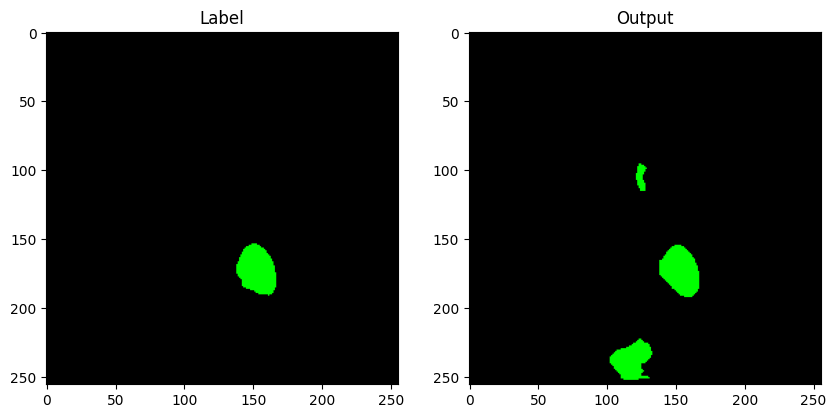

Epoch [173/200] |         Train_loss: 0.0053081745 |         Train_accuracy: 0.3326803702 |         Val_loss: 0.0842250590 |         Val_accuracy: 0.3294863383


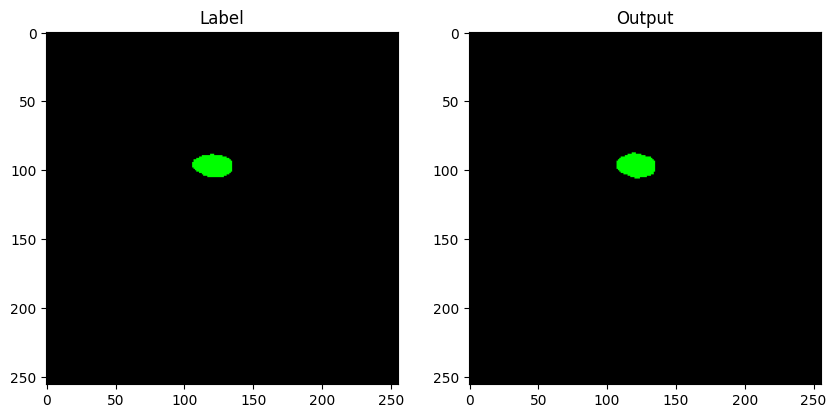

Epoch [174/200] |         Train_loss: 0.0040277212 |         Train_accuracy: 0.3327891880 |         Val_loss: 0.0925292508 |         Val_accuracy: 0.3291932170


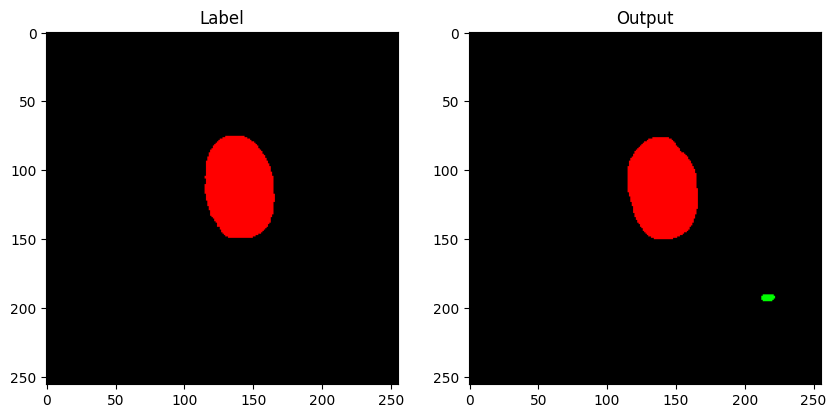

Epoch [175/200] |         Train_loss: 0.0057013193 |         Train_accuracy: 0.3326989972 |         Val_loss: 0.0899903919 |         Val_accuracy: 0.3290590413


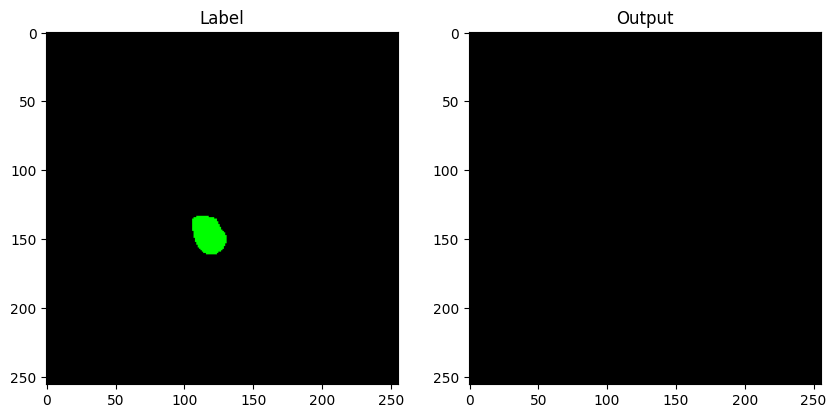

Epoch [176/200] |         Train_loss: 0.0033881341 |         Train_accuracy: 0.3328639673 |         Val_loss: 0.0874863992 |         Val_accuracy: 0.3292749532


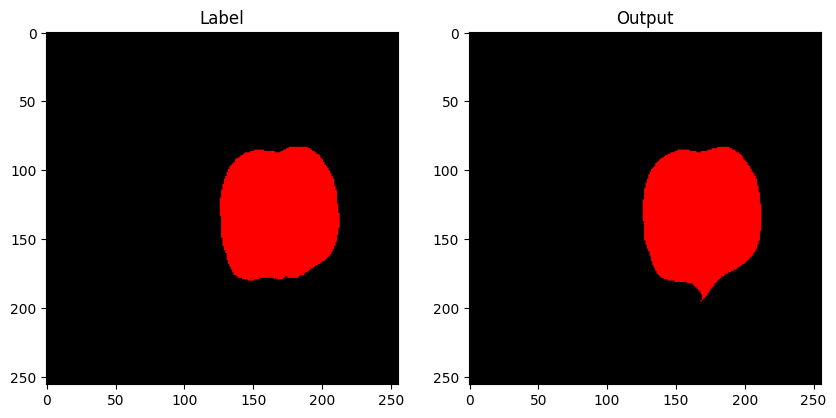

Epoch [177/200] |         Train_loss: 0.0031932596 |         Train_accuracy: 0.3328916649 |         Val_loss: 0.0931944786 |         Val_accuracy: 0.3292354329


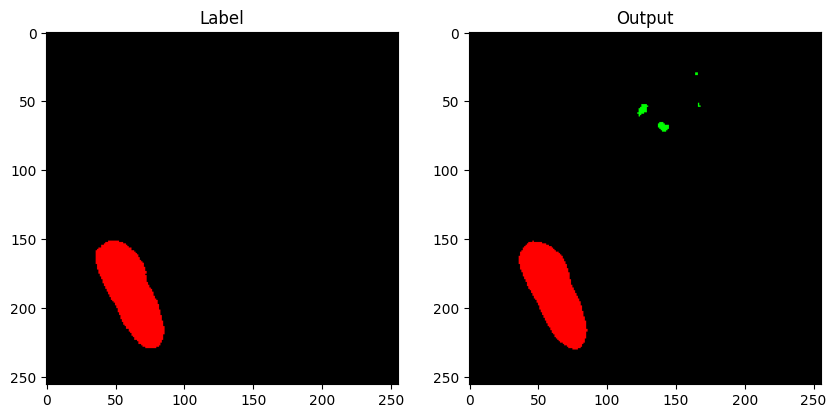

Epoch [178/200] |         Train_loss: 0.0034228340 |         Train_accuracy: 0.3328802660 |         Val_loss: 0.0934376930 |         Val_accuracy: 0.3287279765


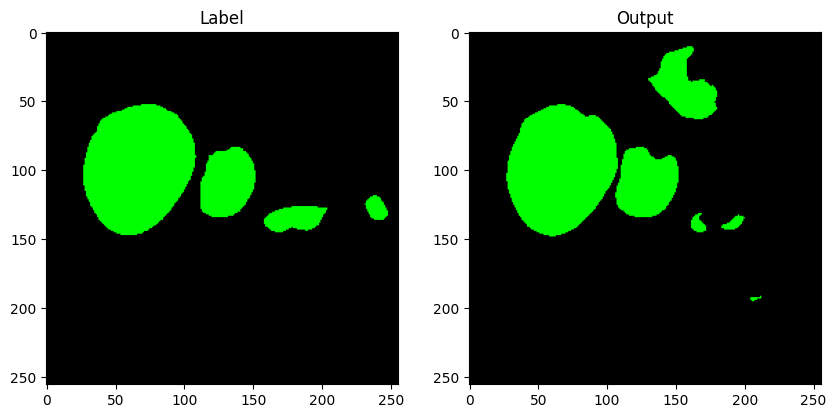

Epoch [179/200] |         Train_loss: 0.0037901761 |         Train_accuracy: 0.3328260069 |         Val_loss: 0.0949728160 |         Val_accuracy: 0.3291578166


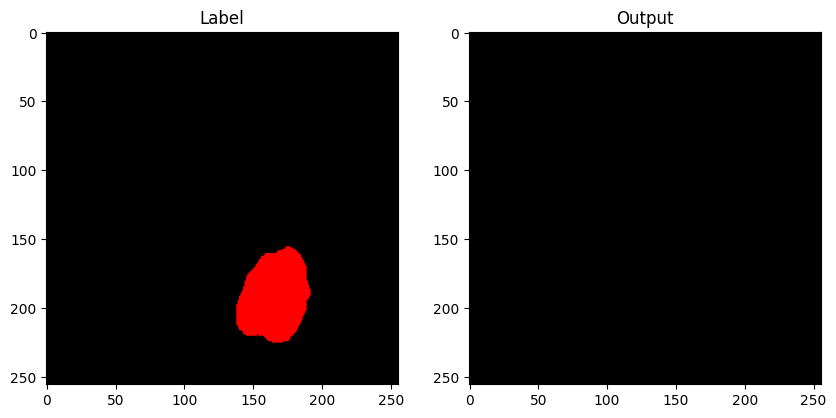

Epoch [180/200] |         Train_loss: 0.0074523172 |         Train_accuracy: 0.3325213397 |         Val_loss: 0.0867454311 |         Val_accuracy: 0.3286675008


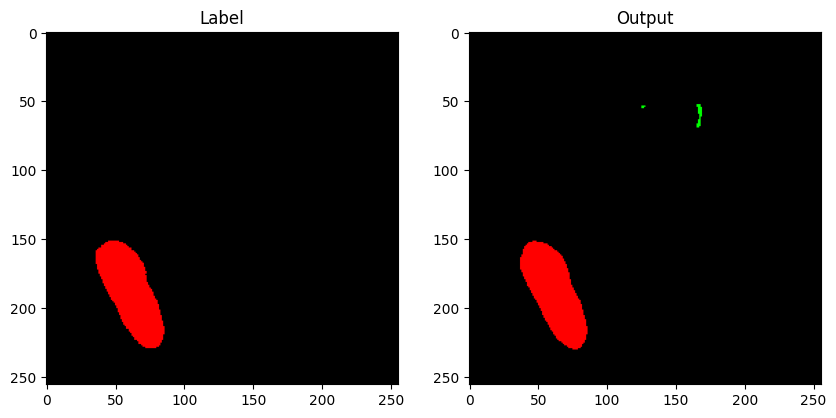

Epoch [181/200] |         Train_loss: 0.0045887534 |         Train_accuracy: 0.3327203313 |         Val_loss: 0.0837301687 |         Val_accuracy: 0.3290704346


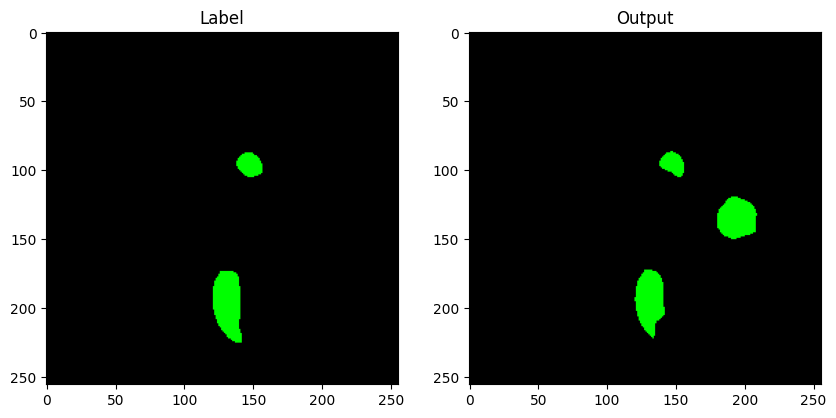

Epoch [182/200] |         Train_loss: 0.0037541629 |         Train_accuracy: 0.3328239271 |         Val_loss: 0.0966405300 |         Val_accuracy: 0.3290222677


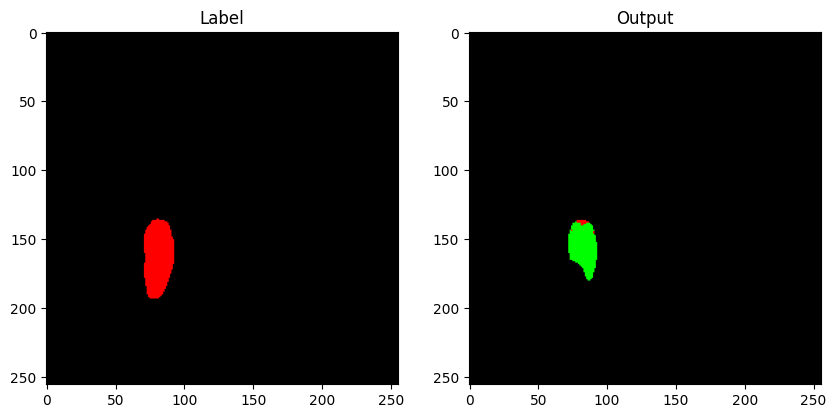

Epoch [183/200] |         Train_loss: 0.0042790175 |         Train_accuracy: 0.3328511839 |         Val_loss: 0.0903391778 |         Val_accuracy: 0.3292113749


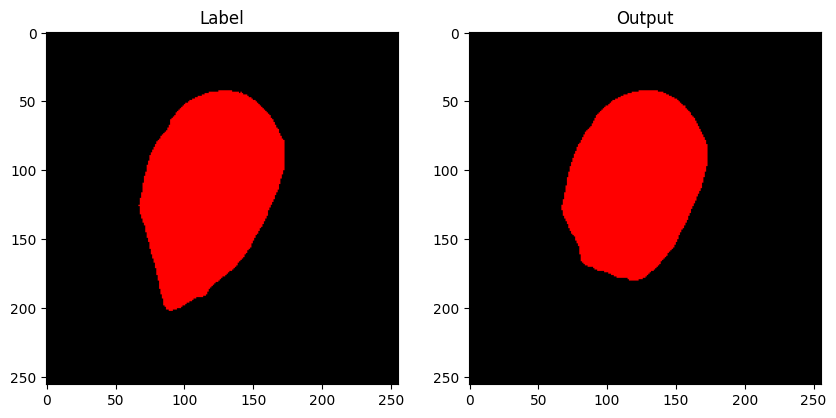

Epoch [184/200] |         Train_loss: 0.0072512982 |         Train_accuracy: 0.3325525467 |         Val_loss: 0.0883688054 |         Val_accuracy: 0.3291279093


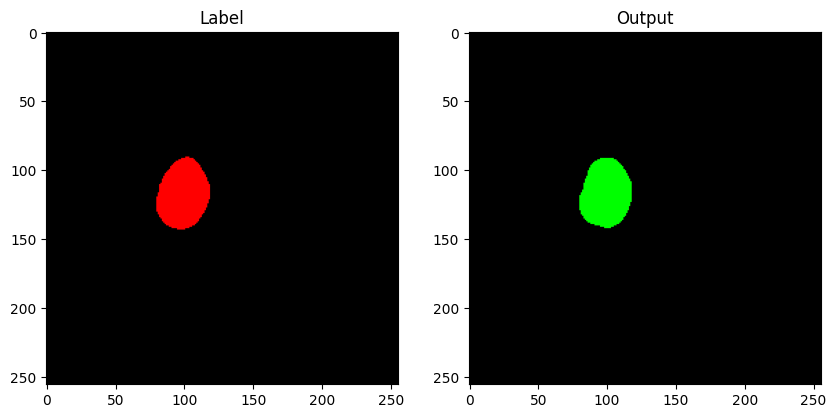

Epoch [185/200] |         Train_loss: 0.0049414819 |         Train_accuracy: 0.3326867393 |         Val_loss: 0.0929913544 |         Val_accuracy: 0.3288206482


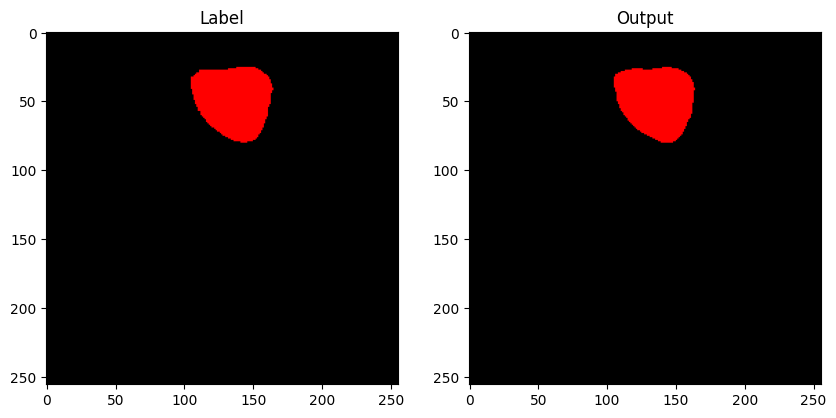

Epoch [186/200] |         Train_loss: 0.0064595869 |         Train_accuracy: 0.3325399328 |         Val_loss: 0.0796573542 |         Val_accuracy: 0.3289892578


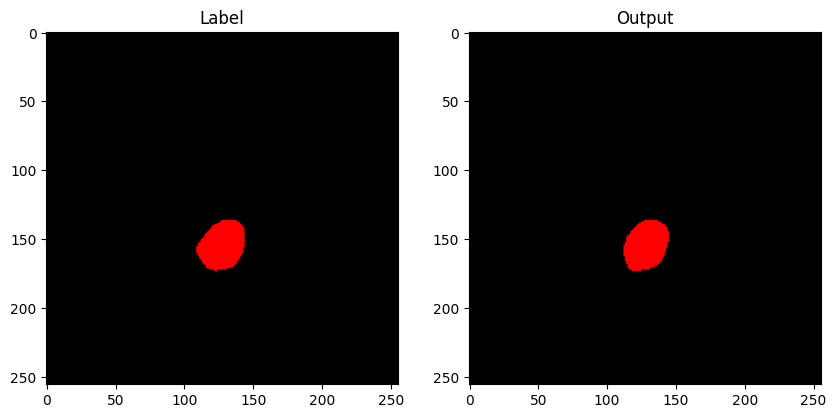

Epoch [187/200] |         Train_loss: 0.0041944593 |         Train_accuracy: 0.3327720416 |         Val_loss: 0.0826811072 |         Val_accuracy: 0.3291952515


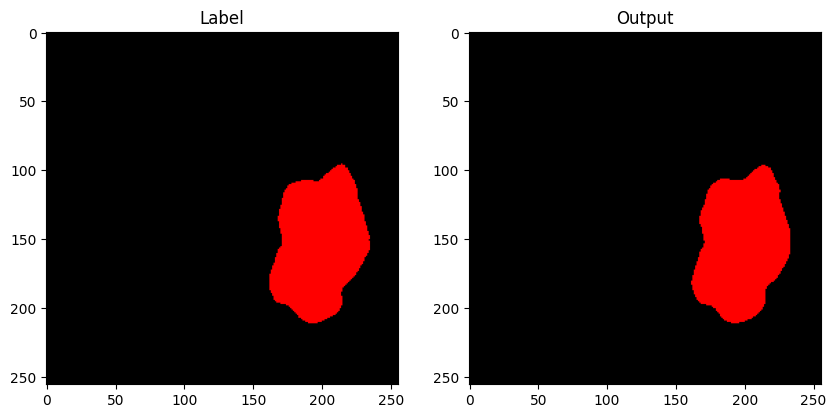

Epoch [188/200] |         Train_loss: 0.0035122617 |         Train_accuracy: 0.3328514608 |         Val_loss: 0.0870340572 |         Val_accuracy: 0.3293409729


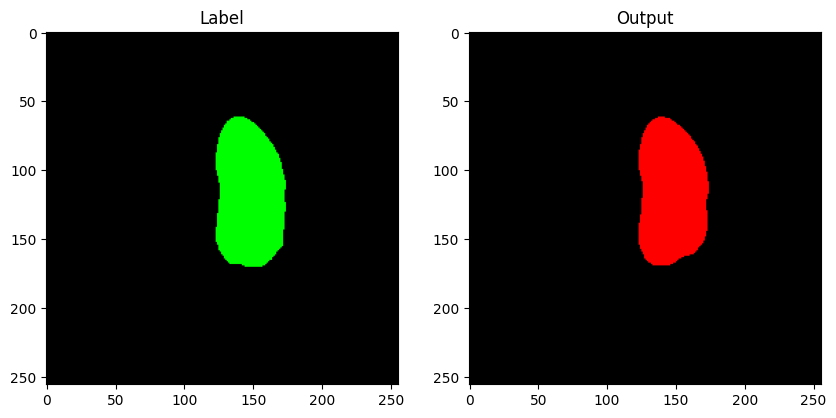

Epoch [189/200] |         Train_loss: 0.0034034167 |         Train_accuracy: 0.3328566827 |         Val_loss: 0.0877269956 |         Val_accuracy: 0.3293561300


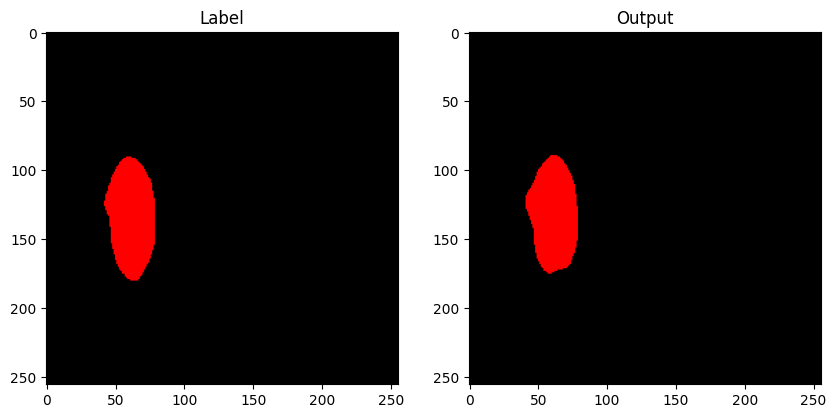

Epoch [190/200] |         Train_loss: 0.0047042451 |         Train_accuracy: 0.3327203878 |         Val_loss: 0.0844710128 |         Val_accuracy: 0.3289648438


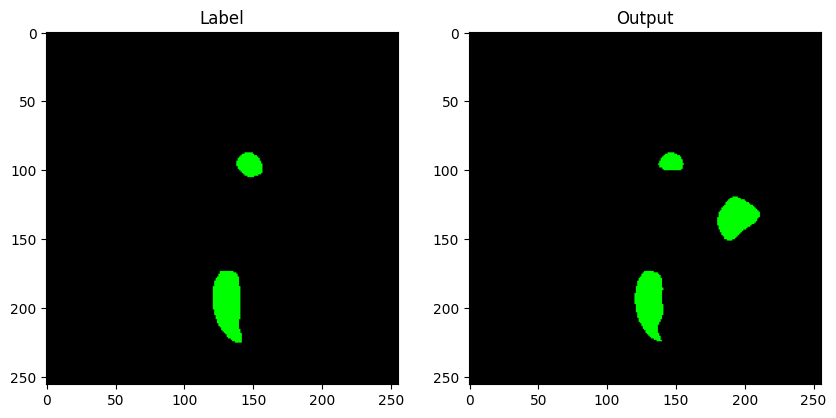

Epoch [191/200] |         Train_loss: 0.0037979914 |         Train_accuracy: 0.3328251817 |         Val_loss: 0.1017826660 |         Val_accuracy: 0.3289351400


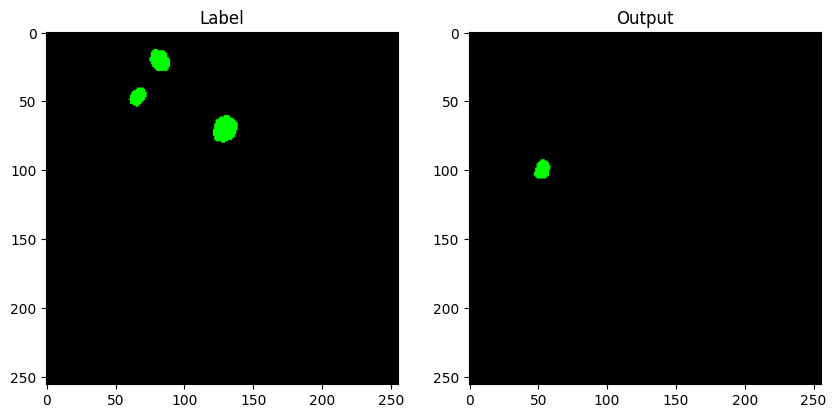

Epoch [192/200] |         Train_loss: 0.0071624110 |         Train_accuracy: 0.3325179489 |         Val_loss: 0.0818878415 |         Val_accuracy: 0.3291246541


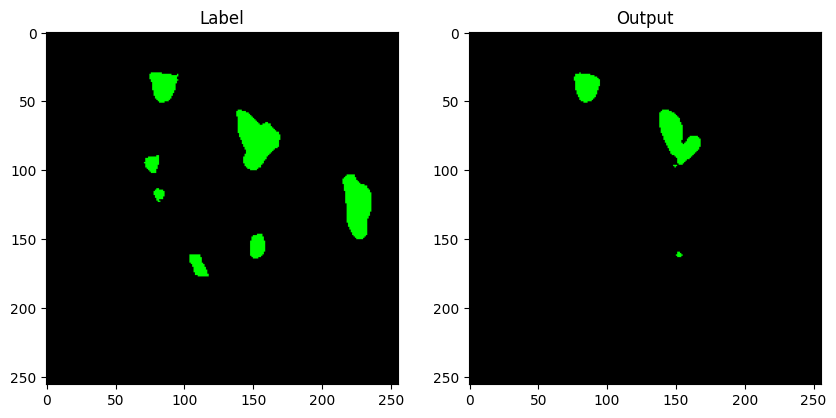

Epoch [193/200] |         Train_loss: 0.0074262070 |         Train_accuracy: 0.3324968861 |         Val_loss: 0.0853079161 |         Val_accuracy: 0.3287883504


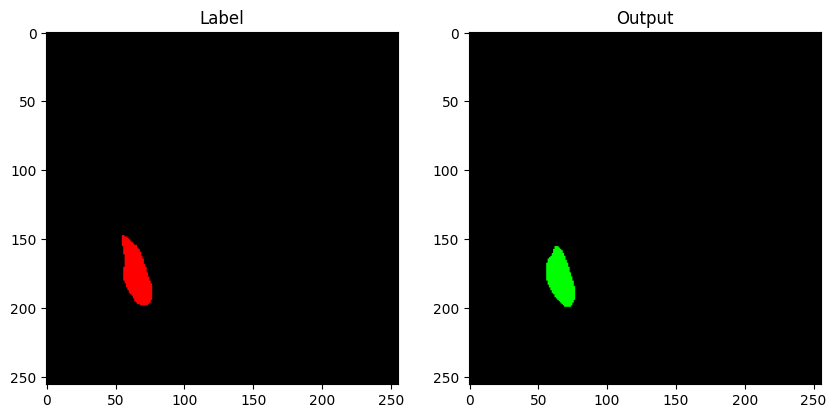

Epoch [194/200] |         Train_loss: 0.0051452380 |         Train_accuracy: 0.3326919104 |         Val_loss: 0.0749122624 |         Val_accuracy: 0.3292362976


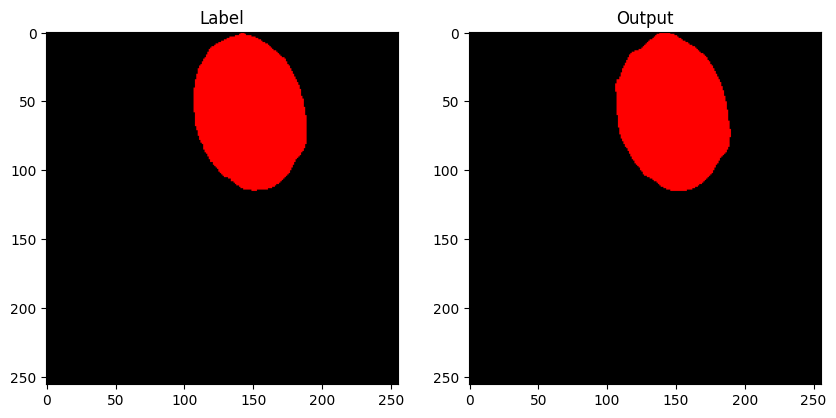

Epoch [195/200] |         Train_loss: 0.0071042767 |         Train_accuracy: 0.3324620847 |         Val_loss: 0.0808679224 |         Val_accuracy: 0.3290992737


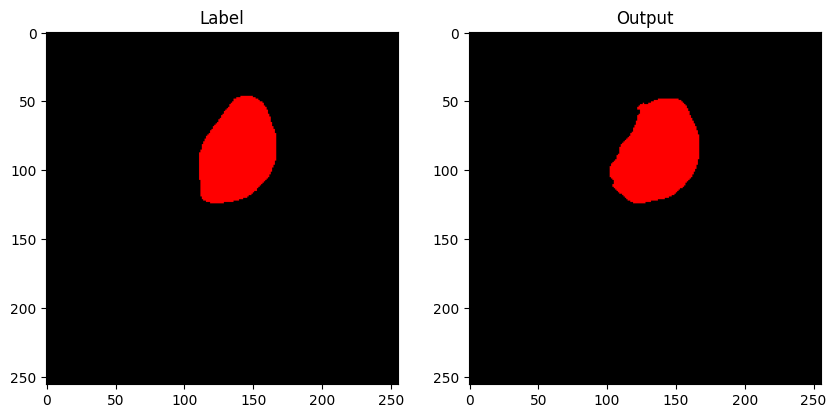

Epoch [196/200] |         Train_loss: 0.0070653812 |         Train_accuracy: 0.3324920033 |         Val_loss: 0.0668590135 |         Val_accuracy: 0.3288954163


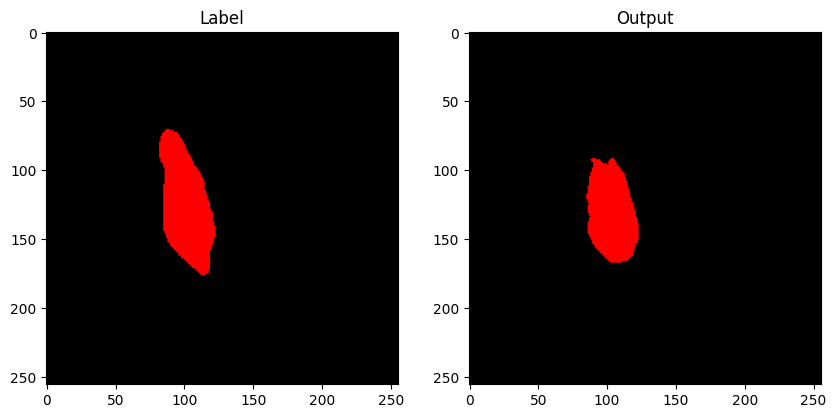

Epoch [197/200] |         Train_loss: 0.0081727223 |         Train_accuracy: 0.3323654118 |         Val_loss: 0.0661758379 |         Val_accuracy: 0.3289444987


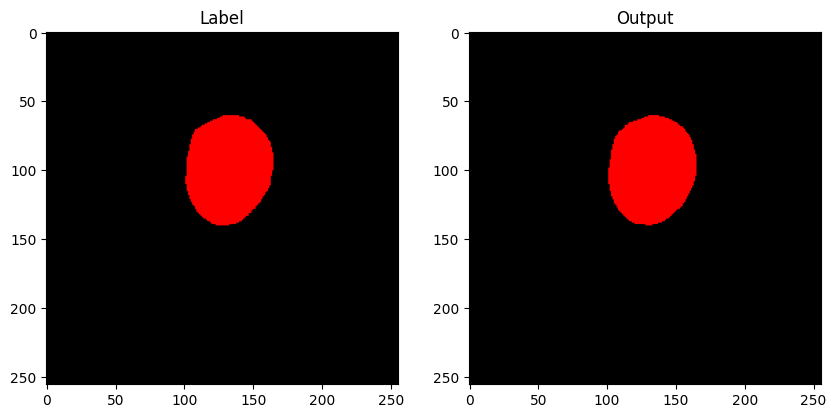

Epoch [198/200] |         Train_loss: 0.0071274916 |         Train_accuracy: 0.3324329348 |         Val_loss: 0.0697612406 |         Val_accuracy: 0.3288746134


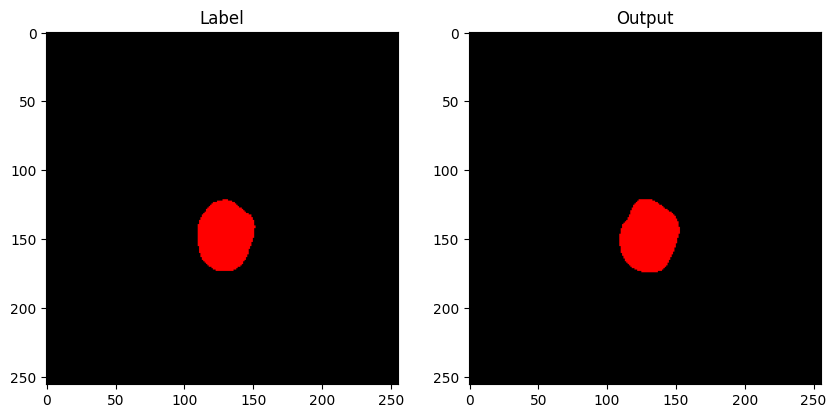

Epoch [199/200] |         Train_loss: 0.0042168095 |         Train_accuracy: 0.3327688033 |         Val_loss: 0.0736085530 |         Val_accuracy: 0.3293897502


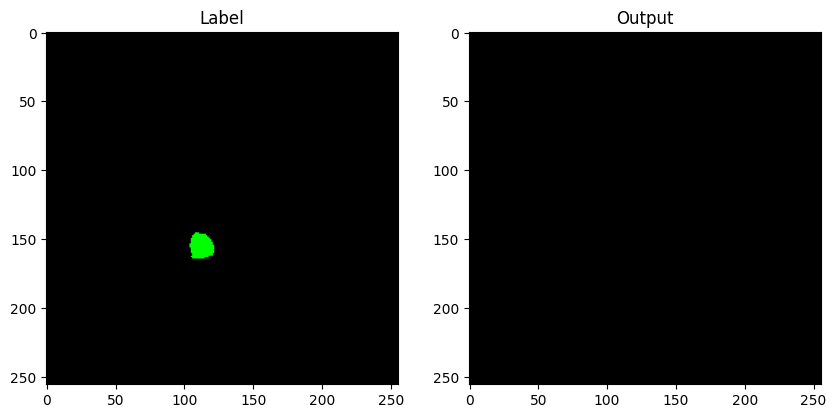

Epoch [200/200] |         Train_loss: 0.0036161082 |         Train_accuracy: 0.3328428254 |         Val_loss: 0.0754587155 |         Val_accuracy: 0.3292678833


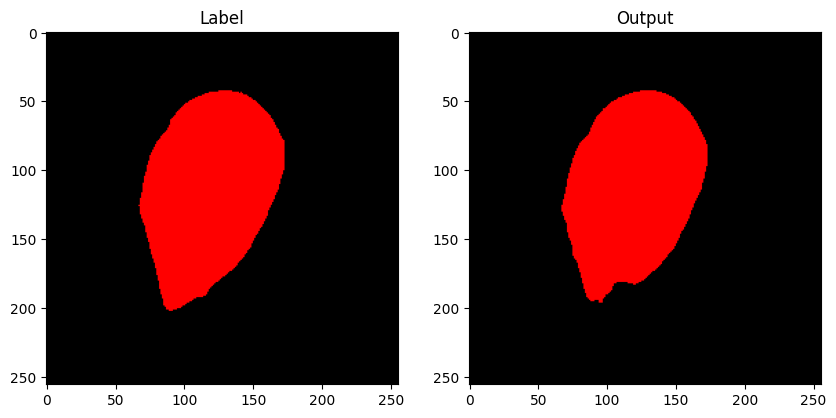

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇██
train_accuracy,▁▆▆▇▆▇▇██▇██████████████████████████████
train_loss,█▆▄▃▁▁▁▁▂▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▃▅▄▂▇▇▇▇▇▇▇▆▇█▆▆▅▇▆▇██▆▆▅▄▆▆▇▆▄▇▇▆▅▆▆▆
val_loss,▂▁▁▂▃▃▃▄▂▂▄▂▄▃▄▃▄▃▃▄▅▄▆▅▆▇▅▆▆▆▇█▆▅▆▆▇▆▆▅
epoch,200
train_accuracy,0.33284
train_loss,0.00362
val_accuracy,0.32927
val_loss,0.07546


In [18]:
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
best_val_loss = 999

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    train_accuracy = 0
    train_samples = 0
    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        labels = labels.squeeze(dim=1).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Update metrics
        train_loss += loss.item()  # Cộng dồn loss
        
        pred = outputs.argmax(dim=1, keepdim=True)
        train_accuracy += (pred.eq(labels.view_as(pred)).sum().item())/(3*256*256)
        train_samples += labels.size(0)
    train_loss /= len(train_loader)
    train_accuracy /= train_samples
        

    model.eval()
    val_loss = 0
    val_accuracy = 0
    val_samples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            labels = labels.squeeze(dim=1).long()
            
            outputs = model(images)
            loss = criterion(outputs.float(),labels.long()).item()
            val_loss += loss
            pred = outputs.argmax(dim = 1, keepdim = True)
            val_accuracy += (pred.eq(labels.view_as(pred)).sum().item())/(3*256*256)  # Cộng dồn số dự đoán đúng
            val_samples += labels.size(0)  # Cộng số mẫu trong batch
        val_loss /= len(val_loader)  # Validation loss trung bình
        val_accuracy /= val_samples  # Validation accuracy = số dự đoán đúng / tổng số mẫu
    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] | \
        Train_loss: {train_loss:.10f} | \
        Train_accuracy: {train_accuracy:.10f} | \
        Val_loss: {val_loss:.10f} | \
        Val_accuracy: {val_accuracy:.10f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_path = f'/kaggle/working/model.pth'
        torch.save(model.state_dict(), save_path)
        print('New best checkpoint saved!')
    
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss" : val_loss,
        "val_accuracy" : val_accuracy
    })

    label = labels[1].cpu().numpy()
    label = mask_to_rgb(label,color_dict)
    outputs[1] = outputs[1].softmax(dim=0)
    output = outputs[1].cpu().numpy()
    output = np.argmax(output, axis=0)
    output = mask_to_rgb(output,color_dict)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(label)
    axs[0].set_title('Label')
    axs[1].imshow(output)
    axs[1].set_title('Output')
    plt.show()
wandb.finish()

# Reference

In [19]:
checkpoint = torch.load('/kaggle/working/model.pth')
model.load_state_dict(checkpoint)

/tmp/ipykernel_30/4139611264.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/model.pth')


<All keys matched successfully>

In [20]:
! mkdir prediction

In [21]:
    model.eval()
    for i in os.listdir("/kaggle/input/polyps-bkai/test/test"):
        img_path = os.path.join("/kaggle/input/polyps-bkai/test/test", i)
        ori_img = cv2.imread(img_path)
        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
        ori_w = ori_img.shape[0]
        ori_h = ori_img.shape[1]
        img = cv2.resize(ori_img, (256, 256))
        transformed = val_transform(image=img)
        input_img = transformed["image"]
        input_img = input_img.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output_mask = model(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
        mask = cv2.resize(output_mask, (ori_h, ori_w))
        mask = np.argmax(mask, axis=2)
        mask_rgb = mask_to_rgb(mask, color_dict)
        mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
        cv2.imwrite("prediction/{}".format(i), mask_rgb)

In [22]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = r'/kaggle/working/prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'test_mask_result.csv', index=False)
print('Finish')

/kaggle/working/prediction/a9d45c3dbc695325ded465efde988dfb.jpeg
/kaggle/working/prediction/3c692195f853af7f8a4df1ec859759b7.jpeg
/kaggle/working/prediction/faef7fdb2d45b21960c94b0aab4c024a.jpeg
/kaggle/working/prediction/67d4dcf9596154efb7cef748d9cbd617.jpeg
/kaggle/working/prediction/2ed9fbb63b28163a745959c03983064a.jpeg
/kaggle/working/prediction/e2cd066b9fdbc3bbc04a3afe1f119f21.jpeg
/kaggle/working/prediction/c7e610b1531871f2fd85a04faeeb2b53.jpeg
/kaggle/working/prediction/461c2a337948a41964c1d4f50a5f3601.jpeg
/kaggle/working/prediction/d5060a633a8d5b2b2b55157b7781e2c7.jpeg
/kaggle/working/prediction/63b8318ecf467d7ad048df39beb17636.jpeg
/kaggle/working/prediction/a15fc656702fa602bb3c7abacdbd7e6a.jpeg
/kaggle/working/prediction/54ba59c7de13a35276a476420655433a.jpeg
/kaggle/working/prediction/343f27ebc5d92b9076135d76d0bbd4ce.jpeg
/kaggle/working/prediction/7fda8019410b1fcf0625f608b4ce9762.jpeg
/kaggle/working/prediction/d6bf62f215f0da4ad3a7ab8df9da7386.jpeg
/kaggle/working/predictio